## Load libraries and files

In [1]:
!pyenv local 3.6.15
# Install any of the following packages with pip if you don't
# have them installed already
# Install stmpy package with the command "pip3 install getstmpy"
import stmpy
import stmpy.driftcorr as dfc
import h5py
import scipy as sp
%pylab inline
from decimal import Decimal, getcontext

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-define functions to do data recovery

from pylbfgs import owlqn

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T
#     print(shape(x2))
#     x2 = x2 * np.hanning(nx)[:, None] * np.hanning(nx)[None, :]
    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx


def dct2(x):
#     x, y = np.shape(x)
#     w = np.hanning(x)[:, None] * np.hanning(x)[None, :]
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
#     return stmpy.tools.ifft(x)
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [3]:
def standardize(data):
    data1 = (data / mean(data))
    return data1

### The 40 nm topo

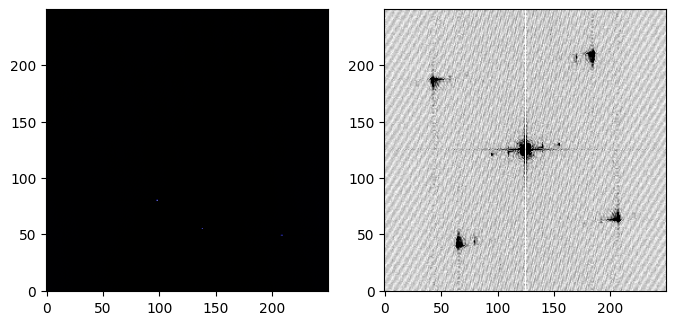

In [4]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo001.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)
dfc.display(t.z)

## drift correct then reconstruction

### drift correction

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

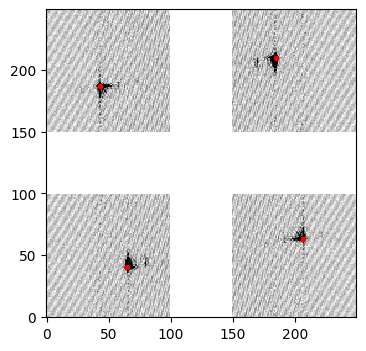

In [5]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


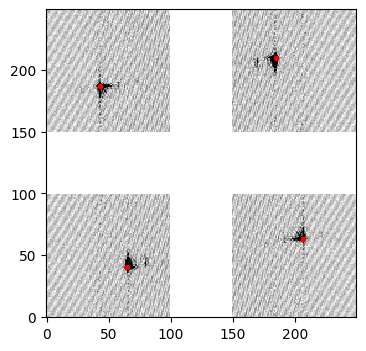

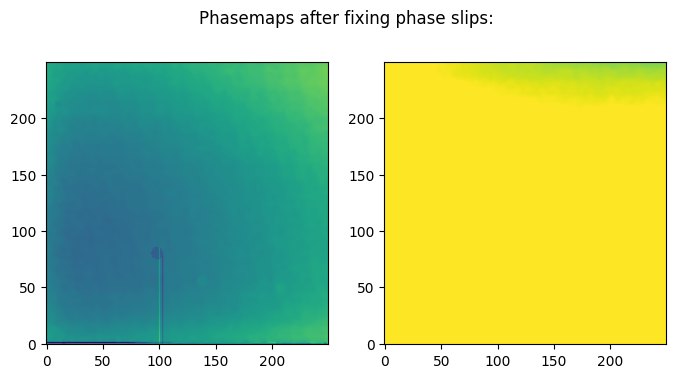

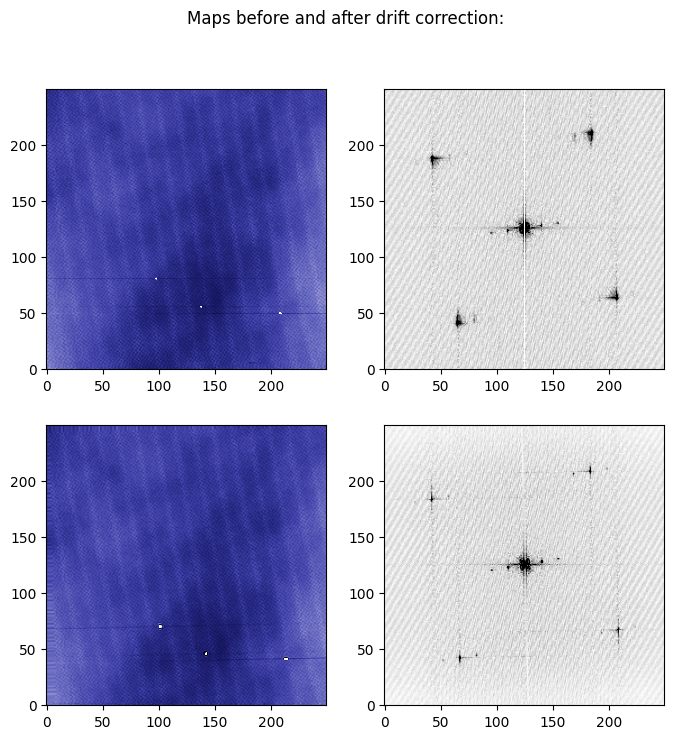

In [6]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, sigma=20, show=True, method='lockin')

### sparse sampling

In [7]:
original_mean = mean(t.z_c)
test = standardize(t.z_c)
nx, ny = shape(t.z_c)

In [8]:
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # defining a random sample of indices
b = test.T.flat[ri]

In [9]:
testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

Iteration 1:
  fx = 350222155.263527, xnorm = 249.996993, gnorm = 37428.296438, step = 0.000027, k = 1, ls = 1

Iteration 2:
  fx = 147073247.320975, xnorm = 12269.632277, gnorm = 24234.143128, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 766942.656191, xnorm = 21967.377063, gnorm = 1407.641093, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 271332.289695, xnorm = 21822.247103, gnorm = 48.418015, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 270712.151502, xnorm = 21818.950781, gnorm = 11.361557, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 270638.910847, xnorm = 21816.677399, gnorm = 11.292107, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 269370.574985, xnorm = 21748.178934, gnorm = 62.431974, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 268667.805816, xnorm = 21724.684213, gnorm = 52.918744, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 268557.710132, xnorm = 21708.171279, gnorm = 71.699655, step = 0.250000, k = 9, ls = 3

Iteration 10:
  

Iteration 76:
  fx = 248586.398515, xnorm = 21101.934782, gnorm = 34.992988, step = 0.500000, k = 76, ls = 2

Iteration 77:
  fx = 248188.786625, xnorm = 21103.794328, gnorm = 19.301488, step = 0.500000, k = 77, ls = 2

Iteration 78:
  fx = 248138.452188, xnorm = 21090.697446, gnorm = 34.949450, step = 0.500000, k = 78, ls = 2

Iteration 79:
  fx = 247742.873576, xnorm = 21092.602488, gnorm = 19.455243, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 247692.728635, xnorm = 21079.630362, gnorm = 34.957767, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 247297.080074, xnorm = 21081.530023, gnorm = 19.273665, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 247249.220380, xnorm = 21068.724274, gnorm = 34.934029, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 246853.983779, xnorm = 21070.652568, gnorm = 19.063246, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 246811.140290, xnorm = 21057.994092, gnorm = 35.017335, step = 0.500000, k = 84, ls = 2

Iteration 

Iteration 156:
  fx = 232734.866390, xnorm = 20759.472180, gnorm = 31.085169, step = 0.500000, k = 156, ls = 2

Iteration 157:
  fx = 232423.914440, xnorm = 20762.134558, gnorm = 16.529018, step = 0.500000, k = 157, ls = 2

Iteration 158:
  fx = 232393.921853, xnorm = 20753.335780, gnorm = 30.852035, step = 0.500000, k = 158, ls = 2

Iteration 159:
  fx = 232088.117804, xnorm = 20756.015396, gnorm = 16.506695, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 232056.680533, xnorm = 20747.283167, gnorm = 30.666648, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 231755.345127, xnorm = 20749.981800, gnorm = 16.571407, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 231723.852141, xnorm = 20741.311287, gnorm = 30.574847, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 231424.067643, xnorm = 20744.096731, gnorm = 16.487619, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 231392.412044, xnorm = 20735.563674, gnorm = 30.421828, step = 0.500000, k = 164, 

Iteration 233:
  fx = 221200.516172, xnorm = 20586.784517, gnorm = 14.438325, step = 0.500000, k = 233, ls = 2

Iteration 234:
  fx = 221177.912446, xnorm = 20579.825688, gnorm = 26.873307, step = 0.500000, k = 234, ls = 2

Iteration 235:
  fx = 220944.343158, xnorm = 20583.456498, gnorm = 14.363377, step = 0.500000, k = 235, ls = 2

Iteration 236:
  fx = 220922.537703, xnorm = 20576.547560, gnorm = 26.834763, step = 0.500000, k = 236, ls = 2

Iteration 237:
  fx = 220689.651343, xnorm = 20580.225243, gnorm = 14.367021, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 220667.855659, xnorm = 20573.332136, gnorm = 26.767156, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 220435.877668, xnorm = 20577.059993, gnorm = 14.353569, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 220413.510911, xnorm = 20570.170176, gnorm = 26.713409, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 220182.539171, xnorm = 20573.927429, gnorm = 14.304950, step = 0.500000, k = 241, 

Iteration 311:
  fx = 212210.370848, xnorm = 20499.697890, gnorm = 12.886773, step = 0.500000, k = 311, ls = 2

Iteration 312:
  fx = 212192.514344, xnorm = 20494.133449, gnorm = 23.976423, step = 0.500000, k = 312, ls = 2

Iteration 313:
  fx = 212004.980041, xnorm = 20498.458797, gnorm = 12.780881, step = 0.500000, k = 313, ls = 2

Iteration 314:
  fx = 211987.802262, xnorm = 20492.850257, gnorm = 23.919255, step = 0.500000, k = 314, ls = 2

Iteration 315:
  fx = 211801.062688, xnorm = 20497.237110, gnorm = 12.736486, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 211783.547238, xnorm = 20491.639966, gnorm = 23.825278, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 211598.407036, xnorm = 20496.041925, gnorm = 12.737646, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 211581.348879, xnorm = 20490.483486, gnorm = 23.801485, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 211396.245802, xnorm = 20494.883656, gnorm = 12.686348, step = 0.500000, k = 319, 

Iteration 388:
  fx = 205116.534311, xnorm = 20472.268327, gnorm = 21.543741, step = 0.500000, k = 388, ls = 2

Iteration 389:
  fx = 204965.161408, xnorm = 20477.000183, gnorm = 11.647495, step = 0.500000, k = 389, ls = 2

Iteration 390:
  fx = 204950.654432, xnorm = 20472.358568, gnorm = 21.529626, step = 0.500000, k = 390, ls = 2

Iteration 391:
  fx = 204798.889727, xnorm = 20477.065532, gnorm = 11.521059, step = 0.500000, k = 391, ls = 2

Iteration 392:
  fx = 204785.478451, xnorm = 20472.475824, gnorm = 21.486735, step = 0.500000, k = 392, ls = 2

Iteration 393:
  fx = 204633.953776, xnorm = 20477.161891, gnorm = 11.395265, step = 0.500000, k = 393, ls = 2

Iteration 394:
  fx = 204620.855251, xnorm = 20472.582166, gnorm = 21.401864, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 204470.485284, xnorm = 20477.275993, gnorm = 11.350290, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 204457.039029, xnorm = 20472.719350, gnorm = 21.334196, step = 0.500000, k = 396, 

Iteration 466:
  fx = 199233.300957, xnorm = 20491.925867, gnorm = 19.475382, step = 0.500000, k = 466, ls = 2

Iteration 467:
  fx = 199108.148435, xnorm = 20496.514987, gnorm = 10.410288, step = 0.500000, k = 467, ls = 2

Iteration 468:
  fx = 199095.965251, xnorm = 20492.866149, gnorm = 19.388201, step = 0.500000, k = 468, ls = 2

Iteration 469:
  fx = 198972.037020, xnorm = 20497.431106, gnorm = 10.453815, step = 0.500000, k = 469, ls = 2

Iteration 470:
  fx = 198959.725642, xnorm = 20493.776845, gnorm = 19.358452, step = 0.500000, k = 470, ls = 2

Iteration 471:
  fx = 198836.187729, xnorm = 20498.377939, gnorm = 10.407131, step = 0.500000, k = 471, ls = 2

Iteration 472:
  fx = 198824.237881, xnorm = 20494.763161, gnorm = 19.303944, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 198701.170435, xnorm = 20499.324867, gnorm = 10.348233, step = 0.500000, k = 473, ls = 2

Iteration 474:
  fx = 198689.286476, xnorm = 20495.719345, gnorm = 19.251890, step = 0.500000, k = 474, 

Iteration 543:
  fx = 194395.428147, xnorm = 20543.729046, gnorm = 9.559326, step = 0.500000, k = 543, ls = 2

Iteration 544:
  fx = 194384.552870, xnorm = 20540.736807, gnorm = 17.535591, step = 0.500000, k = 544, ls = 2

Iteration 545:
  fx = 194282.524038, xnorm = 20545.312445, gnorm = 9.495144, step = 0.500000, k = 545, ls = 2

Iteration 546:
  fx = 194272.721711, xnorm = 20542.307088, gnorm = 17.599267, step = 0.500000, k = 546, ls = 2

Iteration 547:
  fx = 194169.842781, xnorm = 20546.876007, gnorm = 9.368411, step = 0.500000, k = 547, ls = 2

Iteration 548:
  fx = 194160.550271, xnorm = 20543.902987, gnorm = 17.542623, step = 0.500000, k = 548, ls = 2

Iteration 549:
  fx = 194058.319455, xnorm = 20548.486314, gnorm = 9.320350, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 194049.407822, xnorm = 20545.475998, gnorm = 17.528317, step = 0.500000, k = 550, ls = 2

Iteration 551:
  fx = 193947.358605, xnorm = 20550.096599, gnorm = 9.253344, step = 0.500000, k = 551, ls = 

Iteration 619:
  fx = 190444.642882, xnorm = 20611.576004, gnorm = 8.731291, step = 0.500000, k = 619, ls = 2

Iteration 620:
  fx = 190435.607889, xnorm = 20608.926843, gnorm = 16.045062, step = 0.500000, k = 620, ls = 2

Iteration 621:
  fx = 190350.219873, xnorm = 20613.565986, gnorm = 8.728798, step = 0.500000, k = 621, ls = 2

Iteration 622:
  fx = 190341.470311, xnorm = 20610.936533, gnorm = 16.031677, step = 0.500000, k = 622, ls = 2

Iteration 623:
  fx = 190256.035119, xnorm = 20615.547761, gnorm = 8.628843, step = 0.500000, k = 623, ls = 2

Iteration 624:
  fx = 190247.272390, xnorm = 20612.949114, gnorm = 15.884205, step = 0.500000, k = 624, ls = 2

Iteration 625:
  fx = 190163.381327, xnorm = 20617.526703, gnorm = 8.592255, step = 0.500000, k = 625, ls = 2

Iteration 626:
  fx = 190154.489645, xnorm = 20614.972774, gnorm = 15.808545, step = 0.500000, k = 626, ls = 2

Iteration 627:
  fx = 190071.473755, xnorm = 20619.547106, gnorm = 8.685690, step = 0.500000, k = 627, ls = 

Iteration 693:
  fx = 187203.210807, xnorm = 20690.502304, gnorm = 8.068382, step = 0.500000, k = 693, ls = 2

Iteration 694:
  fx = 187194.816759, xnorm = 20688.249286, gnorm = 14.723026, step = 0.500000, k = 694, ls = 2

Iteration 695:
  fx = 187122.740992, xnorm = 20692.742936, gnorm = 8.098931, step = 0.500000, k = 695, ls = 2

Iteration 696:
  fx = 187114.144887, xnorm = 20690.538152, gnorm = 14.659463, step = 0.500000, k = 696, ls = 2

Iteration 697:
  fx = 187042.733949, xnorm = 20695.005241, gnorm = 8.095642, step = 0.500000, k = 697, ls = 2

Iteration 698:
  fx = 187034.259147, xnorm = 20692.825108, gnorm = 14.614654, step = 0.500000, k = 698, ls = 2

Iteration 699:
  fx = 186962.949730, xnorm = 20697.284277, gnorm = 8.034704, step = 0.500000, k = 699, ls = 2

Iteration 700:
  fx = 186954.925886, xnorm = 20695.121457, gnorm = 14.616771, step = 0.500000, k = 700, ls = 2

Iteration 701:
  fx = 186883.450378, xnorm = 20699.567966, gnorm = 7.991246, step = 0.500000, k = 701, ls = 

Iteration 769:
  fx = 184379.078006, xnorm = 20779.687350, gnorm = 7.505005, step = 0.500000, k = 769, ls = 2

Iteration 770:
  fx = 184371.843321, xnorm = 20777.778545, gnorm = 13.573329, step = 0.500000, k = 770, ls = 2

Iteration 771:
  fx = 184310.178280, xnorm = 20782.132354, gnorm = 7.442820, step = 0.500000, k = 771, ls = 2

Iteration 772:
  fx = 184302.961098, xnorm = 20780.209420, gnorm = 13.521997, step = 0.500000, k = 772, ls = 2

Iteration 773:
  fx = 184241.701041, xnorm = 20784.547374, gnorm = 7.399608, step = 0.500000, k = 773, ls = 2

Iteration 774:
  fx = 184234.312301, xnorm = 20782.648433, gnorm = 13.454199, step = 0.500000, k = 774, ls = 2

Iteration 775:
  fx = 184173.791456, xnorm = 20786.991558, gnorm = 7.410952, step = 0.500000, k = 775, ls = 2

Iteration 776:
  fx = 184166.396696, xnorm = 20785.086383, gnorm = 13.446077, step = 0.500000, k = 776, ls = 2

Iteration 777:
  fx = 184105.990169, xnorm = 20789.419503, gnorm = 7.433240, step = 0.500000, k = 777, ls = 

Iteration 844:
  fx = 182008.811994, xnorm = 20869.547105, gnorm = 12.578461, step = 0.500000, k = 844, ls = 2

Iteration 845:
  fx = 181955.732081, xnorm = 20873.685358, gnorm = 6.940751, step = 0.500000, k = 845, ls = 2

Iteration 846:
  fx = 181949.246765, xnorm = 20872.091528, gnorm = 12.561871, step = 0.500000, k = 846, ls = 2

Iteration 847:
  fx = 181896.313236, xnorm = 20876.240281, gnorm = 6.936710, step = 0.500000, k = 847, ls = 2

Iteration 848:
  fx = 181890.018859, xnorm = 20874.648086, gnorm = 12.552447, step = 0.500000, k = 848, ls = 2

Iteration 849:
  fx = 181837.088984, xnorm = 20878.765678, gnorm = 6.857929, step = 0.500000, k = 849, ls = 2

Iteration 850:
  fx = 181830.907223, xnorm = 20877.192838, gnorm = 12.505692, step = 0.500000, k = 850, ls = 2

Iteration 851:
  fx = 181778.359020, xnorm = 20881.310060, gnorm = 6.880541, step = 0.500000, k = 851, ls = 2

Iteration 852:
  fx = 181772.094363, xnorm = 20879.709893, gnorm = 12.489464, step = 0.500000, k = 852, ls =

Iteration 920:
  fx = 179911.785289, xnorm = 20966.805793, gnorm = 11.689298, step = 0.500000, k = 920, ls = 2

Iteration 921:
  fx = 179865.571188, xnorm = 20970.833786, gnorm = 6.425971, step = 0.500000, k = 921, ls = 2

Iteration 922:
  fx = 179860.165472, xnorm = 20969.420479, gnorm = 11.657174, step = 0.500000, k = 922, ls = 2

Iteration 923:
  fx = 179814.215591, xnorm = 20973.431725, gnorm = 6.390678, step = 0.500000, k = 923, ls = 2

Iteration 924:
  fx = 179808.659667, xnorm = 20972.052369, gnorm = 11.599417, step = 0.500000, k = 924, ls = 2

Iteration 925:
  fx = 179763.245600, xnorm = 20976.034672, gnorm = 6.407007, step = 0.500000, k = 925, ls = 2

Iteration 926:
  fx = 179757.477494, xnorm = 20974.620517, gnorm = 11.560881, step = 0.500000, k = 926, ls = 2

Iteration 927:
  fx = 179712.508159, xnorm = 20978.642146, gnorm = 6.456578, step = 0.500000, k = 927, ls = 2

Iteration 928:
  fx = 179706.672881, xnorm = 20977.249134, gnorm = 11.544958, step = 0.500000, k = 928, ls =

Iteration 995:
  fx = 178072.446717, xnorm = 21069.027821, gnorm = 6.105951, step = 0.500000, k = 995, ls = 2

Iteration 996:
  fx = 178066.968636, xnorm = 21067.861257, gnorm = 10.807812, step = 0.500000, k = 996, ls = 2

Iteration 997:
  fx = 178027.592045, xnorm = 21071.670441, gnorm = 6.079845, step = 0.500000, k = 997, ls = 2

Iteration 998:
  fx = 178022.035988, xnorm = 21070.520565, gnorm = 10.764547, step = 0.500000, k = 998, ls = 2

Iteration 999:
  fx = 177982.985183, xnorm = 21074.322585, gnorm = 6.077285, step = 0.500000, k = 999, ls = 2

Iteration 1000:
  fx = 177977.429048, xnorm = 21073.152480, gnorm = 10.749361, step = 0.500000, k = 1000, ls = 2

Iteration 1001:
  fx = 177938.456231, xnorm = 21076.961259, gnorm = 6.079508, step = 0.500000, k = 1001, ls = 2

Iteration 1002:
  fx = 177932.840624, xnorm = 21075.824605, gnorm = 10.730310, step = 0.500000, k = 1002, ls = 2

Iteration 1003:
  fx = 177894.082455, xnorm = 21079.633423, gnorm = 6.098139, step = 0.500000, k = 100

Iteration 1071:
  fx = 176476.067039, xnorm = 21169.265085, gnorm = 5.755038, step = 0.500000, k = 1071, ls = 2

Iteration 1072:
  fx = 176470.864860, xnorm = 21168.233098, gnorm = 10.044606, step = 0.500000, k = 1072, ls = 2

Iteration 1073:
  fx = 176436.784594, xnorm = 21171.912599, gnorm = 5.741621, step = 0.500000, k = 1073, ls = 2

Iteration 1074:
  fx = 176431.665177, xnorm = 21170.879312, gnorm = 10.039077, step = 0.500000, k = 1074, ls = 2

Iteration 1075:
  fx = 176397.558407, xnorm = 21174.536619, gnorm = 5.702390, step = 0.500000, k = 1075, ls = 2

Iteration 1076:
  fx = 176392.606015, xnorm = 21173.530115, gnorm = 10.043551, step = 0.500000, k = 1076, ls = 2

Iteration 1077:
  fx = 176358.465432, xnorm = 21177.154623, gnorm = 5.676036, step = 0.500000, k = 1077, ls = 2

Iteration 1078:
  fx = 176353.462715, xnorm = 21176.169855, gnorm = 9.998697, step = 0.500000, k = 1078, ls = 2

Iteration 1079:
  fx = 176319.668261, xnorm = 21179.781405, gnorm = 5.682575, step = 0.500000

Iteration 1145:
  fx = 175116.977580, xnorm = 21266.286059, gnorm = 5.415532, step = 0.500000, k = 1145, ls = 2

Iteration 1146:
  fx = 175112.196228, xnorm = 21265.471536, gnorm = 9.338992, step = 0.500000, k = 1146, ls = 2

Iteration 1147:
  fx = 175082.660076, xnorm = 21268.883571, gnorm = 5.391190, step = 0.500000, k = 1147, ls = 2

Iteration 1148:
  fx = 175077.855684, xnorm = 21268.077968, gnorm = 9.310744, step = 0.500000, k = 1148, ls = 2

Iteration 1149:
  fx = 175048.501393, xnorm = 21271.483249, gnorm = 5.357690, step = 0.500000, k = 1149, ls = 2

Iteration 1150:
  fx = 175043.805774, xnorm = 21270.673500, gnorm = 9.293203, step = 0.500000, k = 1150, ls = 2

Iteration 1151:
  fx = 175014.584923, xnorm = 21274.072880, gnorm = 5.330287, step = 0.500000, k = 1151, ls = 2

Iteration 1152:
  fx = 175010.034442, xnorm = 21273.259314, gnorm = 9.289668, step = 0.500000, k = 1152, ls = 2

Iteration 1153:
  fx = 174980.807363, xnorm = 21276.662190, gnorm = 5.316900, step = 0.500000, k

Iteration 1221:
  fx = 173895.045293, xnorm = 21363.552767, gnorm = 5.060064, step = 0.500000, k = 1221, ls = 2

Iteration 1222:
  fx = 173890.843517, xnorm = 21362.795254, gnorm = 8.821327, step = 0.500000, k = 1222, ls = 2

Iteration 1223:
  fx = 173864.563264, xnorm = 21366.114544, gnorm = 5.084720, step = 0.500000, k = 1223, ls = 2

Iteration 1224:
  fx = 173860.262161, xnorm = 21365.359325, gnorm = 8.799879, step = 0.500000, k = 1224, ls = 2

Iteration 1225:
  fx = 173834.070230, xnorm = 21368.676540, gnorm = 5.080289, step = 0.500000, k = 1225, ls = 2

Iteration 1226:
  fx = 173829.874441, xnorm = 21367.926284, gnorm = 8.812165, step = 0.500000, k = 1226, ls = 2

Iteration 1227:
  fx = 173803.599129, xnorm = 21371.241974, gnorm = 5.051626, step = 0.500000, k = 1227, ls = 2

Iteration 1228:
  fx = 173799.443373, xnorm = 21370.478255, gnorm = 8.786838, step = 0.500000, k = 1228, ls = 2

Iteration 1229:
  fx = 173773.310239, xnorm = 21373.789290, gnorm = 5.022439, step = 0.500000, k

Iteration 1295:
  fx = 172834.128306, xnorm = 21457.307448, gnorm = 4.790171, step = 0.500000, k = 1295, ls = 2

Iteration 1296:
  fx = 172830.180888, xnorm = 21456.608117, gnorm = 8.227596, step = 0.500000, k = 1296, ls = 2

Iteration 1297:
  fx = 172807.230002, xnorm = 21459.803562, gnorm = 4.791443, step = 0.500000, k = 1297, ls = 2

Iteration 1298:
  fx = 172803.208168, xnorm = 21459.101626, gnorm = 8.205473, step = 0.500000, k = 1298, ls = 2

Iteration 1299:
  fx = 172780.394228, xnorm = 21462.294784, gnorm = 4.788464, step = 0.500000, k = 1299, ls = 2

Iteration 1300:
  fx = 172776.442895, xnorm = 21461.590714, gnorm = 8.208623, step = 0.500000, k = 1300, ls = 2

Iteration 1301:
  fx = 172753.595839, xnorm = 21464.772001, gnorm = 4.777471, step = 0.500000, k = 1301, ls = 2

Iteration 1302:
  fx = 172749.678904, xnorm = 21464.098310, gnorm = 8.198448, step = 0.500000, k = 1302, ls = 2

Iteration 1303:
  fx = 172726.870186, xnorm = 21467.249772, gnorm = 4.748536, step = 0.500000, k

Iteration 1369:
  fx = 171885.669593, xnorm = 21548.452757, gnorm = 4.519317, step = 0.500000, k = 1369, ls = 2

Iteration 1370:
  fx = 171882.174306, xnorm = 21547.831225, gnorm = 7.798336, step = 0.500000, k = 1370, ls = 2

Iteration 1371:
  fx = 171861.561815, xnorm = 21550.884365, gnorm = 4.532572, step = 0.500000, k = 1371, ls = 2

Iteration 1372:
  fx = 171858.090446, xnorm = 21550.277163, gnorm = 7.790364, step = 0.500000, k = 1372, ls = 2

Iteration 1373:
  fx = 171837.485179, xnorm = 21553.316948, gnorm = 4.498518, step = 0.500000, k = 1373, ls = 2

Iteration 1374:
  fx = 171834.066803, xnorm = 21552.732236, gnorm = 7.765845, step = 0.500000, k = 1374, ls = 2

Iteration 1375:
  fx = 171813.600583, xnorm = 21555.744996, gnorm = 4.475539, step = 0.500000, k = 1375, ls = 2

Iteration 1376:
  fx = 171810.145085, xnorm = 21555.182992, gnorm = 7.725535, step = 0.500000, k = 1376, ls = 2

Iteration 1377:
  fx = 171789.927053, xnorm = 21558.168637, gnorm = 4.499426, step = 0.500000, k

Iteration 1443:
  fx = 171050.541746, xnorm = 21636.242645, gnorm = 4.282339, step = 0.500000, k = 1443, ls = 2

Iteration 1444:
  fx = 171047.117211, xnorm = 21635.761662, gnorm = 7.199051, step = 0.500000, k = 1444, ls = 2

Iteration 1445:
  fx = 171029.535427, xnorm = 21638.560413, gnorm = 4.297969, step = 0.500000, k = 1445, ls = 2

Iteration 1446:
  fx = 171026.082640, xnorm = 21638.087980, gnorm = 7.181979, step = 0.500000, k = 1446, ls = 2

Iteration 1447:
  fx = 171008.558754, xnorm = 21640.876409, gnorm = 4.281332, step = 0.500000, k = 1447, ls = 2

Iteration 1448:
  fx = 171005.186540, xnorm = 21640.405346, gnorm = 7.180212, step = 0.500000, k = 1448, ls = 2

Iteration 1449:
  fx = 170987.651119, xnorm = 21643.194850, gnorm = 4.270321, step = 0.500000, k = 1449, ls = 2

Iteration 1450:
  fx = 170984.317917, xnorm = 21642.714853, gnorm = 7.172127, step = 0.500000, k = 1450, ls = 2

Iteration 1451:
  fx = 170966.766491, xnorm = 21645.507000, gnorm = 4.248840, step = 0.500000, k

Iteration 1517:
  fx = 170310.599220, xnorm = 21720.813197, gnorm = 4.067136, step = 0.500000, k = 1517, ls = 2

Iteration 1518:
  fx = 170307.482973, xnorm = 21720.345360, gnorm = 6.826064, step = 0.500000, k = 1518, ls = 2

Iteration 1519:
  fx = 170291.604799, xnorm = 21723.062620, gnorm = 4.066876, step = 0.500000, k = 1519, ls = 2

Iteration 1520:
  fx = 170288.544046, xnorm = 21722.608537, gnorm = 6.838428, step = 0.500000, k = 1520, ls = 2

Iteration 1521:
  fx = 170272.624008, xnorm = 21725.329716, gnorm = 4.050550, step = 0.500000, k = 1521, ls = 2

Iteration 1522:
  fx = 170269.553421, xnorm = 21724.872031, gnorm = 6.836124, step = 0.500000, k = 1522, ls = 2

Iteration 1523:
  fx = 170253.656291, xnorm = 21727.586212, gnorm = 4.045147, step = 0.500000, k = 1523, ls = 2

Iteration 1524:
  fx = 170250.553901, xnorm = 21727.132153, gnorm = 6.816992, step = 0.500000, k = 1524, ls = 2

Iteration 1525:
  fx = 170234.736554, xnorm = 21729.845185, gnorm = 4.040750, step = 0.500000, k

Iteration 1590:
  fx = 169647.739682, xnorm = 21802.148425, gnorm = 6.720988, step = 0.500000, k = 1590, ls = 2

Iteration 1591:
  fx = 169632.384715, xnorm = 21804.816207, gnorm = 3.803773, step = 0.500000, k = 1591, ls = 2

Iteration 1592:
  fx = 169630.042219, xnorm = 21804.428362, gnorm = 6.716186, step = 0.500000, k = 1592, ls = 2

Iteration 1593:
  fx = 169614.731389, xnorm = 21807.093963, gnorm = 3.811483, step = 0.500000, k = 1593, ls = 2

Iteration 1594:
  fx = 169612.332026, xnorm = 21806.704104, gnorm = 6.693058, step = 0.500000, k = 1594, ls = 2

Iteration 1595:
  fx = 169597.126686, xnorm = 21809.365909, gnorm = 3.820290, step = 0.500000, k = 1595, ls = 2

Iteration 1596:
  fx = 169594.698404, xnorm = 21809.003678, gnorm = 6.684254, step = 0.500000, k = 1596, ls = 2

Iteration 1597:
  fx = 169579.558797, xnorm = 21811.657647, gnorm = 3.820474, step = 0.500000, k = 1597, ls = 2

Iteration 1598:
  fx = 169577.135226, xnorm = 21811.278260, gnorm = 6.656000, step = 0.500000, k

Iteration 1663:
  fx = 169040.153108, xnorm = 21884.306510, gnorm = 3.658901, step = 0.500000, k = 1663, ls = 2

Iteration 1664:
  fx = 169037.504603, xnorm = 21883.991928, gnorm = 6.085426, step = 0.500000, k = 1664, ls = 2

Iteration 1665:
  fx = 169024.898302, xnorm = 21886.427361, gnorm = 3.697496, step = 0.500000, k = 1665, ls = 2

Iteration 1666:
  fx = 169022.187396, xnorm = 21886.124319, gnorm = 6.078742, step = 0.500000, k = 1666, ls = 2

Iteration 1667:
  fx = 169009.617189, xnorm = 21888.562811, gnorm = 3.715860, step = 0.500000, k = 1667, ls = 2

Iteration 1668:
  fx = 169006.885251, xnorm = 21888.253642, gnorm = 6.083334, step = 0.500000, k = 1668, ls = 2

Iteration 1669:
  fx = 168994.278657, xnorm = 21890.684838, gnorm = 3.697859, step = 0.500000, k = 1669, ls = 2

Iteration 1670:
  fx = 168991.573348, xnorm = 21890.389142, gnorm = 6.087245, step = 0.500000, k = 1670, ls = 2

Iteration 1671:
  fx = 168978.937720, xnorm = 21892.813851, gnorm = 3.686982, step = 0.500000, k

Iteration 1736:
  fx = 168510.310912, xnorm = 21959.385316, gnorm = 5.783350, step = 0.500000, k = 1736, ls = 2

Iteration 1737:
  fx = 168498.878585, xnorm = 21961.697741, gnorm = 3.480054, step = 0.500000, k = 1737, ls = 2

Iteration 1738:
  fx = 168496.534566, xnorm = 21961.454154, gnorm = 5.763562, step = 0.500000, k = 1738, ls = 2

Iteration 1739:
  fx = 168485.181391, xnorm = 21963.749870, gnorm = 3.494448, step = 0.500000, k = 1739, ls = 2

Iteration 1740:
  fx = 168482.784921, xnorm = 21963.510951, gnorm = 5.739054, step = 0.500000, k = 1740, ls = 2

Iteration 1741:
  fx = 168471.518920, xnorm = 21965.808499, gnorm = 3.508452, step = 0.500000, k = 1741, ls = 2

Iteration 1742:
  fx = 168469.154429, xnorm = 21965.573759, gnorm = 5.744907, step = 0.500000, k = 1742, ls = 2

Iteration 1743:
  fx = 168457.844933, xnorm = 21967.854983, gnorm = 3.461809, step = 0.500000, k = 1743, ls = 2

Iteration 1744:
  fx = 168455.509552, xnorm = 21967.611122, gnorm = 5.719161, step = 0.500000, k

Iteration 1810:
  fx = 168029.089525, xnorm = 22033.337853, gnorm = 5.414791, step = 0.500000, k = 1810, ls = 2

Iteration 1811:
  fx = 168019.042059, xnorm = 22035.474511, gnorm = 3.300557, step = 0.500000, k = 1811, ls = 2

Iteration 1812:
  fx = 168016.851028, xnorm = 22035.282627, gnorm = 5.421496, step = 0.500000, k = 1812, ls = 2

Iteration 1813:
  fx = 168006.807956, xnorm = 22037.410102, gnorm = 3.296370, step = 0.500000, k = 1813, ls = 2

Iteration 1814:
  fx = 168004.594421, xnorm = 22037.221430, gnorm = 5.409510, step = 0.500000, k = 1814, ls = 2

Iteration 1815:
  fx = 167994.601620, xnorm = 22039.350339, gnorm = 3.297243, step = 0.500000, k = 1815, ls = 2

Iteration 1816:
  fx = 167992.415875, xnorm = 22039.153965, gnorm = 5.405238, step = 0.500000, k = 1816, ls = 2

Iteration 1817:
  fx = 167982.428294, xnorm = 22041.283119, gnorm = 3.288479, step = 0.500000, k = 1817, ls = 2

Iteration 1818:
  fx = 167980.247499, xnorm = 22041.099443, gnorm = 5.410305, step = 0.500000, k

Iteration 1884:
  fx = 167590.212961, xnorm = 22104.813476, gnorm = 5.319947, step = 0.500000, k = 1884, ls = 2

Iteration 1885:
  fx = 167580.567881, xnorm = 22106.920713, gnorm = 3.101310, step = 0.500000, k = 1885, ls = 2

Iteration 1886:
  fx = 167578.829514, xnorm = 22106.734848, gnorm = 5.326899, step = 0.500000, k = 1886, ls = 2

Iteration 1887:
  fx = 167569.163584, xnorm = 22108.826716, gnorm = 3.086250, step = 0.500000, k = 1887, ls = 2

Iteration 1888:
  fx = 167567.457099, xnorm = 22108.642295, gnorm = 5.312670, step = 0.500000, k = 1888, ls = 2

Iteration 1889:
  fx = 167557.830696, xnorm = 22110.731906, gnorm = 3.079579, step = 0.500000, k = 1889, ls = 2

Iteration 1890:
  fx = 167556.059400, xnorm = 22110.543013, gnorm = 5.281119, step = 0.500000, k = 1890, ls = 2

Iteration 1891:
  fx = 167546.568423, xnorm = 22112.637462, gnorm = 3.097850, step = 0.500000, k = 1891, ls = 2

Iteration 1892:
  fx = 167544.815408, xnorm = 22112.446450, gnorm = 5.291512, step = 0.500000, k

Iteration 1957:
  fx = 167189.306707, xnorm = 22174.354401, gnorm = 3.057292, step = 0.500000, k = 1957, ls = 2

Iteration 1958:
  fx = 167187.398433, xnorm = 22174.205772, gnorm = 4.981843, step = 0.500000, k = 1958, ls = 2

Iteration 1959:
  fx = 167178.928532, xnorm = 22176.185179, gnorm = 3.043078, step = 0.500000, k = 1959, ls = 2

Iteration 1960:
  fx = 167177.057574, xnorm = 22176.032331, gnorm = 4.966982, step = 0.500000, k = 1960, ls = 2

Iteration 1961:
  fx = 167168.613714, xnorm = 22178.001887, gnorm = 3.003381, step = 0.500000, k = 1961, ls = 2

Iteration 1962:
  fx = 167166.754150, xnorm = 22177.849700, gnorm = 4.937802, step = 0.500000, k = 1962, ls = 2

Iteration 1963:
  fx = 167158.429799, xnorm = 22179.811620, gnorm = 3.017366, step = 0.500000, k = 1963, ls = 2

Iteration 1964:
  fx = 167156.529792, xnorm = 22179.667598, gnorm = 4.932900, step = 0.500000, k = 1964, ls = 2

Iteration 1965:
  fx = 167148.248455, xnorm = 22181.629896, gnorm = 3.032434, step = 0.500000, k

Iteration 2031:
  fx = 166822.324005, xnorm = 22241.141149, gnorm = 2.857349, step = 0.500000, k = 2031, ls = 2

Iteration 2032:
  fx = 166820.729063, xnorm = 22241.019308, gnorm = 4.784294, step = 0.500000, k = 2032, ls = 2

Iteration 2033:
  fx = 166812.930561, xnorm = 22242.912090, gnorm = 2.861508, step = 0.500000, k = 2033, ls = 2

Iteration 2034:
  fx = 166811.318683, xnorm = 22242.790772, gnorm = 4.765140, step = 0.500000, k = 2034, ls = 2

Iteration 2035:
  fx = 166803.586188, xnorm = 22244.668920, gnorm = 2.858294, step = 0.500000, k = 2035, ls = 2

Iteration 2036:
  fx = 166801.966107, xnorm = 22244.563431, gnorm = 4.744157, step = 0.500000, k = 2036, ls = 2

Iteration 2037:
  fx = 166794.302869, xnorm = 22246.435528, gnorm = 2.870121, step = 0.500000, k = 2037, ls = 2

Iteration 2038:
  fx = 166792.657505, xnorm = 22246.326847, gnorm = 4.738320, step = 0.500000, k = 2038, ls = 2

Iteration 2039:
  fx = 166785.007949, xnorm = 22248.196870, gnorm = 2.872560, step = 0.500000, k

Iteration 2140:
  fx = 166344.727227, xnorm = 22333.568785, gnorm = 4.522043, step = 0.500000, k = 2140, ls = 2

Iteration 2141:
  fx = 166337.732554, xnorm = 22335.340363, gnorm = 2.641448, step = 0.500000, k = 2141, ls = 2

Iteration 2142:
  fx = 166336.454457, xnorm = 22335.237409, gnorm = 4.524859, step = 0.500000, k = 2142, ls = 2

Iteration 2143:
  fx = 166329.443606, xnorm = 22337.009815, gnorm = 2.634501, step = 0.500000, k = 2143, ls = 2

Iteration 2144:
  fx = 166328.195244, xnorm = 22336.900708, gnorm = 4.531237, step = 0.500000, k = 2144, ls = 2

Iteration 2145:
  fx = 166321.166765, xnorm = 22338.674996, gnorm = 2.615760, step = 0.500000, k = 2145, ls = 2

Iteration 2146:
  fx = 166319.963026, xnorm = 22338.569964, gnorm = 4.530369, step = 0.500000, k = 2146, ls = 2

Iteration 2147:
  fx = 166312.935881, xnorm = 22340.331765, gnorm = 2.600850, step = 0.500000, k = 2147, ls = 2

Iteration 2148:
  fx = 166311.747419, xnorm = 22340.231818, gnorm = 4.522098, step = 0.500000, k

Iteration 2213:
  fx = 166049.171799, xnorm = 22394.817364, gnorm = 2.551022, step = 0.500000, k = 2213, ls = 2

Iteration 2214:
  fx = 166047.971470, xnorm = 22394.730640, gnorm = 4.365888, step = 0.500000, k = 2214, ls = 2

Iteration 2215:
  fx = 166041.472362, xnorm = 22396.441244, gnorm = 2.544393, step = 0.500000, k = 2215, ls = 2

Iteration 2216:
  fx = 166040.257185, xnorm = 22396.360193, gnorm = 4.351684, step = 0.500000, k = 2216, ls = 2

Iteration 2217:
  fx = 166033.800963, xnorm = 22398.062788, gnorm = 2.544361, step = 0.500000, k = 2217, ls = 2

Iteration 2218:
  fx = 166032.583794, xnorm = 22397.991645, gnorm = 4.345743, step = 0.500000, k = 2218, ls = 2

Iteration 2219:
  fx = 166026.156707, xnorm = 22399.693379, gnorm = 2.547990, step = 0.500000, k = 2219, ls = 2

Iteration 2220:
  fx = 166024.921766, xnorm = 22399.615415, gnorm = 4.337324, step = 0.500000, k = 2220, ls = 2

Iteration 2221:
  fx = 166018.527979, xnorm = 22401.316258, gnorm = 2.558271, step = 0.500000, k

Iteration 2287:
  fx = 165774.806808, xnorm = 22454.215383, gnorm = 2.461323, step = 0.500000, k = 2287, ls = 2

Iteration 2288:
  fx = 165773.707469, xnorm = 22454.153595, gnorm = 4.226876, step = 0.500000, k = 2288, ls = 2

Iteration 2289:
  fx = 165767.616894, xnorm = 22455.799642, gnorm = 2.446239, step = 0.500000, k = 2289, ls = 2

Iteration 2290:
  fx = 165766.567181, xnorm = 22455.742715, gnorm = 4.232663, step = 0.500000, k = 2290, ls = 2

Iteration 2291:
  fx = 165760.444199, xnorm = 22457.380819, gnorm = 2.418301, step = 0.500000, k = 2291, ls = 2

Iteration 2292:
  fx = 165759.458801, xnorm = 22457.328146, gnorm = 4.234393, step = 0.500000, k = 2292, ls = 2

Iteration 2293:
  fx = 165753.326890, xnorm = 22458.958506, gnorm = 2.398760, step = 0.500000, k = 2293, ls = 2

Iteration 2294:
  fx = 165752.347359, xnorm = 22458.899010, gnorm = 4.225130, step = 0.500000, k = 2294, ls = 2

Iteration 2295:
  fx = 165746.243137, xnorm = 22460.535826, gnorm = 2.392699, step = 0.500000, k

Iteration 2361:
  fx = 165521.993794, xnorm = 22511.715643, gnorm = 2.363423, step = 0.500000, k = 2361, ls = 2

Iteration 2362:
  fx = 165520.908978, xnorm = 22511.674115, gnorm = 4.003012, step = 0.500000, k = 2362, ls = 2

Iteration 2363:
  fx = 165515.478371, xnorm = 22513.234694, gnorm = 2.384630, step = 0.500000, k = 2363, ls = 2

Iteration 2364:
  fx = 165514.348728, xnorm = 22513.194297, gnorm = 3.976848, step = 0.500000, k = 2364, ls = 2

Iteration 2365:
  fx = 165508.983801, xnorm = 22514.755442, gnorm = 2.388385, step = 0.500000, k = 2365, ls = 2

Iteration 2366:
  fx = 165507.843353, xnorm = 22514.711990, gnorm = 3.967701, step = 0.500000, k = 2366, ls = 2

Iteration 2367:
  fx = 165502.502831, xnorm = 22516.265996, gnorm = 2.391383, step = 0.500000, k = 2367, ls = 2

Iteration 2368:
  fx = 165501.347399, xnorm = 22516.227050, gnorm = 3.956417, step = 0.500000, k = 2368, ls = 2

Iteration 2369:
  fx = 165496.035165, xnorm = 22517.778665, gnorm = 2.395967, step = 0.500000, k

Iteration 2468:
  fx = 165196.993191, xnorm = 22589.324854, gnorm = 3.769058, step = 0.500000, k = 2468, ls = 2

Iteration 2469:
  fx = 165192.157656, xnorm = 22590.785074, gnorm = 2.231172, step = 0.500000, k = 2469, ls = 2

Iteration 2470:
  fx = 165191.197773, xnorm = 22590.760552, gnorm = 3.755063, step = 0.500000, k = 2470, ls = 2

Iteration 2471:
  fx = 165186.398292, xnorm = 22592.209861, gnorm = 2.230933, step = 0.500000, k = 2471, ls = 2

Iteration 2472:
  fx = 165185.436230, xnorm = 22592.190769, gnorm = 3.747135, step = 0.500000, k = 2472, ls = 2

Iteration 2473:
  fx = 165180.652178, xnorm = 22593.636708, gnorm = 2.224294, step = 0.500000, k = 2473, ls = 2

Iteration 2474:
  fx = 165179.709818, xnorm = 22593.618513, gnorm = 3.752969, step = 0.500000, k = 2474, ls = 2

Iteration 2475:
  fx = 165174.915258, xnorm = 22595.058603, gnorm = 2.210365, step = 0.500000, k = 2475, ls = 2

Iteration 2476:
  fx = 165173.952051, xnorm = 22595.042317, gnorm = 3.723785, step = 0.500000, k

Iteration 2577:
  fx = 164900.633988, xnorm = 22665.138828, gnorm = 2.062080, step = 0.500000, k = 2577, ls = 2

Iteration 2578:
  fx = 164899.852707, xnorm = 22665.149011, gnorm = 3.553835, step = 0.500000, k = 2578, ls = 2

Iteration 2579:
  fx = 164895.534974, xnorm = 22666.487083, gnorm = 2.053393, step = 0.500000, k = 2579, ls = 2

Iteration 2580:
  fx = 164894.751313, xnorm = 22666.493120, gnorm = 3.543453, step = 0.500000, k = 2580, ls = 2

Iteration 2581:
  fx = 164890.458893, xnorm = 22667.834388, gnorm = 2.057508, step = 0.500000, k = 2581, ls = 2

Iteration 2582:
  fx = 164889.676240, xnorm = 22667.835352, gnorm = 3.543339, step = 0.500000, k = 2582, ls = 2

Iteration 2583:
  fx = 164885.394146, xnorm = 22669.178930, gnorm = 2.062059, step = 0.500000, k = 2583, ls = 2

Iteration 2584:
  fx = 164884.599007, xnorm = 22669.179540, gnorm = 3.536541, step = 0.500000, k = 2584, ls = 2

Iteration 2585:
  fx = 164880.330951, xnorm = 22670.519799, gnorm = 2.059104, step = 0.500000, k

Iteration 2651:
  fx = 164719.134788, xnorm = 22714.080364, gnorm = 2.007171, step = 0.500000, k = 2651, ls = 2

Iteration 2652:
  fx = 164718.394725, xnorm = 22714.075890, gnorm = 3.420783, step = 0.500000, k = 2652, ls = 2

Iteration 2653:
  fx = 164714.383180, xnorm = 22715.379098, gnorm = 1.986370, step = 0.500000, k = 2653, ls = 2

Iteration 2654:
  fx = 164713.665480, xnorm = 22715.376562, gnorm = 3.423300, step = 0.500000, k = 2654, ls = 2

Iteration 2655:
  fx = 164709.647971, xnorm = 22716.681379, gnorm = 1.981467, step = 0.500000, k = 2655, ls = 2

Iteration 2656:
  fx = 164708.930784, xnorm = 22716.678266, gnorm = 3.417534, step = 0.500000, k = 2656, ls = 2

Iteration 2657:
  fx = 164704.927101, xnorm = 22717.982914, gnorm = 1.982537, step = 0.500000, k = 2657, ls = 2

Iteration 2658:
  fx = 164704.208092, xnorm = 22717.974664, gnorm = 3.416240, step = 0.500000, k = 2658, ls = 2

Iteration 2659:
  fx = 164700.219669, xnorm = 22719.280966, gnorm = 1.988200, step = 0.500000, k

Iteration 2724:
  fx = 164554.802877, xnorm = 22760.006217, gnorm = 3.239739, step = 0.500000, k = 2724, ls = 2

Iteration 2725:
  fx = 164551.217511, xnorm = 22761.232326, gnorm = 1.928817, step = 0.500000, k = 2725, ls = 2

Iteration 2726:
  fx = 164550.475987, xnorm = 22761.249962, gnorm = 3.240407, step = 0.500000, k = 2726, ls = 2

Iteration 2727:
  fx = 164546.885056, xnorm = 22762.471833, gnorm = 1.919118, step = 0.500000, k = 2727, ls = 2

Iteration 2728:
  fx = 164546.157108, xnorm = 22762.491725, gnorm = 3.233417, step = 0.500000, k = 2728, ls = 2

Iteration 2729:
  fx = 164542.576222, xnorm = 22763.712093, gnorm = 1.917418, step = 0.500000, k = 2729, ls = 2

Iteration 2730:
  fx = 164541.851947, xnorm = 22763.733103, gnorm = 3.236006, step = 0.500000, k = 2730, ls = 2

Iteration 2731:
  fx = 164538.275313, xnorm = 22764.951940, gnorm = 1.927902, step = 0.500000, k = 2731, ls = 2

Iteration 2732:
  fx = 164537.535645, xnorm = 22764.982004, gnorm = 3.233297, step = 0.500000, k

Iteration 2797:
  fx = 164399.069111, xnorm = 22805.740895, gnorm = 1.864239, step = 0.500000, k = 2797, ls = 2

Iteration 2798:
  fx = 164398.398242, xnorm = 22805.758377, gnorm = 3.147871, step = 0.500000, k = 2798, ls = 2

Iteration 2799:
  fx = 164395.015418, xnorm = 22806.947523, gnorm = 1.854511, step = 0.500000, k = 2799, ls = 2

Iteration 2800:
  fx = 164394.344088, xnorm = 22806.970846, gnorm = 3.132774, step = 0.500000, k = 2800, ls = 2

Iteration 2801:
  fx = 164390.998085, xnorm = 22808.149017, gnorm = 1.851481, step = 0.500000, k = 2801, ls = 2

Iteration 2802:
  fx = 164390.309196, xnorm = 22808.173436, gnorm = 3.111197, step = 0.500000, k = 2802, ls = 2

Iteration 2803:
  fx = 164387.017106, xnorm = 22809.345184, gnorm = 1.866070, step = 0.500000, k = 2803, ls = 2

Iteration 2804:
  fx = 164386.287147, xnorm = 22809.378816, gnorm = 3.092107, step = 0.500000, k = 2804, ls = 2

Iteration 2805:
  fx = 164383.044221, xnorm = 22810.546927, gnorm = 1.894928, step = 0.500000, k

Iteration 2870:
  fx = 164257.179813, xnorm = 22848.428311, gnorm = 3.055885, step = 0.500000, k = 2870, ls = 2

Iteration 2871:
  fx = 164254.001182, xnorm = 22849.585975, gnorm = 1.786516, step = 0.500000, k = 2871, ls = 2

Iteration 2872:
  fx = 164253.398874, xnorm = 22849.595834, gnorm = 3.058271, step = 0.500000, k = 2872, ls = 2

Iteration 2873:
  fx = 164250.212614, xnorm = 22850.755920, gnorm = 1.784704, step = 0.500000, k = 2873, ls = 2

Iteration 2874:
  fx = 164249.621927, xnorm = 22850.763913, gnorm = 3.063310, step = 0.500000, k = 2874, ls = 2

Iteration 2875:
  fx = 164246.422822, xnorm = 22851.926363, gnorm = 1.782579, step = 0.500000, k = 2875, ls = 2

Iteration 2876:
  fx = 164245.843262, xnorm = 22851.931622, gnorm = 3.063283, step = 0.500000, k = 2876, ls = 2

Iteration 2877:
  fx = 164242.632082, xnorm = 22853.091692, gnorm = 1.764699, step = 0.500000, k = 2877, ls = 2

Iteration 2878:
  fx = 164242.064462, xnorm = 22853.098777, gnorm = 3.061091, step = 0.500000, k

Iteration 2978:
  fx = 164065.186842, xnorm = 22909.366710, gnorm = 2.889443, step = 0.500000, k = 2978, ls = 2

Iteration 2979:
  fx = 164062.331595, xnorm = 22910.432741, gnorm = 1.657956, step = 0.500000, k = 2979, ls = 2

Iteration 2980:
  fx = 164061.817673, xnorm = 22910.455230, gnorm = 2.873561, step = 0.500000, k = 2980, ls = 2

Iteration 2981:
  fx = 164059.001726, xnorm = 22911.525292, gnorm = 1.667822, step = 0.500000, k = 2981, ls = 2

Iteration 2982:
  fx = 164058.470683, xnorm = 22911.546671, gnorm = 2.865350, step = 0.500000, k = 2982, ls = 2

Iteration 2983:
  fx = 164055.672020, xnorm = 22912.618797, gnorm = 1.674095, step = 0.500000, k = 2983, ls = 2

Iteration 2984:
  fx = 164055.126124, xnorm = 22912.632242, gnorm = 2.860461, step = 0.500000, k = 2984, ls = 2

Iteration 2985:
  fx = 164052.342743, xnorm = 22913.709779, gnorm = 1.689417, step = 0.500000, k = 2985, ls = 2

Iteration 2986:
  fx = 164051.791703, xnorm = 22913.727580, gnorm = 2.861955, step = 0.500000, k

Iteration 3052:
  fx = 163944.892086, xnorm = 22949.250845, gnorm = 2.782014, step = 0.500000, k = 3052, ls = 2

Iteration 3053:
  fx = 163942.257134, xnorm = 22950.291425, gnorm = 1.620881, step = 0.500000, k = 3053, ls = 2

Iteration 3054:
  fx = 163941.750871, xnorm = 22950.311271, gnorm = 2.773501, step = 0.500000, k = 3054, ls = 2

Iteration 3055:
  fx = 163939.133850, xnorm = 22951.349876, gnorm = 1.615682, step = 0.500000, k = 3055, ls = 2

Iteration 3056:
  fx = 163938.616321, xnorm = 22951.367697, gnorm = 2.756346, step = 0.500000, k = 3056, ls = 2

Iteration 3057:
  fx = 163936.035747, xnorm = 22952.408379, gnorm = 1.626905, step = 0.500000, k = 3057, ls = 2

Iteration 3058:
  fx = 163935.514488, xnorm = 22952.421853, gnorm = 2.755343, step = 0.500000, k = 3058, ls = 2

Iteration 3059:
  fx = 163932.932884, xnorm = 22953.459003, gnorm = 1.626021, step = 0.500000, k = 3059, ls = 2

Iteration 3060:
  fx = 163932.406651, xnorm = 22953.478688, gnorm = 2.747710, step = 0.500000, k

Iteration 3126:
  fx = 163832.551173, xnorm = 22987.749142, gnorm = 2.715896, step = 0.500000, k = 3126, ls = 2

Iteration 3127:
  fx = 163830.039145, xnorm = 22988.751331, gnorm = 1.554651, step = 0.500000, k = 3127, ls = 2

Iteration 3128:
  fx = 163829.599047, xnorm = 22988.776860, gnorm = 2.710250, step = 0.500000, k = 3128, ls = 2

Iteration 3129:
  fx = 163827.097359, xnorm = 22989.776126, gnorm = 1.551388, step = 0.500000, k = 3129, ls = 2

Iteration 3130:
  fx = 163826.654153, xnorm = 22989.799901, gnorm = 2.707487, step = 0.500000, k = 3130, ls = 2

Iteration 3131:
  fx = 163824.165091, xnorm = 22990.803178, gnorm = 1.553380, step = 0.500000, k = 3131, ls = 2

Iteration 3132:
  fx = 163823.708676, xnorm = 22990.828192, gnorm = 2.700996, step = 0.500000, k = 3132, ls = 2

Iteration 3133:
  fx = 163821.231997, xnorm = 22991.828337, gnorm = 1.563974, step = 0.500000, k = 3133, ls = 2

Iteration 3134:
  fx = 163820.760715, xnorm = 22991.851663, gnorm = 2.698173, step = 0.500000, k

Iteration 3199:
  fx = 163727.592124, xnorm = 23025.007153, gnorm = 1.498250, step = 0.500000, k = 3199, ls = 2

Iteration 3200:
  fx = 163727.181326, xnorm = 23025.044431, gnorm = 2.618344, step = 0.500000, k = 3200, ls = 2

Iteration 3201:
  fx = 163724.842817, xnorm = 23025.999369, gnorm = 1.493503, step = 0.500000, k = 3201, ls = 2

Iteration 3202:
  fx = 163724.435509, xnorm = 23026.041989, gnorm = 2.614707, step = 0.500000, k = 3202, ls = 2

Iteration 3203:
  fx = 163722.103581, xnorm = 23026.991787, gnorm = 1.495858, step = 0.500000, k = 3203, ls = 2

Iteration 3204:
  fx = 163721.699250, xnorm = 23027.033835, gnorm = 2.619045, step = 0.500000, k = 3204, ls = 2

Iteration 3205:
  fx = 163719.365217, xnorm = 23027.987780, gnorm = 1.498283, step = 0.500000, k = 3205, ls = 2

Iteration 3206:
  fx = 163718.957505, xnorm = 23028.029614, gnorm = 2.620081, step = 0.500000, k = 3206, ls = 2

Iteration 3207:
  fx = 163716.624100, xnorm = 23028.981022, gnorm = 1.496841, step = 0.500000, k

Iteration 3273:
  fx = 163628.787637, xnorm = 23061.150605, gnorm = 1.456811, step = 0.500000, k = 3273, ls = 2

Iteration 3274:
  fx = 163628.396298, xnorm = 23061.192701, gnorm = 2.541254, step = 0.500000, k = 3274, ls = 2

Iteration 3275:
  fx = 163626.198270, xnorm = 23062.104068, gnorm = 1.441884, step = 0.500000, k = 3275, ls = 2

Iteration 3276:
  fx = 163625.805180, xnorm = 23062.146973, gnorm = 2.527763, step = 0.500000, k = 3276, ls = 2

Iteration 3277:
  fx = 163623.633780, xnorm = 23063.053410, gnorm = 1.446791, step = 0.500000, k = 3277, ls = 2

Iteration 3278:
  fx = 163623.242854, xnorm = 23063.098115, gnorm = 2.532397, step = 0.500000, k = 3278, ls = 2

Iteration 3279:
  fx = 163621.070778, xnorm = 23064.005428, gnorm = 1.447902, step = 0.500000, k = 3279, ls = 2

Iteration 3280:
  fx = 163620.681978, xnorm = 23064.044849, gnorm = 2.532980, step = 0.500000, k = 3280, ls = 2

Iteration 3281:
  fx = 163618.504521, xnorm = 23064.955208, gnorm = 1.449562, step = 0.500000, k

Iteration 3381:
  fx = 163496.615212, xnorm = 23110.983981, gnorm = 1.356158, step = 0.500000, k = 3381, ls = 2

Iteration 3382:
  fx = 163496.310584, xnorm = 23111.016871, gnorm = 2.450360, step = 0.500000, k = 3382, ls = 2

Iteration 3383:
  fx = 163494.263830, xnorm = 23111.893068, gnorm = 1.354445, step = 0.500000, k = 3383, ls = 2

Iteration 3384:
  fx = 163493.955168, xnorm = 23111.922948, gnorm = 2.448724, step = 0.500000, k = 3384, ls = 2

Iteration 3385:
  fx = 163491.918612, xnorm = 23112.798987, gnorm = 1.361508, step = 0.500000, k = 3385, ls = 2

Iteration 3386:
  fx = 163491.594487, xnorm = 23112.833426, gnorm = 2.441966, step = 0.500000, k = 3386, ls = 2

Iteration 3387:
  fx = 163489.573075, xnorm = 23113.706367, gnorm = 1.369904, step = 0.500000, k = 3387, ls = 2

Iteration 3388:
  fx = 163489.243994, xnorm = 23113.740178, gnorm = 2.442555, step = 0.500000, k = 3388, ls = 2

Iteration 3389:
  fx = 163487.221372, xnorm = 23114.616630, gnorm = 1.368795, step = 0.500000, k

Iteration 3454:
  fx = 163414.528304, xnorm = 23143.060286, gnorm = 2.322900, step = 0.500000, k = 3454, ls = 2

Iteration 3455:
  fx = 163412.686871, xnorm = 23143.896145, gnorm = 1.336483, step = 0.500000, k = 3455, ls = 2

Iteration 3456:
  fx = 163412.346763, xnorm = 23143.924045, gnorm = 2.316325, step = 0.500000, k = 3456, ls = 2

Iteration 3457:
  fx = 163410.523247, xnorm = 23144.760277, gnorm = 1.339894, step = 0.500000, k = 3457, ls = 2

Iteration 3458:
  fx = 163410.169917, xnorm = 23144.784208, gnorm = 2.305820, step = 0.500000, k = 3458, ls = 2

Iteration 3459:
  fx = 163408.367712, xnorm = 23145.619603, gnorm = 1.346772, step = 0.500000, k = 3459, ls = 2

Iteration 3460:
  fx = 163407.996814, xnorm = 23145.644392, gnorm = 2.294431, step = 0.500000, k = 3460, ls = 2

Iteration 3461:
  fx = 163406.218649, xnorm = 23146.480748, gnorm = 1.358008, step = 0.500000, k = 3461, ls = 2

Iteration 3462:
  fx = 163405.838857, xnorm = 23146.503465, gnorm = 2.289437, step = 0.500000, k

Iteration 3559:
  fx = 163304.691991, xnorm = 23187.812777, gnorm = 1.270300, step = 0.500000, k = 3559, ls = 2

Iteration 3560:
  fx = 163304.406302, xnorm = 23187.859067, gnorm = 2.246155, step = 0.500000, k = 3560, ls = 2

Iteration 3561:
  fx = 163302.689693, xnorm = 23188.642440, gnorm = 1.268567, step = 0.500000, k = 3561, ls = 2

Iteration 3562:
  fx = 163302.410708, xnorm = 23188.689434, gnorm = 2.249366, step = 0.500000, k = 3562, ls = 2

Iteration 3563:
  fx = 163300.686501, xnorm = 23189.467006, gnorm = 1.260480, step = 0.500000, k = 3563, ls = 2

Iteration 3564:
  fx = 163300.406200, xnorm = 23189.518795, gnorm = 2.242092, step = 0.500000, k = 3564, ls = 2

Iteration 3565:
  fx = 163298.695941, xnorm = 23190.293438, gnorm = 1.260377, step = 0.500000, k = 3565, ls = 2

Iteration 3566:
  fx = 163298.403053, xnorm = 23190.347638, gnorm = 2.232719, step = 0.500000, k = 3566, ls = 2

Iteration 3567:
  fx = 163296.715163, xnorm = 23191.125226, gnorm = 1.275395, step = 0.500000, k

Iteration 3666:
  fx = 163203.363637, xnorm = 23230.824173, gnorm = 2.117176, step = 0.500000, k = 3666, ls = 2

Iteration 3667:
  fx = 163201.828554, xnorm = 23231.551658, gnorm = 1.204563, step = 0.500000, k = 3667, ls = 2

Iteration 3668:
  fx = 163201.558730, xnorm = 23231.606423, gnorm = 2.116715, step = 0.500000, k = 3668, ls = 2

Iteration 3669:
  fx = 163200.028855, xnorm = 23232.337884, gnorm = 1.204580, step = 0.500000, k = 3669, ls = 2

Iteration 3670:
  fx = 163199.759757, xnorm = 23232.387581, gnorm = 2.117940, step = 0.500000, k = 3670, ls = 2

Iteration 3671:
  fx = 163198.230185, xnorm = 23233.121045, gnorm = 1.206601, step = 0.500000, k = 3671, ls = 2

Iteration 3672:
  fx = 163197.957925, xnorm = 23233.167380, gnorm = 2.117537, step = 0.500000, k = 3672, ls = 2

Iteration 3673:
  fx = 163196.432539, xnorm = 23233.903983, gnorm = 1.209681, step = 0.500000, k = 3673, ls = 2

Iteration 3674:
  fx = 163196.158974, xnorm = 23233.951823, gnorm = 2.118656, step = 0.500000, k

Iteration 3775:
  fx = 163108.384373, xnorm = 23273.061682, gnorm = 1.150430, step = 0.500000, k = 3775, ls = 2

Iteration 3776:
  fx = 163108.155241, xnorm = 23273.107293, gnorm = 2.046664, step = 0.500000, k = 3776, ls = 2

Iteration 3777:
  fx = 163106.725998, xnorm = 23273.810962, gnorm = 1.138090, step = 0.500000, k = 3777, ls = 2

Iteration 3778:
  fx = 163106.500026, xnorm = 23273.856708, gnorm = 2.036190, step = 0.500000, k = 3778, ls = 2

Iteration 3779:
  fx = 163105.085505, xnorm = 23274.556379, gnorm = 1.140637, step = 0.500000, k = 3779, ls = 2

Iteration 3780:
  fx = 163104.853880, xnorm = 23274.602331, gnorm = 2.032487, step = 0.500000, k = 3780, ls = 2

Iteration 3781:
  fx = 163103.448939, xnorm = 23275.300948, gnorm = 1.142620, step = 0.500000, k = 3781, ls = 2

Iteration 3782:
  fx = 163103.216842, xnorm = 23275.347763, gnorm = 2.031637, step = 0.500000, k = 3782, ls = 2

Iteration 3783:
  fx = 163101.817115, xnorm = 23276.046911, gnorm = 1.148544, step = 0.500000, k

Iteration 3849:
  fx = 163048.929975, xnorm = 23300.465950, gnorm = 1.111123, step = 0.500000, k = 3849, ls = 2

Iteration 3850:
  fx = 163048.715530, xnorm = 23300.521226, gnorm = 1.991689, step = 0.500000, k = 3850, ls = 2

Iteration 3851:
  fx = 163047.366981, xnorm = 23301.198604, gnorm = 1.112977, step = 0.500000, k = 3851, ls = 2

Iteration 3852:
  fx = 163047.145912, xnorm = 23301.252820, gnorm = 1.985986, step = 0.500000, k = 3852, ls = 2

Iteration 3853:
  fx = 163045.809968, xnorm = 23301.931800, gnorm = 1.122020, step = 0.500000, k = 3853, ls = 2

Iteration 3854:
  fx = 163045.583168, xnorm = 23301.988842, gnorm = 1.985730, step = 0.500000, k = 3854, ls = 2

Iteration 3855:
  fx = 163044.248399, xnorm = 23302.665345, gnorm = 1.127422, step = 0.500000, k = 3855, ls = 2

Iteration 3856:
  fx = 163044.013893, xnorm = 23302.723301, gnorm = 1.983224, step = 0.500000, k = 3856, ls = 2

Iteration 3857:
  fx = 163042.683308, xnorm = 23303.399203, gnorm = 1.125322, step = 0.500000, k

Iteration 3922:
  fx = 162993.947420, xnorm = 23326.500577, gnorm = 1.922589, step = 0.500000, k = 3922, ls = 2

Iteration 3923:
  fx = 162992.699578, xnorm = 23327.160668, gnorm = 1.106080, step = 0.500000, k = 3923, ls = 2

Iteration 3924:
  fx = 162992.468768, xnorm = 23327.218445, gnorm = 1.926449, step = 0.500000, k = 3924, ls = 2

Iteration 3925:
  fx = 162991.216186, xnorm = 23327.874889, gnorm = 1.104993, step = 0.500000, k = 3925, ls = 2

Iteration 3926:
  fx = 162990.984904, xnorm = 23327.931944, gnorm = 1.925535, step = 0.500000, k = 3926, ls = 2

Iteration 3927:
  fx = 162989.731871, xnorm = 23328.584869, gnorm = 1.100189, step = 0.500000, k = 3927, ls = 2

Iteration 3928:
  fx = 162989.512096, xnorm = 23328.646102, gnorm = 1.931230, step = 0.500000, k = 3928, ls = 2

Iteration 3929:
  fx = 162988.248037, xnorm = 23329.298464, gnorm = 1.088797, step = 0.500000, k = 3929, ls = 2

Iteration 3930:
  fx = 162988.036350, xnorm = 23329.354770, gnorm = 1.931288, step = 0.500000, k

Iteration 3995:
  fx = 162941.207546, xnorm = 23352.239120, gnorm = 1.096909, step = 0.500000, k = 3995, ls = 2

Iteration 3996:
  fx = 162940.957477, xnorm = 23352.291038, gnorm = 1.812489, step = 0.500000, k = 3996, ls = 2

Iteration 3997:
  fx = 162939.840844, xnorm = 23352.912753, gnorm = 1.085981, step = 0.500000, k = 3997, ls = 2

Iteration 3998:
  fx = 162939.597168, xnorm = 23352.965919, gnorm = 1.810652, step = 0.500000, k = 3998, ls = 2

Iteration 3999:
  fx = 162938.479312, xnorm = 23353.586710, gnorm = 1.075067, step = 0.500000, k = 3999, ls = 2

Iteration 4000:
  fx = 162938.241367, xnorm = 23353.635017, gnorm = 1.809043, step = 0.500000, k = 4000, ls = 2

Iteration 4001:
  fx = 162937.126153, xnorm = 23354.256609, gnorm = 1.072836, step = 0.500000, k = 4001, ls = 2

Iteration 4002:
  fx = 162936.890317, xnorm = 23354.304595, gnorm = 1.808980, step = 0.500000, k = 4002, ls = 2

Iteration 4003:
  fx = 162935.776177, xnorm = 23354.923347, gnorm = 1.066137, step = 0.500000, k

Iteration 4068:
  fx = 162893.364064, xnorm = 23376.063602, gnorm = 1.789760, step = 0.500000, k = 4068, ls = 2

Iteration 4069:
  fx = 162892.284964, xnorm = 23376.665996, gnorm = 1.038120, step = 0.500000, k = 4069, ls = 2

Iteration 4070:
  fx = 162892.074488, xnorm = 23376.721848, gnorm = 1.783154, step = 0.500000, k = 4070, ls = 2

Iteration 4071:
  fx = 162890.999372, xnorm = 23377.319221, gnorm = 1.036946, step = 0.500000, k = 4071, ls = 2

Iteration 4072:
  fx = 162890.791145, xnorm = 23377.378356, gnorm = 1.780828, step = 0.500000, k = 4072, ls = 2

Iteration 4073:
  fx = 162889.717573, xnorm = 23377.972501, gnorm = 1.034975, step = 0.500000, k = 4073, ls = 2

Iteration 4074:
  fx = 162889.502400, xnorm = 23378.028181, gnorm = 1.772914, step = 0.500000, k = 4074, ls = 2

Iteration 4075:
  fx = 162888.439100, xnorm = 23378.625141, gnorm = 1.038971, step = 0.500000, k = 4075, ls = 2

Iteration 4076:
  fx = 162888.216793, xnorm = 23378.677510, gnorm = 1.767282, step = 0.500000, k

Iteration 4142:
  fx = 162847.343313, xnorm = 23399.804392, gnorm = 1.752365, step = 0.500000, k = 4142, ls = 2

Iteration 4143:
  fx = 162846.299278, xnorm = 23400.394264, gnorm = 0.977931, step = 0.500000, k = 4143, ls = 2

Iteration 4144:
  fx = 162846.131400, xnorm = 23400.437885, gnorm = 1.750783, step = 0.500000, k = 4144, ls = 2

Iteration 4145:
  fx = 162845.088858, xnorm = 23401.027823, gnorm = 0.976740, step = 0.500000, k = 4145, ls = 2

Iteration 4146:
  fx = 162844.922470, xnorm = 23401.072911, gnorm = 1.750166, step = 0.500000, k = 4146, ls = 2

Iteration 4147:
  fx = 162843.881858, xnorm = 23401.659363, gnorm = 0.975166, step = 0.500000, k = 4147, ls = 2

Iteration 4148:
  fx = 162843.711019, xnorm = 23401.704668, gnorm = 1.740015, step = 0.500000, k = 4148, ls = 2

Iteration 4149:
  fx = 162842.681642, xnorm = 23402.289728, gnorm = 0.978103, step = 0.500000, k = 4149, ls = 2

Iteration 4150:
  fx = 162842.504775, xnorm = 23402.336016, gnorm = 1.732624, step = 0.500000, k

Iteration 4215:
  fx = 162804.161531, xnorm = 23422.731197, gnorm = 0.961142, step = 0.500000, k = 4215, ls = 2

Iteration 4216:
  fx = 162803.985464, xnorm = 23422.781104, gnorm = 1.681089, step = 0.500000, k = 4216, ls = 2

Iteration 4217:
  fx = 162803.027675, xnorm = 23423.335724, gnorm = 0.957615, step = 0.500000, k = 4217, ls = 2

Iteration 4218:
  fx = 162802.848330, xnorm = 23423.386095, gnorm = 1.675095, step = 0.500000, k = 4218, ls = 2

Iteration 4219:
  fx = 162801.897711, xnorm = 23423.940898, gnorm = 0.959845, step = 0.500000, k = 4219, ls = 2

Iteration 4220:
  fx = 162801.718703, xnorm = 23423.994322, gnorm = 1.676119, step = 0.500000, k = 4220, ls = 2

Iteration 4221:
  fx = 162800.767191, xnorm = 23424.547158, gnorm = 0.962514, step = 0.500000, k = 4221, ls = 2

Iteration 4222:
  fx = 162800.589974, xnorm = 23424.600054, gnorm = 1.680368, step = 0.500000, k = 4222, ls = 2

Iteration 4223:
  fx = 162799.633423, xnorm = 23425.152931, gnorm = 0.959734, step = 0.500000, k

Iteration 4289:
  fx = 162763.136612, xnorm = 23444.957858, gnorm = 0.938534, step = 0.500000, k = 4289, ls = 2

Iteration 4290:
  fx = 162762.968489, xnorm = 23445.005669, gnorm = 1.641031, step = 0.500000, k = 4290, ls = 2

Iteration 4291:
  fx = 162762.058396, xnorm = 23445.550491, gnorm = 0.939089, step = 0.500000, k = 4291, ls = 2

Iteration 4292:
  fx = 162761.890115, xnorm = 23445.595989, gnorm = 1.640752, step = 0.500000, k = 4292, ls = 2

Iteration 4293:
  fx = 162760.981668, xnorm = 23446.142940, gnorm = 0.937931, step = 0.500000, k = 4293, ls = 2

Iteration 4294:
  fx = 162760.819473, xnorm = 23446.186477, gnorm = 1.644197, step = 0.500000, k = 4294, ls = 2

Iteration 4295:
  fx = 162759.903488, xnorm = 23446.731947, gnorm = 0.929189, step = 0.500000, k = 4295, ls = 2

Iteration 4296:
  fx = 162759.749165, xnorm = 23446.776493, gnorm = 1.647513, step = 0.500000, k = 4296, ls = 2

Iteration 4297:
  fx = 162758.829038, xnorm = 23447.321089, gnorm = 0.924492, step = 0.500000, k

Iteration 4397:
  fx = 162706.901700, xnorm = 23476.304758, gnorm = 0.889241, step = 0.500000, k = 4397, ls = 2

Iteration 4398:
  fx = 162706.766281, xnorm = 23476.355277, gnorm = 1.604362, step = 0.500000, k = 4398, ls = 2

Iteration 4399:
  fx = 162705.892613, xnorm = 23476.874516, gnorm = 0.879849, step = 0.500000, k = 4399, ls = 2

Iteration 4400:
  fx = 162705.761301, xnorm = 23476.922686, gnorm = 1.600042, step = 0.500000, k = 4400, ls = 2

Iteration 4401:
  fx = 162704.892939, xnorm = 23477.442273, gnorm = 0.880407, step = 0.500000, k = 4401, ls = 2

Iteration 4402:
  fx = 162704.758070, xnorm = 23477.489937, gnorm = 1.595174, step = 0.500000, k = 4402, ls = 2

Iteration 4403:
  fx = 162703.898588, xnorm = 23478.012425, gnorm = 0.892960, step = 0.500000, k = 4403, ls = 2

Iteration 4404:
  fx = 162703.755020, xnorm = 23478.056444, gnorm = 1.592298, step = 0.500000, k = 4404, ls = 2

Iteration 4405:
  fx = 162702.900407, xnorm = 23478.579805, gnorm = 0.899750, step = 0.500000, k

Iteration 4471:
  fx = 162670.965146, xnorm = 23496.998415, gnorm = 0.879232, step = 0.500000, k = 4471, ls = 2

Iteration 4472:
  fx = 162670.813160, xnorm = 23497.037657, gnorm = 1.519231, step = 0.500000, k = 4472, ls = 2

Iteration 4473:
  fx = 162670.028820, xnorm = 23497.543656, gnorm = 0.875155, step = 0.500000, k = 4473, ls = 2

Iteration 4474:
  fx = 162669.877734, xnorm = 23497.581458, gnorm = 1.519997, step = 0.500000, k = 4474, ls = 2

Iteration 4475:
  fx = 162669.093924, xnorm = 23498.088851, gnorm = 0.875497, step = 0.500000, k = 4475, ls = 2

Iteration 4476:
  fx = 162668.946158, xnorm = 23498.127395, gnorm = 1.525184, step = 0.500000, k = 4476, ls = 2

Iteration 4477:
  fx = 162668.155429, xnorm = 23498.634213, gnorm = 0.868517, step = 0.500000, k = 4477, ls = 2

Iteration 4478:
  fx = 162668.014404, xnorm = 23498.670874, gnorm = 1.528772, step = 0.500000, k = 4478, ls = 2

Iteration 4479:
  fx = 162667.218532, xnorm = 23499.176781, gnorm = 0.858954, step = 0.500000, k

Iteration 4574:
  fx = 162623.977881, xnorm = 23524.625550, gnorm = 1.517213, step = 0.500000, k = 4574, ls = 2

Iteration 4575:
  fx = 162623.201859, xnorm = 23525.112531, gnorm = 0.836792, step = 0.500000, k = 4575, ls = 2

Iteration 4576:
  fx = 162623.080270, xnorm = 23525.158305, gnorm = 1.514666, step = 0.500000, k = 4576, ls = 2

Iteration 4577:
  fx = 162622.305252, xnorm = 23525.644835, gnorm = 0.829753, step = 0.500000, k = 4577, ls = 2

Iteration 4578:
  fx = 162622.186944, xnorm = 23525.691860, gnorm = 1.510884, step = 0.500000, k = 4578, ls = 2

Iteration 4579:
  fx = 162621.415073, xnorm = 23526.175693, gnorm = 0.828597, step = 0.500000, k = 4579, ls = 2

Iteration 4580:
  fx = 162621.292356, xnorm = 23526.224102, gnorm = 1.503289, step = 0.500000, k = 4580, ls = 2

Iteration 4581:
  fx = 162620.530754, xnorm = 23526.706585, gnorm = 0.837564, step = 0.500000, k = 4581, ls = 2

Iteration 4582:
  fx = 162620.401362, xnorm = 23526.756008, gnorm = 1.498437, step = 0.500000, k

Iteration 4682:
  fx = 162578.325119, xnorm = 23552.386273, gnorm = 1.426154, step = 0.500000, k = 4682, ls = 2

Iteration 4683:
  fx = 162577.639496, xnorm = 23552.839433, gnorm = 0.816771, step = 0.500000, k = 4683, ls = 2

Iteration 4684:
  fx = 162577.510620, xnorm = 23552.889678, gnorm = 1.422178, step = 0.500000, k = 4684, ls = 2

Iteration 4685:
  fx = 162576.829084, xnorm = 23553.342678, gnorm = 0.821199, step = 0.500000, k = 4685, ls = 2

Iteration 4686:
  fx = 162576.699518, xnorm = 23553.392293, gnorm = 1.421746, step = 0.500000, k = 4686, ls = 2

Iteration 4687:
  fx = 162576.016349, xnorm = 23553.844448, gnorm = 0.815825, step = 0.500000, k = 4687, ls = 2

Iteration 4688:
  fx = 162575.887949, xnorm = 23553.896097, gnorm = 1.415389, step = 0.500000, k = 4688, ls = 2

Iteration 4689:
  fx = 162575.211137, xnorm = 23554.344211, gnorm = 0.816151, step = 0.500000, k = 4689, ls = 2

Iteration 4690:
  fx = 162575.079286, xnorm = 23554.394946, gnorm = 1.408720, step = 0.500000, k

Iteration 4790:
  fx = 162536.547655, xnorm = 23578.714659, gnorm = 1.377088, step = 0.500000, k = 4790, ls = 2

Iteration 4791:
  fx = 162535.902570, xnorm = 23579.144271, gnorm = 0.759052, step = 0.500000, k = 4791, ls = 2

Iteration 4792:
  fx = 162535.803170, xnorm = 23579.191106, gnorm = 1.376861, step = 0.500000, k = 4792, ls = 2

Iteration 4793:
  fx = 162535.159993, xnorm = 23579.621886, gnorm = 0.763719, step = 0.500000, k = 4793, ls = 2

Iteration 4794:
  fx = 162535.059787, xnorm = 23579.670905, gnorm = 1.377229, step = 0.500000, k = 4794, ls = 2

Iteration 4795:
  fx = 162534.417031, xnorm = 23580.098054, gnorm = 0.763999, step = 0.500000, k = 4795, ls = 2

Iteration 4796:
  fx = 162534.316508, xnorm = 23580.146366, gnorm = 1.373339, step = 0.500000, k = 4796, ls = 2

Iteration 4797:
  fx = 162533.676385, xnorm = 23580.571988, gnorm = 0.761007, step = 0.500000, k = 4797, ls = 2

Iteration 4798:
  fx = 162533.573323, xnorm = 23580.619602, gnorm = 1.367217, step = 0.500000, k

Iteration 4864:
  fx = 162509.739856, xnorm = 23596.071291, gnorm = 1.342703, step = 0.500000, k = 4864, ls = 2

Iteration 4865:
  fx = 162509.130620, xnorm = 23596.497613, gnorm = 0.747225, step = 0.500000, k = 4865, ls = 2

Iteration 4866:
  fx = 162509.033319, xnorm = 23596.535070, gnorm = 1.344851, step = 0.500000, k = 4866, ls = 2

Iteration 4867:
  fx = 162508.421352, xnorm = 23596.959151, gnorm = 0.741263, step = 0.500000, k = 4867, ls = 2

Iteration 4868:
  fx = 162508.327519, xnorm = 23596.995724, gnorm = 1.345018, step = 0.500000, k = 4868, ls = 2

Iteration 4869:
  fx = 162507.714283, xnorm = 23597.418526, gnorm = 0.737411, step = 0.500000, k = 4869, ls = 2

Iteration 4870:
  fx = 162507.620895, xnorm = 23597.458443, gnorm = 1.341727, step = 0.500000, k = 4870, ls = 2

Iteration 4871:
  fx = 162507.010667, xnorm = 23597.880640, gnorm = 0.742973, step = 0.500000, k = 4871, ls = 2

Iteration 4872:
  fx = 162506.913728, xnorm = 23597.918056, gnorm = 1.340385, step = 0.500000, k

Iteration 4937:
  fx = 162484.247585, xnorm = 23612.957259, gnorm = 0.738959, step = 0.500000, k = 4937, ls = 2

Iteration 4938:
  fx = 162484.142608, xnorm = 23612.994291, gnorm = 1.294866, step = 0.500000, k = 4938, ls = 2

Iteration 4939:
  fx = 162483.576405, xnorm = 23613.407254, gnorm = 0.738063, step = 0.500000, k = 4939, ls = 2

Iteration 4940:
  fx = 162483.474237, xnorm = 23613.444184, gnorm = 1.296146, step = 0.500000, k = 4940, ls = 2

Iteration 4941:
  fx = 162482.906215, xnorm = 23613.856647, gnorm = 0.736244, step = 0.500000, k = 4941, ls = 2

Iteration 4942:
  fx = 162482.804152, xnorm = 23613.892870, gnorm = 1.296129, step = 0.500000, k = 4942, ls = 2

Iteration 4943:
  fx = 162482.235830, xnorm = 23614.304321, gnorm = 0.733471, step = 0.500000, k = 4943, ls = 2

Iteration 4944:
  fx = 162482.139867, xnorm = 23614.343551, gnorm = 1.300634, step = 0.500000, k = 4944, ls = 2

Iteration 4945:
  fx = 162481.565347, xnorm = 23614.753145, gnorm = 0.726045, step = 0.500000, k

Iteration 5010:
  fx = 162460.701716, xnorm = 23628.780929, gnorm = 1.276529, step = 0.500000, k = 5010, ls = 2

Iteration 5011:
  fx = 162460.148914, xnorm = 23629.169045, gnorm = 0.704627, step = 0.500000, k = 5011, ls = 2

Iteration 5012:
  fx = 162460.061961, xnorm = 23629.213253, gnorm = 1.274378, step = 0.500000, k = 5012, ls = 2

Iteration 5013:
  fx = 162459.511852, xnorm = 23629.602562, gnorm = 0.703640, step = 0.500000, k = 5013, ls = 2

Iteration 5014:
  fx = 162459.424607, xnorm = 23629.644160, gnorm = 1.272686, step = 0.500000, k = 5014, ls = 2

Iteration 5015:
  fx = 162458.876461, xnorm = 23630.033901, gnorm = 0.707668, step = 0.500000, k = 5015, ls = 2

Iteration 5016:
  fx = 162458.785633, xnorm = 23630.077228, gnorm = 1.269307, step = 0.500000, k = 5016, ls = 2

Iteration 5017:
  fx = 162458.242046, xnorm = 23630.466934, gnorm = 0.713761, step = 0.500000, k = 5017, ls = 2

Iteration 5018:
  fx = 162458.151934, xnorm = 23630.511142, gnorm = 1.272101, step = 0.500000, k

Iteration 5083:
  fx = 162437.614930, xnorm = 23644.618712, gnorm = 0.696753, step = 0.500000, k = 5083, ls = 2

Iteration 5084:
  fx = 162437.522757, xnorm = 23644.674701, gnorm = 1.235790, step = 0.500000, k = 5084, ls = 2

Iteration 5085:
  fx = 162437.007833, xnorm = 23645.042965, gnorm = 0.700155, step = 0.500000, k = 5085, ls = 2

Iteration 5086:
  fx = 162436.914619, xnorm = 23645.097668, gnorm = 1.235975, step = 0.500000, k = 5086, ls = 2

Iteration 5087:
  fx = 162436.398549, xnorm = 23645.466518, gnorm = 0.699573, step = 0.500000, k = 5087, ls = 2

Iteration 5088:
  fx = 162436.302505, xnorm = 23645.521587, gnorm = 1.232370, step = 0.500000, k = 5088, ls = 2

Iteration 5089:
  fx = 162435.790041, xnorm = 23645.892642, gnorm = 0.705720, step = 0.500000, k = 5089, ls = 2

Iteration 5090:
  fx = 162435.691455, xnorm = 23645.944545, gnorm = 1.233000, step = 0.500000, k = 5090, ls = 2

Iteration 5091:
  fx = 162435.179273, xnorm = 23646.315924, gnorm = 0.706442, step = 0.500000, k

Iteration 5156:
  fx = 162415.888178, xnorm = 23659.791707, gnorm = 1.235529, step = 0.500000, k = 5156, ls = 2

Iteration 5157:
  fx = 162415.375099, xnorm = 23660.158891, gnorm = 0.680100, step = 0.500000, k = 5157, ls = 2

Iteration 5158:
  fx = 162415.293281, xnorm = 23660.210812, gnorm = 1.235159, step = 0.500000, k = 5158, ls = 2

Iteration 5159:
  fx = 162414.780813, xnorm = 23660.579470, gnorm = 0.681144, step = 0.500000, k = 5159, ls = 2

Iteration 5160:
  fx = 162414.699956, xnorm = 23660.632355, gnorm = 1.234899, step = 0.500000, k = 5160, ls = 2

Iteration 5161:
  fx = 162414.186790, xnorm = 23660.998850, gnorm = 0.674196, step = 0.500000, k = 5161, ls = 2

Iteration 5162:
  fx = 162414.106754, xnorm = 23661.049337, gnorm = 1.230042, step = 0.500000, k = 5162, ls = 2

Iteration 5163:
  fx = 162413.597732, xnorm = 23661.414250, gnorm = 0.674983, step = 0.500000, k = 5163, ls = 2

Iteration 5164:
  fx = 162413.514267, xnorm = 23661.467682, gnorm = 1.224000, step = 0.500000, k

Iteration 5229:
  fx = 162394.625525, xnorm = 23674.961485, gnorm = 0.674289, step = 0.500000, k = 5229, ls = 2

Iteration 5230:
  fx = 162394.536676, xnorm = 23675.013580, gnorm = 1.179142, step = 0.500000, k = 5230, ls = 2

Iteration 5231:
  fx = 162394.068113, xnorm = 23675.360995, gnorm = 0.675282, step = 0.500000, k = 5231, ls = 2

Iteration 5232:
  fx = 162393.978404, xnorm = 23675.410909, gnorm = 1.177481, step = 0.500000, k = 5232, ls = 2

Iteration 5233:
  fx = 162393.510714, xnorm = 23675.759428, gnorm = 0.674967, step = 0.500000, k = 5233, ls = 2

Iteration 5234:
  fx = 162393.421472, xnorm = 23675.811096, gnorm = 1.177223, step = 0.500000, k = 5234, ls = 2

Iteration 5235:
  fx = 162392.953424, xnorm = 23676.158567, gnorm = 0.674451, step = 0.500000, k = 5235, ls = 2

Iteration 5236:
  fx = 162392.863854, xnorm = 23676.209180, gnorm = 1.176146, step = 0.500000, k = 5236, ls = 2

Iteration 5237:
  fx = 162392.397087, xnorm = 23676.555242, gnorm = 0.674923, step = 0.500000, k

Iteration 5337:
  fx = 162365.170477, xnorm = 23696.261721, gnorm = 0.660779, step = 0.500000, k = 5337, ls = 2

Iteration 5338:
  fx = 162365.080805, xnorm = 23696.314671, gnorm = 1.132802, step = 0.500000, k = 5338, ls = 2

Iteration 5339:
  fx = 162364.649529, xnorm = 23696.644769, gnorm = 0.656074, step = 0.500000, k = 5339, ls = 2

Iteration 5340:
  fx = 162364.563607, xnorm = 23696.698249, gnorm = 1.132847, step = 0.500000, k = 5340, ls = 2

Iteration 5341:
  fx = 162364.131171, xnorm = 23697.027429, gnorm = 0.653772, step = 0.500000, k = 5341, ls = 2

Iteration 5342:
  fx = 162364.046108, xnorm = 23697.080867, gnorm = 1.130937, step = 0.500000, k = 5342, ls = 2

Iteration 5343:
  fx = 162363.613786, xnorm = 23697.409139, gnorm = 0.648481, step = 0.500000, k = 5343, ls = 2

Iteration 5344:
  fx = 162363.530332, xnorm = 23697.459492, gnorm = 1.128353, step = 0.500000, k = 5344, ls = 2

Iteration 5345:
  fx = 162363.100526, xnorm = 23697.788206, gnorm = 0.647626, step = 0.500000, k

Iteration 5410:
  fx = 162347.024430, xnorm = 23709.706322, gnorm = 1.116934, step = 0.500000, k = 5410, ls = 2

Iteration 5411:
  fx = 162346.604012, xnorm = 23710.024929, gnorm = 0.626235, step = 0.500000, k = 5411, ls = 2

Iteration 5412:
  fx = 162346.531387, xnorm = 23710.072569, gnorm = 1.117154, step = 0.500000, k = 5412, ls = 2

Iteration 5413:
  fx = 162346.110398, xnorm = 23710.392917, gnorm = 0.623987, step = 0.500000, k = 5413, ls = 2

Iteration 5414:
  fx = 162346.041543, xnorm = 23710.441659, gnorm = 1.120758, step = 0.500000, k = 5414, ls = 2

Iteration 5415:
  fx = 162345.616730, xnorm = 23710.761007, gnorm = 0.619805, step = 0.500000, k = 5415, ls = 2

Iteration 5416:
  fx = 162345.547358, xnorm = 23710.809165, gnorm = 1.117026, step = 0.500000, k = 5416, ls = 2

Iteration 5417:
  fx = 162345.124979, xnorm = 23711.127882, gnorm = 0.618534, step = 0.500000, k = 5417, ls = 2

Iteration 5418:
  fx = 162345.055310, xnorm = 23711.174851, gnorm = 1.113881, step = 0.500000, k

Iteration 5519:
  fx = 162320.653590, xnorm = 23729.566276, gnorm = 0.616989, step = 0.500000, k = 5519, ls = 2

Iteration 5520:
  fx = 162320.576071, xnorm = 23729.615535, gnorm = 1.080017, step = 0.500000, k = 5520, ls = 2

Iteration 5521:
  fx = 162320.186844, xnorm = 23729.923249, gnorm = 0.619349, step = 0.500000, k = 5521, ls = 2

Iteration 5522:
  fx = 162320.108935, xnorm = 23729.972826, gnorm = 1.080199, step = 0.500000, k = 5522, ls = 2

Iteration 5523:
  fx = 162319.718566, xnorm = 23730.281298, gnorm = 0.615757, step = 0.500000, k = 5523, ls = 2

Iteration 5524:
  fx = 162319.644445, xnorm = 23730.329754, gnorm = 1.082540, step = 0.500000, k = 5524, ls = 2

Iteration 5525:
  fx = 162319.251425, xnorm = 23730.637875, gnorm = 0.612893, step = 0.500000, k = 5525, ls = 2

Iteration 5526:
  fx = 162319.180456, xnorm = 23730.687951, gnorm = 1.085324, step = 0.500000, k = 5526, ls = 2

Iteration 5527:
  fx = 162318.783574, xnorm = 23730.994979, gnorm = 0.603227, step = 0.500000, k

Iteration 5627:
  fx = 162296.385050, xnorm = 23748.420012, gnorm = 0.585575, step = 0.500000, k = 5627, ls = 2

Iteration 5628:
  fx = 162296.322753, xnorm = 23748.467818, gnorm = 1.054853, step = 0.500000, k = 5628, ls = 2

Iteration 5629:
  fx = 162295.948102, xnorm = 23748.764052, gnorm = 0.583979, step = 0.500000, k = 5629, ls = 2

Iteration 5630:
  fx = 162295.886480, xnorm = 23748.811598, gnorm = 1.054516, step = 0.500000, k = 5630, ls = 2

Iteration 5631:
  fx = 162295.511714, xnorm = 23749.107967, gnorm = 0.582728, step = 0.500000, k = 5631, ls = 2

Iteration 5632:
  fx = 162295.450896, xnorm = 23749.157858, gnorm = 1.054820, step = 0.500000, k = 5632, ls = 2

Iteration 5633:
  fx = 162295.076477, xnorm = 23749.452618, gnorm = 0.582142, step = 0.500000, k = 5633, ls = 2

Iteration 5634:
  fx = 162295.015641, xnorm = 23749.499459, gnorm = 1.053083, step = 0.500000, k = 5634, ls = 2

Iteration 5635:
  fx = 162294.642431, xnorm = 23749.795919, gnorm = 0.583060, step = 0.500000, k

Iteration 5700:
  fx = 162280.971515, xnorm = 23760.667973, gnorm = 1.031252, step = 0.500000, k = 5700, ls = 2

Iteration 5701:
  fx = 162280.615092, xnorm = 23760.952883, gnorm = 0.572790, step = 0.500000, k = 5701, ls = 2

Iteration 5702:
  fx = 162280.554607, xnorm = 23761.000373, gnorm = 1.029912, step = 0.500000, k = 5702, ls = 2

Iteration 5703:
  fx = 162280.198666, xnorm = 23761.286506, gnorm = 0.573347, step = 0.500000, k = 5703, ls = 2

Iteration 5704:
  fx = 162280.137214, xnorm = 23761.336303, gnorm = 1.026957, step = 0.500000, k = 5704, ls = 2

Iteration 5705:
  fx = 162279.783153, xnorm = 23761.623537, gnorm = 0.576192, step = 0.500000, k = 5705, ls = 2

Iteration 5706:
  fx = 162279.720963, xnorm = 23761.667187, gnorm = 1.026824, step = 0.500000, k = 5706, ls = 2

Iteration 5707:
  fx = 162279.367027, xnorm = 23761.958450, gnorm = 0.576450, step = 0.500000, k = 5707, ls = 2

Iteration 5708:
  fx = 162279.304048, xnorm = 23762.000150, gnorm = 1.026666, step = 0.500000, k

Iteration 5809:
  fx = 162259.023422, xnorm = 23778.619521, gnorm = 0.562608, step = 0.500000, k = 5809, ls = 2

Iteration 5810:
  fx = 162258.960358, xnorm = 23778.659668, gnorm = 0.975245, step = 0.500000, k = 5810, ls = 2

Iteration 5811:
  fx = 162258.639882, xnorm = 23778.936306, gnorm = 0.557798, step = 0.500000, k = 5811, ls = 2

Iteration 5812:
  fx = 162258.578450, xnorm = 23778.979015, gnorm = 0.975391, step = 0.500000, k = 5812, ls = 2

Iteration 5813:
  fx = 162258.257649, xnorm = 23779.252928, gnorm = 0.555154, step = 0.500000, k = 5813, ls = 2

Iteration 5814:
  fx = 162258.196956, xnorm = 23779.295075, gnorm = 0.975180, step = 0.500000, k = 5814, ls = 2

Iteration 5815:
  fx = 162257.876105, xnorm = 23779.569122, gnorm = 0.553534, step = 0.500000, k = 5815, ls = 2

Iteration 5816:
  fx = 162257.815156, xnorm = 23779.611679, gnorm = 0.974163, step = 0.500000, k = 5816, ls = 2

Iteration 5817:
  fx = 162257.494752, xnorm = 23779.886068, gnorm = 0.553041, step = 0.500000, k

Iteration 5882:
  fx = 162245.452547, xnorm = 23789.938695, gnorm = 0.965255, step = 0.500000, k = 5882, ls = 2

Iteration 5883:
  fx = 162245.138423, xnorm = 23790.208307, gnorm = 0.536815, step = 0.500000, k = 5883, ls = 2

Iteration 5884:
  fx = 162245.085722, xnorm = 23790.249365, gnorm = 0.964375, step = 0.500000, k = 5884, ls = 2

Iteration 5885:
  fx = 162244.771677, xnorm = 23790.519994, gnorm = 0.536523, step = 0.500000, k = 5885, ls = 2

Iteration 5886:
  fx = 162244.718936, xnorm = 23790.560223, gnorm = 0.964289, step = 0.500000, k = 5886, ls = 2

Iteration 5887:
  fx = 162244.405109, xnorm = 23790.831098, gnorm = 0.536954, step = 0.500000, k = 5887, ls = 2

Iteration 5888:
  fx = 162244.351449, xnorm = 23790.868054, gnorm = 0.963791, step = 0.500000, k = 5888, ls = 2

Iteration 5889:
  fx = 162244.039018, xnorm = 23791.140817, gnorm = 0.539129, step = 0.500000, k = 5889, ls = 2

Iteration 5890:
  fx = 162243.982209, xnorm = 23791.178229, gnorm = 0.959494, step = 0.500000, k

Iteration 5955:
  fx = 162232.196304, xnorm = 23801.206786, gnorm = 0.519596, step = 0.500000, k = 5955, ls = 2

Iteration 5956:
  fx = 162232.149074, xnorm = 23801.243641, gnorm = 0.950914, step = 0.500000, k = 5956, ls = 2

Iteration 5957:
  fx = 162231.844323, xnorm = 23801.509234, gnorm = 0.521174, step = 0.500000, k = 5957, ls = 2

Iteration 5958:
  fx = 162231.794243, xnorm = 23801.548225, gnorm = 0.944358, step = 0.500000, k = 5958, ls = 2

Iteration 5959:
  fx = 162231.494672, xnorm = 23801.811723, gnorm = 0.527582, step = 0.500000, k = 5959, ls = 2

Iteration 5960:
  fx = 162231.441004, xnorm = 23801.850526, gnorm = 0.940750, step = 0.500000, k = 5960, ls = 2

Iteration 5961:
  fx = 162231.145804, xnorm = 23802.115183, gnorm = 0.537162, step = 0.500000, k = 5961, ls = 2

Iteration 5962:
  fx = 162231.087228, xnorm = 23802.152883, gnorm = 0.935503, step = 0.500000, k = 5962, ls = 2

Iteration 5963:
  fx = 162230.795065, xnorm = 23802.417484, gnorm = 0.539667, step = 0.500000, k

Iteration 6028:
  fx = 162219.898858, xnorm = 23811.872171, gnorm = 0.924468, step = 0.500000, k = 6028, ls = 2

Iteration 6029:
  fx = 162219.609512, xnorm = 23812.123076, gnorm = 0.506576, step = 0.500000, k = 6029, ls = 2

Iteration 6030:
  fx = 162219.565121, xnorm = 23812.164046, gnorm = 0.924265, step = 0.500000, k = 6030, ls = 2

Iteration 6031:
  fx = 162219.275430, xnorm = 23812.415049, gnorm = 0.504245, step = 0.500000, k = 6031, ls = 2

Iteration 6032:
  fx = 162219.230981, xnorm = 23812.452501, gnorm = 0.922911, step = 0.500000, k = 6032, ls = 2

Iteration 6033:
  fx = 162218.942623, xnorm = 23812.704102, gnorm = 0.507333, step = 0.500000, k = 6033, ls = 2

Iteration 6034:
  fx = 162218.897310, xnorm = 23812.743168, gnorm = 0.922258, step = 0.500000, k = 6034, ls = 2

Iteration 6035:
  fx = 162218.609878, xnorm = 23812.994632, gnorm = 0.509368, step = 0.500000, k = 6035, ls = 2

Iteration 6036:
  fx = 162218.564705, xnorm = 23813.032593, gnorm = 0.923793, step = 0.500000, k

Iteration 6101:
  fx = 162207.766490, xnorm = 23822.510390, gnorm = 0.507677, step = 0.500000, k = 6101, ls = 2

Iteration 6102:
  fx = 162207.717569, xnorm = 23822.548116, gnorm = 0.900636, step = 0.500000, k = 6102, ls = 2

Iteration 6103:
  fx = 162207.444494, xnorm = 23822.796109, gnorm = 0.506117, step = 0.500000, k = 6103, ls = 2

Iteration 6104:
  fx = 162207.395705, xnorm = 23822.834222, gnorm = 0.900599, step = 0.500000, k = 6104, ls = 2

Iteration 6105:
  fx = 162207.122679, xnorm = 23823.082105, gnorm = 0.504864, step = 0.500000, k = 6105, ls = 2

Iteration 6106:
  fx = 162207.074937, xnorm = 23823.118987, gnorm = 0.902138, step = 0.500000, k = 6106, ls = 2

Iteration 6107:
  fx = 162206.800729, xnorm = 23823.367335, gnorm = 0.501882, step = 0.500000, k = 6107, ls = 2

Iteration 6108:
  fx = 162206.753000, xnorm = 23823.403259, gnorm = 0.902453, step = 0.500000, k = 6108, ls = 2

Iteration 6109:
  fx = 162206.479404, xnorm = 23823.651825, gnorm = 0.503283, step = 0.500000, k

Iteration 6174:
  fx = 162196.319435, xnorm = 23832.719320, gnorm = 0.892859, step = 0.500000, k = 6174, ls = 2

Iteration 6175:
  fx = 162196.050909, xnorm = 23832.962530, gnorm = 0.490861, step = 0.500000, k = 6175, ls = 2

Iteration 6176:
  fx = 162196.008570, xnorm = 23832.999701, gnorm = 0.891393, step = 0.500000, k = 6176, ls = 2

Iteration 6177:
  fx = 162195.741349, xnorm = 23833.242695, gnorm = 0.491399, step = 0.500000, k = 6177, ls = 2

Iteration 6178:
  fx = 162195.697156, xnorm = 23833.280886, gnorm = 0.887492, step = 0.500000, k = 6178, ls = 2

Iteration 6179:
  fx = 162195.432688, xnorm = 23833.523581, gnorm = 0.493682, step = 0.500000, k = 6179, ls = 2

Iteration 6180:
  fx = 162195.386735, xnorm = 23833.560171, gnorm = 0.884933, step = 0.500000, k = 6180, ls = 2

Iteration 6181:
  fx = 162195.124026, xnorm = 23833.804556, gnorm = 0.496245, step = 0.500000, k = 6181, ls = 2

Iteration 6182:
  fx = 162195.075999, xnorm = 23833.840546, gnorm = 0.882003, step = 0.500000, k

Iteration 6247:
  fx = 162185.063156, xnorm = 23842.960195, gnorm = 0.482158, step = 0.500000, k = 6247, ls = 2

Iteration 6248:
  fx = 162185.020730, xnorm = 23842.998924, gnorm = 0.872439, step = 0.500000, k = 6248, ls = 2

Iteration 6249:
  fx = 162184.764306, xnorm = 23843.235256, gnorm = 0.481714, step = 0.500000, k = 6249, ls = 2

Iteration 6250:
  fx = 162184.722151, xnorm = 23843.273985, gnorm = 0.873011, step = 0.500000, k = 6250, ls = 2

Iteration 6251:
  fx = 162184.465587, xnorm = 23843.511009, gnorm = 0.482116, step = 0.500000, k = 6251, ls = 2

Iteration 6252:
  fx = 162184.421740, xnorm = 23843.550304, gnorm = 0.870780, step = 0.500000, k = 6252, ls = 2

Iteration 6253:
  fx = 162184.166978, xnorm = 23843.786180, gnorm = 0.484726, step = 0.500000, k = 6253, ls = 2

Iteration 6254:
  fx = 162184.122741, xnorm = 23843.823788, gnorm = 0.870759, step = 0.500000, k = 6254, ls = 2

Iteration 6255:
  fx = 162183.867549, xnorm = 23844.060199, gnorm = 0.482747, step = 0.500000, k

Iteration 6321:
  fx = 162174.178548, xnorm = 23853.078770, gnorm = 0.467931, step = 0.500000, k = 6321, ls = 2

Iteration 6322:
  fx = 162174.139790, xnorm = 23853.120407, gnorm = 0.862956, step = 0.500000, k = 6322, ls = 2

Iteration 6323:
  fx = 162173.889647, xnorm = 23853.351467, gnorm = 0.472866, step = 0.500000, k = 6323, ls = 2

Iteration 6324:
  fx = 162173.848163, xnorm = 23853.392066, gnorm = 0.858578, step = 0.500000, k = 6324, ls = 2

Iteration 6325:
  fx = 162173.600976, xnorm = 23853.623719, gnorm = 0.477676, step = 0.500000, k = 6325, ls = 2

Iteration 6326:
  fx = 162173.557823, xnorm = 23853.665941, gnorm = 0.855602, step = 0.500000, k = 6326, ls = 2

Iteration 6327:
  fx = 162173.312276, xnorm = 23853.895984, gnorm = 0.478925, step = 0.500000, k = 6327, ls = 2

Iteration 6328:
  fx = 162173.268137, xnorm = 23853.937643, gnorm = 0.852477, step = 0.500000, k = 6328, ls = 2

Iteration 6329:
  fx = 162173.024195, xnorm = 23854.166632, gnorm = 0.476862, step = 0.500000, k

Iteration 6430:
  fx = 162159.075463, xnorm = 23867.388349, gnorm = 0.826356, step = 0.500000, k = 6430, ls = 2

Iteration 6431:
  fx = 162158.845992, xnorm = 23867.602261, gnorm = 0.458452, step = 0.500000, k = 6431, ls = 2

Iteration 6432:
  fx = 162158.807724, xnorm = 23867.643157, gnorm = 0.827024, step = 0.500000, k = 6432, ls = 2

Iteration 6433:
  fx = 162158.577937, xnorm = 23867.858200, gnorm = 0.458533, step = 0.500000, k = 6433, ls = 2

Iteration 6434:
  fx = 162158.539035, xnorm = 23867.897211, gnorm = 0.825946, step = 0.500000, k = 6434, ls = 2

Iteration 6435:
  fx = 162158.310428, xnorm = 23868.114717, gnorm = 0.459466, step = 0.500000, k = 6435, ls = 2

Iteration 6436:
  fx = 162158.270123, xnorm = 23868.153603, gnorm = 0.823302, step = 0.500000, k = 6436, ls = 2

Iteration 6437:
  fx = 162158.043023, xnorm = 23868.370149, gnorm = 0.460878, step = 0.500000, k = 6437, ls = 2

Iteration 6438:
  fx = 162158.002692, xnorm = 23868.409978, gnorm = 0.823409, step = 0.500000, k

Iteration 6503:
  fx = 162149.327354, xnorm = 23876.748193, gnorm = 0.448966, step = 0.500000, k = 6503, ls = 2

Iteration 6504:
  fx = 162149.289763, xnorm = 23876.789833, gnorm = 0.811542, step = 0.500000, k = 6504, ls = 2

Iteration 6505:
  fx = 162149.068997, xnorm = 23877.000203, gnorm = 0.451594, step = 0.500000, k = 6505, ls = 2

Iteration 6506:
  fx = 162149.030528, xnorm = 23877.040428, gnorm = 0.811635, step = 0.500000, k = 6506, ls = 2

Iteration 6507:
  fx = 162148.809779, xnorm = 23877.251976, gnorm = 0.451765, step = 0.500000, k = 6507, ls = 2

Iteration 6508:
  fx = 162148.771591, xnorm = 23877.293075, gnorm = 0.811585, step = 0.500000, k = 6508, ls = 2

Iteration 6509:
  fx = 162148.550112, xnorm = 23877.504293, gnorm = 0.449325, step = 0.500000, k = 6509, ls = 2

Iteration 6510:
  fx = 162148.512434, xnorm = 23877.546881, gnorm = 0.812285, step = 0.500000, k = 6510, ls = 2

Iteration 6511:
  fx = 162148.290751, xnorm = 23877.758103, gnorm = 0.447907, step = 0.500000, k

Iteration 6576:
  fx = 162140.075237, xnorm = 23885.787816, gnorm = 0.798608, step = 0.500000, k = 6576, ls = 2

Iteration 6577:
  fx = 162139.860444, xnorm = 23886.002102, gnorm = 0.444082, step = 0.500000, k = 6577, ls = 2

Iteration 6578:
  fx = 162139.823507, xnorm = 23886.034868, gnorm = 0.798201, step = 0.500000, k = 6578, ls = 2

Iteration 6579:
  fx = 162139.609181, xnorm = 23886.249579, gnorm = 0.443821, step = 0.500000, k = 6579, ls = 2

Iteration 6580:
  fx = 162139.574426, xnorm = 23886.283030, gnorm = 0.802561, step = 0.500000, k = 6580, ls = 2

Iteration 6581:
  fx = 162139.357408, xnorm = 23886.497605, gnorm = 0.439718, step = 0.500000, k = 6581, ls = 2

Iteration 6582:
  fx = 162139.324639, xnorm = 23886.531043, gnorm = 0.804243, step = 0.500000, k = 6582, ls = 2

Iteration 6583:
  fx = 162139.106254, xnorm = 23886.744598, gnorm = 0.436271, step = 0.500000, k = 6583, ls = 2

Iteration 6584:
  fx = 162139.073119, xnorm = 23886.778502, gnorm = 0.801943, step = 0.500000, k

Iteration 6649:
  fx = 162131.015913, xnorm = 23894.830702, gnorm = 0.437315, step = 0.500000, k = 6649, ls = 2

Iteration 6650:
  fx = 162130.981197, xnorm = 23894.866322, gnorm = 0.785395, step = 0.500000, k = 6650, ls = 2

Iteration 6651:
  fx = 162130.773407, xnorm = 23895.072966, gnorm = 0.430109, step = 0.500000, k = 6651, ls = 2

Iteration 6652:
  fx = 162130.740026, xnorm = 23895.109905, gnorm = 0.784743, step = 0.500000, k = 6652, ls = 2

Iteration 6653:
  fx = 162130.533174, xnorm = 23895.316210, gnorm = 0.431983, step = 0.500000, k = 6653, ls = 2

Iteration 6654:
  fx = 162130.499379, xnorm = 23895.352272, gnorm = 0.784118, step = 0.500000, k = 6654, ls = 2

Iteration 6655:
  fx = 162130.292823, xnorm = 23895.558194, gnorm = 0.431947, step = 0.500000, k = 6655, ls = 2

Iteration 6656:
  fx = 162130.258603, xnorm = 23895.594108, gnorm = 0.783119, step = 0.500000, k = 6656, ls = 2

Iteration 6657:
  fx = 162130.052771, xnorm = 23895.800564, gnorm = 0.434174, step = 0.500000, k

Iteration 6722:
  fx = 162122.426783, xnorm = 23903.533376, gnorm = 0.763748, step = 0.500000, k = 6722, ls = 2

Iteration 6723:
  fx = 162122.231498, xnorm = 23903.736123, gnorm = 0.431248, step = 0.500000, k = 6723, ls = 2

Iteration 6724:
  fx = 162122.194886, xnorm = 23903.771808, gnorm = 0.764400, step = 0.500000, k = 6724, ls = 2

Iteration 6725:
  fx = 162121.999471, xnorm = 23903.973701, gnorm = 0.431601, step = 0.500000, k = 6725, ls = 2

Iteration 6726:
  fx = 162121.963197, xnorm = 23904.009933, gnorm = 0.765694, step = 0.500000, k = 6726, ls = 2

Iteration 6727:
  fx = 162121.766542, xnorm = 23904.211734, gnorm = 0.429627, step = 0.500000, k = 6727, ls = 2

Iteration 6728:
  fx = 162121.732147, xnorm = 23904.245246, gnorm = 0.767681, step = 0.500000, k = 6728, ls = 2

Iteration 6729:
  fx = 162121.533689, xnorm = 23904.447978, gnorm = 0.426198, step = 0.500000, k = 6729, ls = 2

Iteration 6730:
  fx = 162121.500255, xnorm = 23904.483646, gnorm = 0.768127, step = 0.500000, k

Iteration 6796:
  fx = 162113.944433, xnorm = 23912.232831, gnorm = 0.764324, step = 0.500000, k = 6796, ls = 2

Iteration 6797:
  fx = 162113.748300, xnorm = 23912.430855, gnorm = 0.415207, step = 0.500000, k = 6797, ls = 2

Iteration 6798:
  fx = 162113.717032, xnorm = 23912.466188, gnorm = 0.762266, step = 0.500000, k = 6798, ls = 2

Iteration 6799:
  fx = 162113.522450, xnorm = 23912.664297, gnorm = 0.416868, step = 0.500000, k = 6799, ls = 2

Iteration 6800:
  fx = 162113.489970, xnorm = 23912.699679, gnorm = 0.759084, step = 0.500000, k = 6800, ls = 2

Iteration 6801:
  fx = 162113.296969, xnorm = 23912.897454, gnorm = 0.419176, step = 0.500000, k = 6801, ls = 2

Iteration 6802:
  fx = 162113.264503, xnorm = 23912.933002, gnorm = 0.758885, step = 0.500000, k = 6802, ls = 2

Iteration 6803:
  fx = 162113.071547, xnorm = 23913.130613, gnorm = 0.420903, step = 0.500000, k = 6803, ls = 2

Iteration 6804:
  fx = 162113.037245, xnorm = 23913.166563, gnorm = 0.754828, step = 0.500000, k

Iteration 6904:
  fx = 162101.974466, xnorm = 23924.669891, gnorm = 0.747670, step = 0.500000, k = 6904, ls = 2

Iteration 6905:
  fx = 162101.787463, xnorm = 23924.861833, gnorm = 0.410538, step = 0.500000, k = 6905, ls = 2

Iteration 6906:
  fx = 162101.756558, xnorm = 23924.898409, gnorm = 0.747653, step = 0.500000, k = 6906, ls = 2

Iteration 6907:
  fx = 162101.569468, xnorm = 23925.090579, gnorm = 0.411769, step = 0.500000, k = 6907, ls = 2

Iteration 6908:
  fx = 162101.539071, xnorm = 23925.127306, gnorm = 0.748726, step = 0.500000, k = 6908, ls = 2

Iteration 6909:
  fx = 162101.351057, xnorm = 23925.318632, gnorm = 0.409576, step = 0.500000, k = 6909, ls = 2

Iteration 6910:
  fx = 162101.321201, xnorm = 23925.355746, gnorm = 0.748758, step = 0.500000, k = 6910, ls = 2

Iteration 6911:
  fx = 162101.133164, xnorm = 23925.547127, gnorm = 0.408905, step = 0.500000, k = 6911, ls = 2

Iteration 6912:
  fx = 162101.103220, xnorm = 23925.584924, gnorm = 0.748617, step = 0.500000, k

Iteration 6977:
  fx = 162094.056222, xnorm = 23933.045610, gnorm = 0.402194, step = 0.500000, k = 6977, ls = 2

Iteration 6978:
  fx = 162094.027909, xnorm = 23933.082028, gnorm = 0.733915, step = 0.500000, k = 6978, ls = 2

Iteration 6979:
  fx = 162093.846299, xnorm = 23933.270293, gnorm = 0.399799, step = 0.500000, k = 6979, ls = 2

Iteration 6980:
  fx = 162093.818754, xnorm = 23933.305976, gnorm = 0.734174, step = 0.500000, k = 6980, ls = 2

Iteration 6981:
  fx = 162093.637028, xnorm = 23933.493251, gnorm = 0.400361, step = 0.500000, k = 6981, ls = 2

Iteration 6982:
  fx = 162093.608757, xnorm = 23933.530294, gnorm = 0.732201, step = 0.500000, k = 6982, ls = 2

Iteration 6983:
  fx = 162093.428518, xnorm = 23933.716322, gnorm = 0.400791, step = 0.500000, k = 6983, ls = 2

Iteration 6984:
  fx = 162093.399677, xnorm = 23933.753041, gnorm = 0.731051, step = 0.500000, k = 6984, ls = 2

Iteration 6985:
  fx = 162093.220247, xnorm = 23933.939244, gnorm = 0.402063, step = 0.500000, k

Iteration 7050:
  fx = 162086.591850, xnorm = 23941.030545, gnorm = 0.706620, step = 0.500000, k = 7050, ls = 2

Iteration 7051:
  fx = 162086.424089, xnorm = 23941.214272, gnorm = 0.405128, step = 0.500000, k = 7051, ls = 2

Iteration 7052:
  fx = 162086.391496, xnorm = 23941.247149, gnorm = 0.705527, step = 0.500000, k = 7052, ls = 2

Iteration 7053:
  fx = 162086.223685, xnorm = 23941.431305, gnorm = 0.401372, step = 0.500000, k = 7053, ls = 2

Iteration 7054:
  fx = 162086.191317, xnorm = 23941.463014, gnorm = 0.704066, step = 0.500000, k = 7054, ls = 2

Iteration 7055:
  fx = 162086.024579, xnorm = 23941.646857, gnorm = 0.400759, step = 0.500000, k = 7055, ls = 2

Iteration 7056:
  fx = 162085.992879, xnorm = 23941.678836, gnorm = 0.704295, step = 0.500000, k = 7056, ls = 2

Iteration 7057:
  fx = 162085.825629, xnorm = 23941.861952, gnorm = 0.399411, step = 0.500000, k = 7057, ls = 2

Iteration 7058:
  fx = 162085.794487, xnorm = 23941.894120, gnorm = 0.704823, step = 0.500000, k

Iteration 7124:
  fx = 162079.350106, xnorm = 23948.906023, gnorm = 0.696460, step = 0.500000, k = 7124, ls = 2

Iteration 7125:
  fx = 162079.186631, xnorm = 23949.083932, gnorm = 0.389752, step = 0.500000, k = 7125, ls = 2

Iteration 7126:
  fx = 162079.157248, xnorm = 23949.113932, gnorm = 0.694533, step = 0.500000, k = 7126, ls = 2

Iteration 7127:
  fx = 162078.995016, xnorm = 23949.292852, gnorm = 0.391475, step = 0.500000, k = 7127, ls = 2

Iteration 7128:
  fx = 162078.965242, xnorm = 23949.322898, gnorm = 0.694788, step = 0.500000, k = 7128, ls = 2

Iteration 7129:
  fx = 162078.802819, xnorm = 23949.502194, gnorm = 0.392126, step = 0.500000, k = 7129, ls = 2

Iteration 7130:
  fx = 162078.773101, xnorm = 23949.532082, gnorm = 0.695894, step = 0.500000, k = 7130, ls = 2

Iteration 7131:
  fx = 162078.610033, xnorm = 23949.711655, gnorm = 0.391358, step = 0.500000, k = 7131, ls = 2

Iteration 7132:
  fx = 162078.581278, xnorm = 23949.740748, gnorm = 0.698327, step = 0.500000, k

Iteration 7197:
  fx = 162072.291938, xnorm = 23956.608942, gnorm = 0.395914, step = 0.500000, k = 7197, ls = 2

Iteration 7198:
  fx = 162072.261201, xnorm = 23956.635304, gnorm = 0.688911, step = 0.500000, k = 7198, ls = 2

Iteration 7199:
  fx = 162072.102180, xnorm = 23956.816877, gnorm = 0.387663, step = 0.500000, k = 7199, ls = 2

Iteration 7200:
  fx = 162072.073394, xnorm = 23956.842645, gnorm = 0.689223, step = 0.500000, k = 7200, ls = 2

Iteration 7201:
  fx = 162071.913653, xnorm = 23957.023221, gnorm = 0.381742, step = 0.500000, k = 7201, ls = 2

Iteration 7202:
  fx = 162071.886488, xnorm = 23957.049031, gnorm = 0.688631, step = 0.500000, k = 7202, ls = 2

Iteration 7203:
  fx = 162071.726961, xnorm = 23957.229441, gnorm = 0.381439, step = 0.500000, k = 7203, ls = 2

Iteration 7204:
  fx = 162071.699797, xnorm = 23957.255249, gnorm = 0.687623, step = 0.500000, k = 7204, ls = 2

Iteration 7205:
  fx = 162071.540932, xnorm = 23957.436357, gnorm = 0.382769, step = 0.500000, k

Iteration 7270:
  fx = 162065.587028, xnorm = 23964.097859, gnorm = 0.681367, step = 0.500000, k = 7270, ls = 2

Iteration 7271:
  fx = 162065.431099, xnorm = 23964.276506, gnorm = 0.376319, step = 0.500000, k = 7271, ls = 2

Iteration 7272:
  fx = 162065.404339, xnorm = 23964.301720, gnorm = 0.679500, step = 0.500000, k = 7272, ls = 2

Iteration 7273:
  fx = 162065.249589, xnorm = 23964.481376, gnorm = 0.379045, step = 0.500000, k = 7273, ls = 2

Iteration 7274:
  fx = 162065.222118, xnorm = 23964.508015, gnorm = 0.678375, step = 0.500000, k = 7274, ls = 2

Iteration 7275:
  fx = 162065.067943, xnorm = 23964.686610, gnorm = 0.379591, step = 0.500000, k = 7275, ls = 2

Iteration 7276:
  fx = 162065.039595, xnorm = 23964.716109, gnorm = 0.677124, step = 0.500000, k = 7276, ls = 2

Iteration 7277:
  fx = 162064.886370, xnorm = 23964.894126, gnorm = 0.382359, step = 0.500000, k = 7277, ls = 2

Iteration 7278:
  fx = 162064.857600, xnorm = 23964.920964, gnorm = 0.676915, step = 0.500000, k

Iteration 7343:
  fx = 162058.955772, xnorm = 23971.623022, gnorm = 0.368554, step = 0.500000, k = 7343, ls = 2

Iteration 7344:
  fx = 162058.931240, xnorm = 23971.650660, gnorm = 0.677439, step = 0.500000, k = 7344, ls = 2

Iteration 7345:
  fx = 162058.777606, xnorm = 23971.827308, gnorm = 0.370742, step = 0.500000, k = 7345, ls = 2

Iteration 7346:
  fx = 162058.752534, xnorm = 23971.852644, gnorm = 0.676887, step = 0.500000, k = 7346, ls = 2

Iteration 7347:
  fx = 162058.599457, xnorm = 23972.030622, gnorm = 0.372505, step = 0.500000, k = 7347, ls = 2

Iteration 7348:
  fx = 162058.573988, xnorm = 23972.057373, gnorm = 0.676365, step = 0.500000, k = 7348, ls = 2

Iteration 7349:
  fx = 162058.420889, xnorm = 23972.234567, gnorm = 0.372310, step = 0.500000, k = 7349, ls = 2

Iteration 7350:
  fx = 162058.396362, xnorm = 23972.260845, gnorm = 0.677991, step = 0.500000, k = 7350, ls = 2

Iteration 7351:
  fx = 162058.242232, xnorm = 23972.437683, gnorm = 0.369280, step = 0.500000, k

Iteration 7416:
  fx = 162052.666016, xnorm = 23978.844766, gnorm = 0.661653, step = 0.500000, k = 7416, ls = 2

Iteration 7417:
  fx = 162052.518472, xnorm = 23979.013106, gnorm = 0.361129, step = 0.500000, k = 7417, ls = 2

Iteration 7418:
  fx = 162052.495040, xnorm = 23979.040247, gnorm = 0.661171, step = 0.500000, k = 7418, ls = 2

Iteration 7419:
  fx = 162052.347867, xnorm = 23979.209104, gnorm = 0.361483, step = 0.500000, k = 7419, ls = 2

Iteration 7420:
  fx = 162052.324340, xnorm = 23979.237257, gnorm = 0.660224, step = 0.500000, k = 7420, ls = 2

Iteration 7421:
  fx = 162052.177502, xnorm = 23979.406394, gnorm = 0.362257, step = 0.500000, k = 7421, ls = 2

Iteration 7422:
  fx = 162052.154123, xnorm = 23979.434282, gnorm = 0.661368, step = 0.500000, k = 7422, ls = 2

Iteration 7423:
  fx = 162052.007102, xnorm = 23979.602964, gnorm = 0.363295, step = 0.500000, k = 7423, ls = 2

Iteration 7424:
  fx = 162051.983354, xnorm = 23979.632842, gnorm = 0.661475, step = 0.500000, k

Iteration 7490:
  fx = 162046.443663, xnorm = 23986.083299, gnorm = 0.650818, step = 0.500000, k = 7490, ls = 2

Iteration 7491:
  fx = 162046.301550, xnorm = 23986.249493, gnorm = 0.356289, step = 0.500000, k = 7491, ls = 2

Iteration 7492:
  fx = 162046.278280, xnorm = 23986.276717, gnorm = 0.649563, step = 0.500000, k = 7492, ls = 2

Iteration 7493:
  fx = 162046.136721, xnorm = 23986.444668, gnorm = 0.357729, step = 0.500000, k = 7493, ls = 2

Iteration 7494:
  fx = 162046.112079, xnorm = 23986.469855, gnorm = 0.646627, step = 0.500000, k = 7494, ls = 2

Iteration 7495:
  fx = 162045.972340, xnorm = 23986.639121, gnorm = 0.363463, step = 0.500000, k = 7495, ls = 2

Iteration 7496:
  fx = 162045.947373, xnorm = 23986.664799, gnorm = 0.648417, step = 0.500000, k = 7496, ls = 2

Iteration 7497:
  fx = 162045.806546, xnorm = 23986.833910, gnorm = 0.362477, step = 0.500000, k = 7497, ls = 2

Iteration 7498:
  fx = 162045.782953, xnorm = 23986.862036, gnorm = 0.651832, step = 0.500000, k

Iteration 7564:
  fx = 162040.365313, xnorm = 23993.269479, gnorm = 0.639909, step = 0.500000, k = 7564, ls = 2

Iteration 7565:
  fx = 162040.228399, xnorm = 23993.431976, gnorm = 0.355135, step = 0.500000, k = 7565, ls = 2

Iteration 7566:
  fx = 162040.204792, xnorm = 23993.460974, gnorm = 0.640768, step = 0.500000, k = 7566, ls = 2

Iteration 7567:
  fx = 162040.067331, xnorm = 23993.623846, gnorm = 0.353374, step = 0.500000, k = 7567, ls = 2

Iteration 7568:
  fx = 162040.044404, xnorm = 23993.653183, gnorm = 0.640721, step = 0.500000, k = 7568, ls = 2

Iteration 7569:
  fx = 162039.906697, xnorm = 23993.815052, gnorm = 0.352213, step = 0.500000, k = 7569, ls = 2

Iteration 7570:
  fx = 162039.884494, xnorm = 23993.844885, gnorm = 0.641955, step = 0.500000, k = 7570, ls = 2

Iteration 7571:
  fx = 162039.745936, xnorm = 23994.006573, gnorm = 0.349576, step = 0.500000, k = 7571, ls = 2

Iteration 7572:
  fx = 162039.724262, xnorm = 23994.036584, gnorm = 0.642096, step = 0.500000, k

Iteration 7673:
  fx = 162031.689447, xnorm = 24003.670217, gnorm = 0.349940, step = 0.500000, k = 7673, ls = 2

Iteration 7674:
  fx = 162031.665176, xnorm = 24003.699541, gnorm = 0.624083, step = 0.500000, k = 7674, ls = 2

Iteration 7675:
  fx = 162031.535267, xnorm = 24003.856597, gnorm = 0.350010, step = 0.500000, k = 7675, ls = 2

Iteration 7676:
  fx = 162031.512381, xnorm = 24003.885980, gnorm = 0.626583, step = 0.500000, k = 7676, ls = 2

Iteration 7677:
  fx = 162031.380625, xnorm = 24004.042743, gnorm = 0.345752, step = 0.500000, k = 7677, ls = 2

Iteration 7678:
  fx = 162031.358796, xnorm = 24004.071038, gnorm = 0.627283, step = 0.500000, k = 7678, ls = 2

Iteration 7679:
  fx = 162031.226678, xnorm = 24004.228205, gnorm = 0.343589, step = 0.500000, k = 7679, ls = 2

Iteration 7680:
  fx = 162031.204533, xnorm = 24004.257741, gnorm = 0.625952, step = 0.500000, k = 7680, ls = 2

Iteration 7681:
  fx = 162031.073410, xnorm = 24004.414374, gnorm = 0.345696, step = 0.500000, k

Iteration 7778:
  fx = 162023.854289, xnorm = 24013.230670, gnorm = 0.615843, step = 0.500000, k = 7778, ls = 2

Iteration 7779:
  fx = 162023.726911, xnorm = 24013.383846, gnorm = 0.334810, step = 0.500000, k = 7779, ls = 2

Iteration 7780:
  fx = 162023.706908, xnorm = 24013.412354, gnorm = 0.616180, step = 0.500000, k = 7780, ls = 2

Iteration 7781:
  fx = 162023.579759, xnorm = 24013.565880, gnorm = 0.336913, step = 0.500000, k = 7781, ls = 2

Iteration 7782:
  fx = 162023.558839, xnorm = 24013.594476, gnorm = 0.614351, step = 0.500000, k = 7782, ls = 2

Iteration 7783:
  fx = 162023.432595, xnorm = 24013.746517, gnorm = 0.337639, step = 0.500000, k = 7783, ls = 2

Iteration 7784:
  fx = 162023.411651, xnorm = 24013.776700, gnorm = 0.614526, step = 0.500000, k = 7784, ls = 2

Iteration 7785:
  fx = 162023.285297, xnorm = 24013.928692, gnorm = 0.337255, step = 0.500000, k = 7785, ls = 2

Iteration 7786:
  fx = 162023.264496, xnorm = 24013.957899, gnorm = 0.614823, step = 0.500000, k

Iteration 7886:
  fx = 162016.041472, xnorm = 24023.032111, gnorm = 0.595933, step = 0.500000, k = 7886, ls = 2

Iteration 7887:
  fx = 162015.921418, xnorm = 24023.179210, gnorm = 0.326775, step = 0.500000, k = 7887, ls = 2

Iteration 7888:
  fx = 162015.902267, xnorm = 24023.209218, gnorm = 0.596170, step = 0.500000, k = 7888, ls = 2

Iteration 7889:
  fx = 162015.782051, xnorm = 24023.355553, gnorm = 0.325371, step = 0.500000, k = 7889, ls = 2

Iteration 7890:
  fx = 162015.762925, xnorm = 24023.386051, gnorm = 0.595724, step = 0.500000, k = 7890, ls = 2

Iteration 7891:
  fx = 162015.643435, xnorm = 24023.532788, gnorm = 0.327710, step = 0.500000, k = 7891, ls = 2

Iteration 7892:
  fx = 162015.623913, xnorm = 24023.563587, gnorm = 0.596323, step = 0.500000, k = 7892, ls = 2

Iteration 7893:
  fx = 162015.504266, xnorm = 24023.710166, gnorm = 0.327806, step = 0.500000, k = 7893, ls = 2

Iteration 7894:
  fx = 162015.484827, xnorm = 24023.741423, gnorm = 0.596883, step = 0.500000, k

Iteration 7960:
  fx = 162010.970545, xnorm = 24029.526314, gnorm = 0.583918, step = 0.500000, k = 7960, ls = 2

Iteration 7961:
  fx = 162010.857135, xnorm = 24029.669908, gnorm = 0.329717, step = 0.500000, k = 7961, ls = 2

Iteration 7962:
  fx = 162010.834866, xnorm = 24029.699760, gnorm = 0.582783, step = 0.500000, k = 7962, ls = 2

Iteration 7963:
  fx = 162010.722190, xnorm = 24029.843722, gnorm = 0.332678, step = 0.500000, k = 7963, ls = 2

Iteration 7964:
  fx = 162010.698994, xnorm = 24029.873512, gnorm = 0.580461, step = 0.500000, k = 7964, ls = 2

Iteration 7965:
  fx = 162010.587061, xnorm = 24030.017110, gnorm = 0.331927, step = 0.500000, k = 7965, ls = 2

Iteration 7966:
  fx = 162010.564531, xnorm = 24030.047873, gnorm = 0.580417, step = 0.500000, k = 7966, ls = 2

Iteration 7967:
  fx = 162010.452222, xnorm = 24030.190233, gnorm = 0.330049, step = 0.500000, k = 7967, ls = 2

Iteration 7968:
  fx = 162010.430940, xnorm = 24030.221241, gnorm = 0.582257, step = 0.500000, k

Iteration 8067:
  fx = 162003.906639, xnorm = 24038.702313, gnorm = 0.313595, step = 0.500000, k = 8067, ls = 2

Iteration 8068:
  fx = 162003.888054, xnorm = 24038.734478, gnorm = 0.566617, step = 0.500000, k = 8068, ls = 2

Iteration 8069:
  fx = 162003.780164, xnorm = 24038.869746, gnorm = 0.313026, step = 0.500000, k = 8069, ls = 2

Iteration 8070:
  fx = 162003.760606, xnorm = 24038.900339, gnorm = 0.562873, step = 0.500000, k = 8070, ls = 2

Iteration 8071:
  fx = 162003.654630, xnorm = 24039.036604, gnorm = 0.316911, step = 0.500000, k = 8071, ls = 2

Iteration 8072:
  fx = 162003.634138, xnorm = 24039.066492, gnorm = 0.562091, step = 0.500000, k = 8072, ls = 2

Iteration 8073:
  fx = 162003.528791, xnorm = 24039.203500, gnorm = 0.320529, step = 0.500000, k = 8073, ls = 2

Iteration 8074:
  fx = 162003.507676, xnorm = 24039.233902, gnorm = 0.562054, step = 0.500000, k = 8074, ls = 2

Iteration 8075:
  fx = 162003.402270, xnorm = 24039.371617, gnorm = 0.320092, step = 0.500000, k

Iteration 8175:
  fx = 161997.234728, xnorm = 24047.599923, gnorm = 0.305989, step = 0.500000, k = 8175, ls = 2

Iteration 8176:
  fx = 161997.217789, xnorm = 24047.626745, gnorm = 0.560688, step = 0.500000, k = 8176, ls = 2

Iteration 8177:
  fx = 161997.112616, xnorm = 24047.763135, gnorm = 0.305302, step = 0.500000, k = 8177, ls = 2

Iteration 8178:
  fx = 161997.095577, xnorm = 24047.789535, gnorm = 0.559433, step = 0.500000, k = 8178, ls = 2

Iteration 8179:
  fx = 161996.990960, xnorm = 24047.926210, gnorm = 0.305445, step = 0.500000, k = 8179, ls = 2

Iteration 8180:
  fx = 161996.974235, xnorm = 24047.952290, gnorm = 0.560999, step = 0.500000, k = 8180, ls = 2

Iteration 8181:
  fx = 161996.869092, xnorm = 24048.089533, gnorm = 0.304698, step = 0.500000, k = 8181, ls = 2

Iteration 8182:
  fx = 161996.852461, xnorm = 24048.114362, gnorm = 0.561604, step = 0.500000, k = 8182, ls = 2

Iteration 8183:
  fx = 161996.747249, xnorm = 24048.252574, gnorm = 0.304481, step = 0.500000, k

Iteration 8280:
  fx = 161991.058902, xnorm = 24055.990065, gnorm = 0.544345, step = 0.500000, k = 8280, ls = 2

Iteration 8281:
  fx = 161990.959609, xnorm = 24056.122516, gnorm = 0.298875, step = 0.500000, k = 8281, ls = 2

Iteration 8282:
  fx = 161990.943322, xnorm = 24056.149553, gnorm = 0.543936, step = 0.500000, k = 8282, ls = 2

Iteration 8283:
  fx = 161990.844267, xnorm = 24056.281299, gnorm = 0.298548, step = 0.500000, k = 8283, ls = 2

Iteration 8284:
  fx = 161990.827990, xnorm = 24056.308640, gnorm = 0.544017, step = 0.500000, k = 8284, ls = 2

Iteration 8285:
  fx = 161990.728678, xnorm = 24056.440632, gnorm = 0.296527, step = 0.500000, k = 8285, ls = 2

Iteration 8286:
  fx = 161990.713202, xnorm = 24056.467643, gnorm = 0.544636, step = 0.500000, k = 8286, ls = 2

Iteration 8287:
  fx = 161990.613448, xnorm = 24056.600145, gnorm = 0.294964, step = 0.500000, k = 8287, ls = 2

Iteration 8288:
  fx = 161990.598764, xnorm = 24056.626953, gnorm = 0.546042, step = 0.500000, k

Iteration 8387:
  fx = 161984.966577, xnorm = 24064.447061, gnorm = 0.292389, step = 0.500000, k = 8387, ls = 2

Iteration 8388:
  fx = 161984.950740, xnorm = 24064.470941, gnorm = 0.532989, step = 0.500000, k = 8388, ls = 2

Iteration 8389:
  fx = 161984.855713, xnorm = 24064.601564, gnorm = 0.293355, step = 0.500000, k = 8389, ls = 2

Iteration 8390:
  fx = 161984.839992, xnorm = 24064.625477, gnorm = 0.533424, step = 0.500000, k = 8390, ls = 2

Iteration 8391:
  fx = 161984.744547, xnorm = 24064.756005, gnorm = 0.291506, step = 0.500000, k = 8391, ls = 2

Iteration 8392:
  fx = 161984.729464, xnorm = 24064.779770, gnorm = 0.534439, step = 0.500000, k = 8392, ls = 2

Iteration 8393:
  fx = 161984.633643, xnorm = 24064.910242, gnorm = 0.290971, step = 0.500000, k = 8393, ls = 2

Iteration 8394:
  fx = 161984.618623, xnorm = 24064.934620, gnorm = 0.534018, step = 0.500000, k = 8394, ls = 2

Iteration 8395:
  fx = 161984.522892, xnorm = 24065.064102, gnorm = 0.290308, step = 0.500000, k

Iteration 8496:
  fx = 161979.039575, xnorm = 24072.775485, gnorm = 0.524385, step = 0.500000, k = 8496, ls = 2

Iteration 8497:
  fx = 161978.947661, xnorm = 24072.902408, gnorm = 0.289393, step = 0.500000, k = 8497, ls = 2

Iteration 8498:
  fx = 161978.931825, xnorm = 24072.927326, gnorm = 0.524059, step = 0.500000, k = 8498, ls = 2

Iteration 8499:
  fx = 161978.840168, xnorm = 24073.054495, gnorm = 0.290810, step = 0.500000, k = 8499, ls = 2

Iteration 8500:
  fx = 161978.824886, xnorm = 24073.079391, gnorm = 0.525812, step = 0.500000, k = 8500, ls = 2

Iteration 8501:
  fx = 161978.732341, xnorm = 24073.206583, gnorm = 0.287706, step = 0.500000, k = 8501, ls = 2

Iteration 8502:
  fx = 161978.717440, xnorm = 24073.231873, gnorm = 0.525915, step = 0.500000, k = 8502, ls = 2

Iteration 8503:
  fx = 161978.624610, xnorm = 24073.358449, gnorm = 0.284790, step = 0.500000, k = 8503, ls = 2

Iteration 8504:
  fx = 161978.610115, xnorm = 24073.383711, gnorm = 0.525076, step = 0.500000, k

Iteration 8569:
  fx = 161975.152990, xnorm = 24078.318687, gnorm = 0.281818, step = 0.500000, k = 8569, ls = 2

Iteration 8570:
  fx = 161975.139283, xnorm = 24078.346320, gnorm = 0.521103, step = 0.500000, k = 8570, ls = 2

Iteration 8571:
  fx = 161975.048141, xnorm = 24078.469208, gnorm = 0.281032, step = 0.500000, k = 8571, ls = 2

Iteration 8572:
  fx = 161975.034320, xnorm = 24078.496347, gnorm = 0.520419, step = 0.500000, k = 8572, ls = 2

Iteration 8573:
  fx = 161974.943621, xnorm = 24078.620140, gnorm = 0.282352, step = 0.500000, k = 8573, ls = 2

Iteration 8574:
  fx = 161974.929112, xnorm = 24078.646833, gnorm = 0.519174, step = 0.500000, k = 8574, ls = 2

Iteration 8575:
  fx = 161974.839179, xnorm = 24078.770935, gnorm = 0.285702, step = 0.500000, k = 8575, ls = 2

Iteration 8576:
  fx = 161974.823713, xnorm = 24078.797206, gnorm = 0.517341, step = 0.500000, k = 8576, ls = 2

Iteration 8577:
  fx = 161974.734583, xnorm = 24078.921322, gnorm = 0.287977, step = 0.500000, k

Iteration 8678:
  fx = 161969.605244, xnorm = 24086.356051, gnorm = 0.502099, step = 0.500000, k = 8678, ls = 2

Iteration 8679:
  fx = 161969.520536, xnorm = 24086.475346, gnorm = 0.277411, step = 0.500000, k = 8679, ls = 2

Iteration 8680:
  fx = 161969.505469, xnorm = 24086.502411, gnorm = 0.500676, step = 0.500000, k = 8680, ls = 2

Iteration 8681:
  fx = 161969.421566, xnorm = 24086.622504, gnorm = 0.280851, step = 0.500000, k = 8681, ls = 2

Iteration 8682:
  fx = 161969.406290, xnorm = 24086.648366, gnorm = 0.501796, step = 0.500000, k = 8682, ls = 2

Iteration 8683:
  fx = 161969.321983, xnorm = 24086.769177, gnorm = 0.279714, step = 0.500000, k = 8683, ls = 2

Iteration 8684:
  fx = 161969.307419, xnorm = 24086.795315, gnorm = 0.504166, step = 0.500000, k = 8684, ls = 2

Iteration 8685:
  fx = 161969.222194, xnorm = 24086.915836, gnorm = 0.277775, step = 0.500000, k = 8685, ls = 2

Iteration 8686:
  fx = 161969.207839, xnorm = 24086.942499, gnorm = 0.503625, step = 0.500000, k

Iteration 8752:
  fx = 161965.967584, xnorm = 24091.723182, gnorm = 0.502973, step = 0.500000, k = 8752, ls = 2

Iteration 8753:
  fx = 161965.882613, xnorm = 24091.841984, gnorm = 0.270272, step = 0.500000, k = 8753, ls = 2

Iteration 8754:
  fx = 161965.870181, xnorm = 24091.867749, gnorm = 0.502824, step = 0.500000, k = 8754, ls = 2

Iteration 8755:
  fx = 161965.785508, xnorm = 24091.986263, gnorm = 0.270092, step = 0.500000, k = 8755, ls = 2

Iteration 8756:
  fx = 161965.773117, xnorm = 24092.010392, gnorm = 0.502532, step = 0.500000, k = 8756, ls = 2

Iteration 8757:
  fx = 161965.688521, xnorm = 24092.129707, gnorm = 0.270703, step = 0.500000, k = 8757, ls = 2

Iteration 8758:
  fx = 161965.675399, xnorm = 24092.154096, gnorm = 0.500817, step = 0.500000, k = 8758, ls = 2

Iteration 8759:
  fx = 161965.591613, xnorm = 24092.273126, gnorm = 0.273129, step = 0.500000, k = 8759, ls = 2

Iteration 8760:
  fx = 161965.578035, xnorm = 24092.298860, gnorm = 0.500281, step = 0.500000, k

Iteration 8858:
  fx = 161960.901609, xnorm = 24099.266536, gnorm = 0.487264, step = 0.500000, k = 8858, ls = 2

Iteration 8859:
  fx = 161960.822786, xnorm = 24099.380847, gnorm = 0.275571, step = 0.500000, k = 8859, ls = 2

Iteration 8860:
  fx = 161960.807836, xnorm = 24099.407656, gnorm = 0.487453, step = 0.500000, k = 8860, ls = 2

Iteration 8861:
  fx = 161960.728819, xnorm = 24099.521769, gnorm = 0.274108, step = 0.500000, k = 8861, ls = 2

Iteration 8862:
  fx = 161960.714118, xnorm = 24099.548388, gnorm = 0.486408, step = 0.500000, k = 8862, ls = 2

Iteration 8863:
  fx = 161960.635258, xnorm = 24099.661847, gnorm = 0.272048, step = 0.500000, k = 8863, ls = 2

Iteration 8864:
  fx = 161960.620463, xnorm = 24099.687743, gnorm = 0.484125, step = 0.500000, k = 8864, ls = 2

Iteration 8865:
  fx = 161960.542274, xnorm = 24099.801298, gnorm = 0.272316, step = 0.500000, k = 8865, ls = 2

Iteration 8866:
  fx = 161960.527381, xnorm = 24099.826937, gnorm = 0.483043, step = 0.500000, k

Iteration 8931:
  fx = 161957.535728, xnorm = 24104.354683, gnorm = 0.262431, step = 0.500000, k = 8931, ls = 2

Iteration 8932:
  fx = 161957.523050, xnorm = 24104.380955, gnorm = 0.479919, step = 0.500000, k = 8932, ls = 2

Iteration 8933:
  fx = 161957.445872, xnorm = 24104.491715, gnorm = 0.262313, step = 0.500000, k = 8933, ls = 2

Iteration 8934:
  fx = 161957.433337, xnorm = 24104.517712, gnorm = 0.480208, step = 0.500000, k = 8934, ls = 2

Iteration 8935:
  fx = 161957.355995, xnorm = 24104.629037, gnorm = 0.262013, step = 0.500000, k = 8935, ls = 2

Iteration 8936:
  fx = 161957.344184, xnorm = 24104.654457, gnorm = 0.482763, step = 0.500000, k = 8936, ls = 2

Iteration 8937:
  fx = 161957.265868, xnorm = 24104.765651, gnorm = 0.259020, step = 0.500000, k = 8937, ls = 2

Iteration 8938:
  fx = 161957.254246, xnorm = 24104.791021, gnorm = 0.481695, step = 0.500000, k = 8938, ls = 2

Iteration 8939:
  fx = 161957.176392, xnorm = 24104.901803, gnorm = 0.259511, step = 0.500000, k

Iteration 9040:
  fx = 161952.769999, xnorm = 24111.653912, gnorm = 0.472957, step = 0.500000, k = 9040, ls = 2

Iteration 9041:
  fx = 161952.695324, xnorm = 24111.763086, gnorm = 0.258769, step = 0.500000, k = 9041, ls = 2

Iteration 9042:
  fx = 161952.683101, xnorm = 24111.787412, gnorm = 0.472168, step = 0.500000, k = 9042, ls = 2

Iteration 9043:
  fx = 161952.608550, xnorm = 24111.896353, gnorm = 0.258431, step = 0.500000, k = 9043, ls = 2

Iteration 9044:
  fx = 161952.596210, xnorm = 24111.921392, gnorm = 0.471543, step = 0.500000, k = 9044, ls = 2

Iteration 9045:
  fx = 161952.521952, xnorm = 24112.029727, gnorm = 0.258863, step = 0.500000, k = 9045, ls = 2

Iteration 9046:
  fx = 161952.509366, xnorm = 24112.056359, gnorm = 0.470832, step = 0.500000, k = 9046, ls = 2

Iteration 9047:
  fx = 161952.435384, xnorm = 24112.163088, gnorm = 0.259507, step = 0.500000, k = 9047, ls = 2

Iteration 9048:
  fx = 161952.422919, xnorm = 24112.190182, gnorm = 0.471245, step = 0.500000, k

Iteration 9114:
  fx = 161949.626556, xnorm = 24116.542657, gnorm = 0.461791, step = 0.500000, k = 9114, ls = 2

Iteration 9115:
  fx = 161949.555161, xnorm = 24116.648703, gnorm = 0.254426, step = 0.500000, k = 9115, ls = 2

Iteration 9116:
  fx = 161949.543305, xnorm = 24116.673226, gnorm = 0.462322, step = 0.500000, k = 9116, ls = 2

Iteration 9117:
  fx = 161949.471526, xnorm = 24116.779637, gnorm = 0.252625, step = 0.500000, k = 9117, ls = 2

Iteration 9118:
  fx = 161949.460269, xnorm = 24116.804443, gnorm = 0.463873, step = 0.500000, k = 9118, ls = 2

Iteration 9119:
  fx = 161949.388102, xnorm = 24116.910536, gnorm = 0.252404, step = 0.500000, k = 9119, ls = 2

Iteration 9120:
  fx = 161949.376663, xnorm = 24116.934643, gnorm = 0.463261, step = 0.500000, k = 9120, ls = 2

Iteration 9121:
  fx = 161949.304826, xnorm = 24117.041149, gnorm = 0.253439, step = 0.500000, k = 9121, ls = 2

Iteration 9122:
  fx = 161949.292971, xnorm = 24117.066069, gnorm = 0.461897, step = 0.500000, k

Iteration 9221:
  fx = 161945.229065, xnorm = 24123.472611, gnorm = 0.244089, step = 0.500000, k = 9221, ls = 2

Iteration 9222:
  fx = 161945.218705, xnorm = 24123.494920, gnorm = 0.452312, step = 0.500000, k = 9222, ls = 2

Iteration 9223:
  fx = 161945.150012, xnorm = 24123.598002, gnorm = 0.244025, step = 0.500000, k = 9223, ls = 2

Iteration 9224:
  fx = 161945.139065, xnorm = 24123.620312, gnorm = 0.450443, step = 0.500000, k = 9224, ls = 2

Iteration 9225:
  fx = 161945.071241, xnorm = 24123.723637, gnorm = 0.247045, step = 0.500000, k = 9225, ls = 2

Iteration 9226:
  fx = 161945.059414, xnorm = 24123.745933, gnorm = 0.449353, step = 0.500000, k = 9226, ls = 2

Iteration 9227:
  fx = 161944.992312, xnorm = 24123.849397, gnorm = 0.251601, step = 0.500000, k = 9227, ls = 2

Iteration 9228:
  fx = 161944.979733, xnorm = 24123.873152, gnorm = 0.448986, step = 0.500000, k = 9228, ls = 2

Iteration 9229:
  fx = 161944.912744, xnorm = 24123.976164, gnorm = 0.251431, step = 0.500000, k

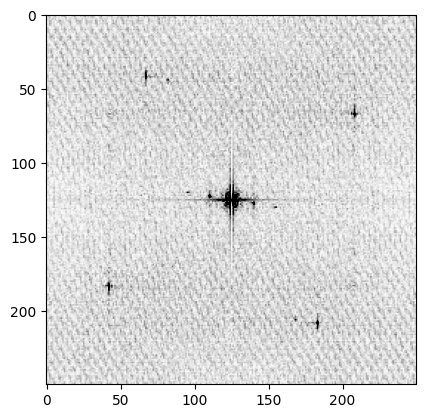

In [10]:
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+4*s2])

## reconstruction then drift correction
### reconstruction

1.0000000061035157


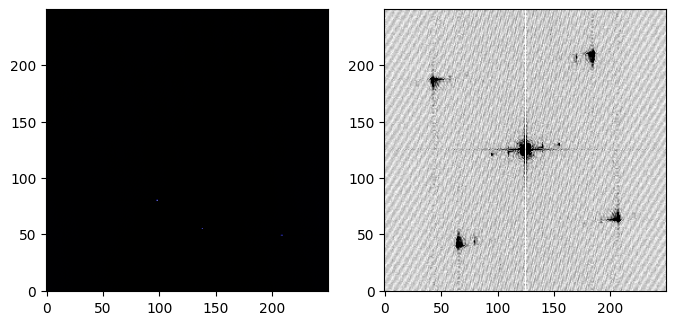

In [11]:
dfc.display(t.z)

getcontext().prec = 28  # Set the precision you need

decimal_arr = [Decimal(str(x)) for x in t.z.flatten()]
average = sum(decimal_arr) / Decimal(len(decimal_arr))
result = [x / average for x in decimal_arr]
result_arr = np.array(result, dtype=float).reshape(t.z.shape)
print(mean(result_arr))
nx, ny = shape(t.z)
b = result_arr.T.flat[ri] # using same ri defined above!

In [12]:
testsparse = zeros_like(t.Z)
Xat2 = owlqn(nx*ny, evaluate, None, 1)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

Iteration 1:
  fx = 2381361498245383086669824.000000, xnorm = 250.003596, gnorm = 3086332126161.898926, step = 0.000000, k = 1, ls = 1

Iteration 2:
  fx = 627546820205187080126464.000000, xnorm = 1170570859996.229492, gnorm = 1584357055629.918457, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 1974107067409672175616.000000, xnorm = 1765614641135.502686, gnorm = 88861842977.051422, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 1398648098931570176.000000, xnorm = 1758602596021.354736, gnorm = 2365049878.083645, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 317973779870541.187500, xnorm = 1758618064436.961182, gnorm = 11850014.887230, step = 1.000000, k = 5, ls = 1



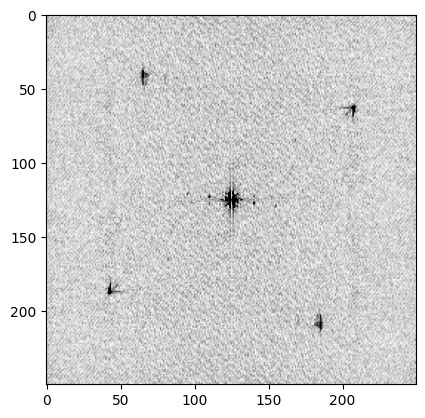

In [13]:
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+5*s2])

The coordinates of the Bragg peaks are:
array([[ 43, 187],
       [207,  63],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[-81,  63],
       [ 83, -61],
       [-59, -84],
       [ 61,  86]])


array([[ 43, 187],
       [207,  63],
       [ 65,  40],
       [185, 210]])

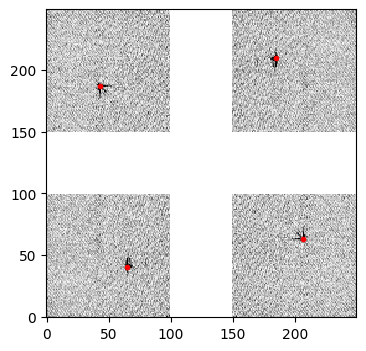

In [14]:
# Find parameters to find Bragg peaks
dfc.findBraggs(testsparse, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[ 43, 187],
       [207,  63],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[-81,  63],
       [ 83, -61],
       [-59, -84],
       [ 61,  86]])


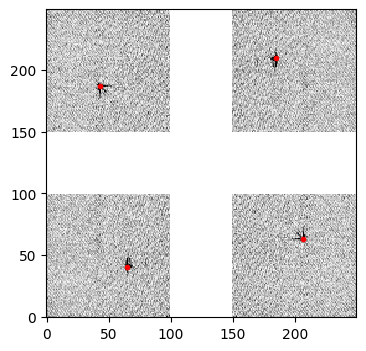

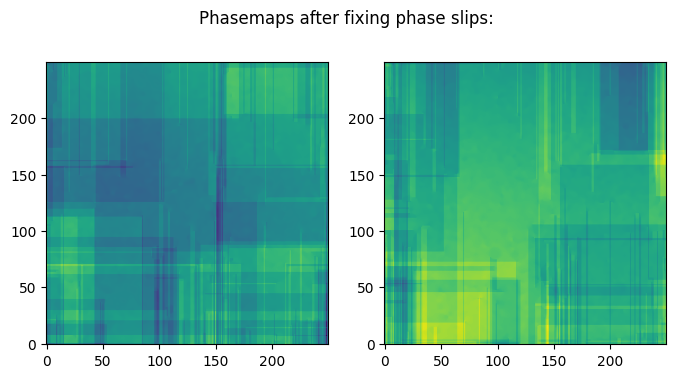

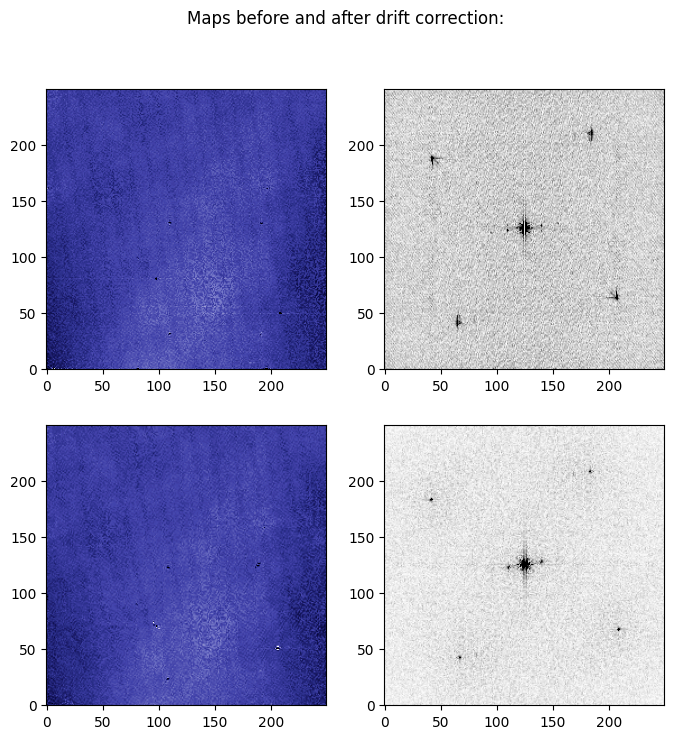

In [15]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(testsparse, w=0.1, sigma=20, show=True, method='lockin')

## 65 nm

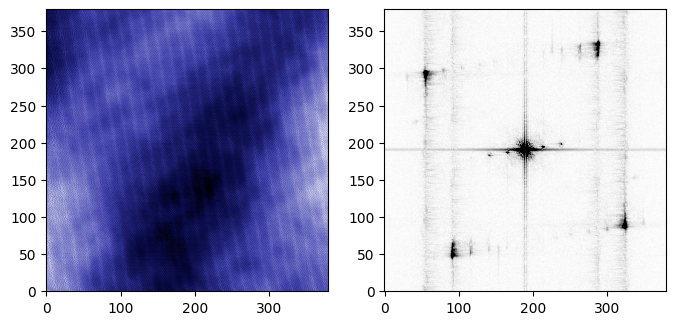

In [16]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo002.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)
dfc.display(t.z)

# part 1
## (drift correct then reconstruction)

In [ ]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, sigma=20, show=True, method='lockin')

original_mean = mean(t.z_c)
test = standardize(t.z_c)
#c2 = mean(t.z_c)
#s2 = std(t.z_c)
#imshow(t.z_c,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])
nx, ny = shape(t.z_c)

# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])

# part 2
## (reconstruction then drift correction)

In [ ]:
dfc.display(t.z)

getcontext().prec = 28  # Set the precision you need

decimal_arr = [Decimal(str(x)) for x in t.z.flatten()]
average = sum(decimal_arr) / Decimal(len(decimal_arr))
result = [x / average for x in decimal_arr]
result_arr = np.array(result, dtype=float).reshape(t.z.shape)
print(mean(result_arr))
nx, ny = shape(t.Z)
b = result_arr.T.flat[ri] #using the same ri values defined above

testsparse = zeros_like(t.Z)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+5*s2])

# Find parameters to find Bragg peaks
dfc.findBraggs(testsparse, w=0.1, show=True)

# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(testsparse, w=0.1, sigma=20, show=True, method='lockin')

# Now using LIY
## Part 1: drift correction then reconstruction

In [17]:
#### Load the dos map file
d1 = stmpy.load("Grid Spectroscopy-BSCCO-2022-09-04-002.3ds")
d1.z = stmpy.tools.lineSubtract(d1.Z, 2)

File import successful.
Corrected for a bias offset of -1.56 meV


The coordinates of the Bragg peaks are:
array([[207,  60],
       [ 43, 190],
       [ 66,  51],
       [184, 199]])

The coordinates of the Q vectors are:
array([[ 83, -64],
       [-81,  66],
       [-58, -73],
       [ 60,  75]])
The coordinates of the Bragg peaks are:
array([[ 47, 185],
       [203,  65],
       [185, 203],
       [ 65,  47]])

The coordinates of the Q vectors are:
array([[-77,  61],
       [ 79, -59],
       [ 61,  79],
       [-59, -77]])


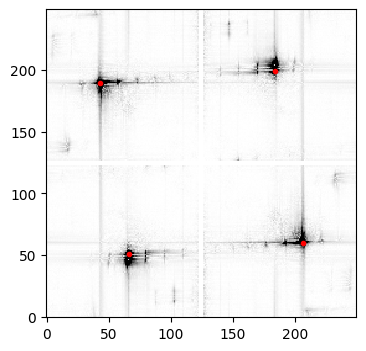

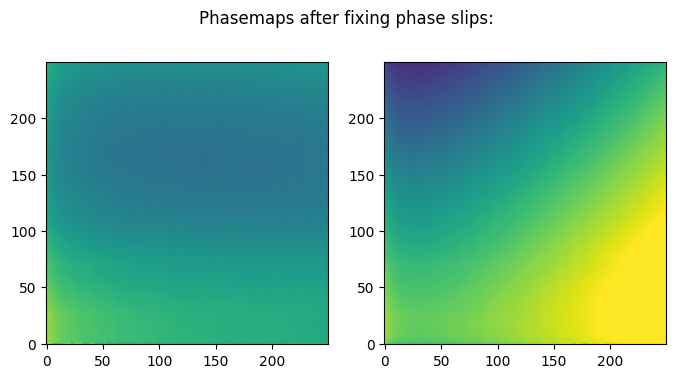

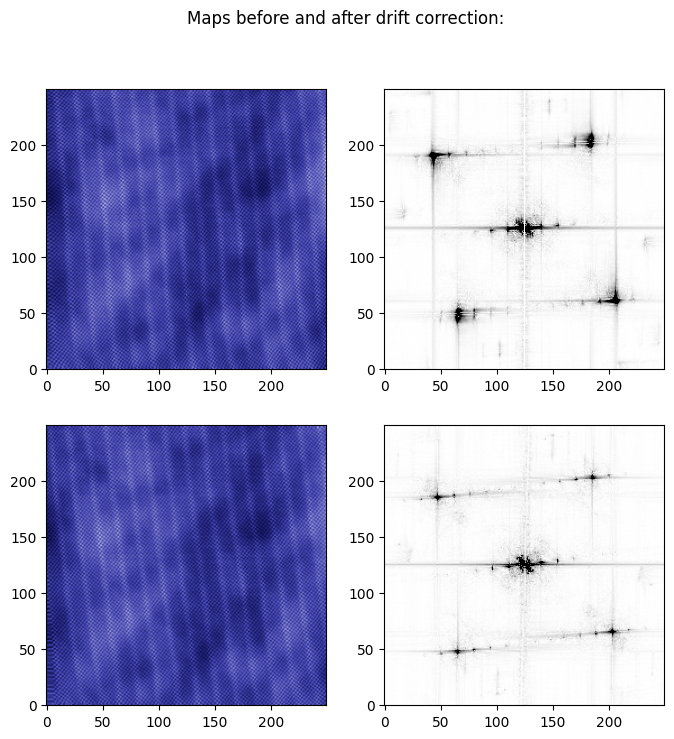

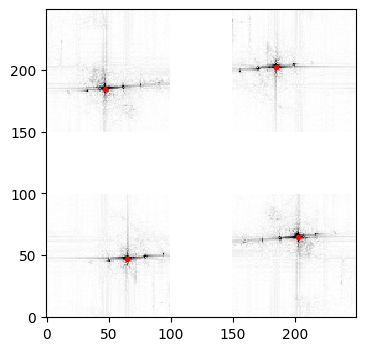

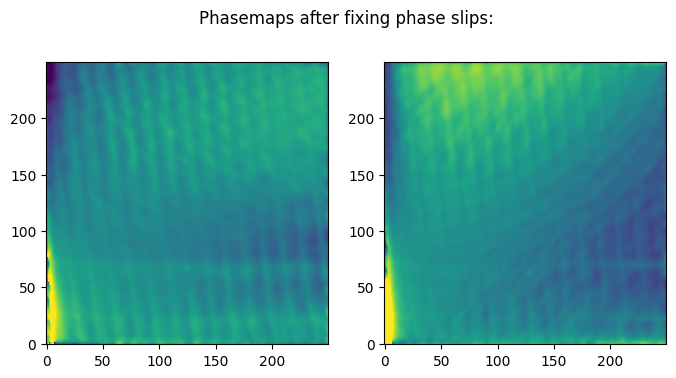

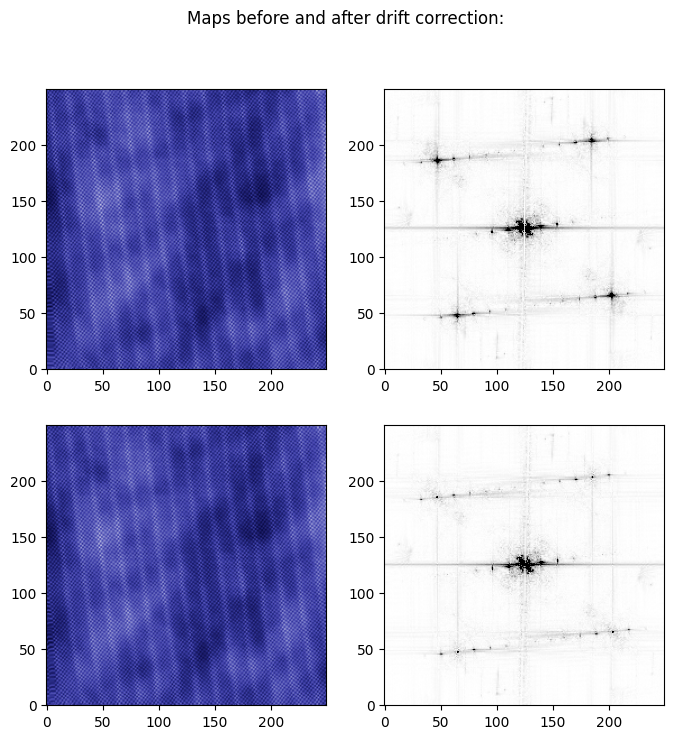

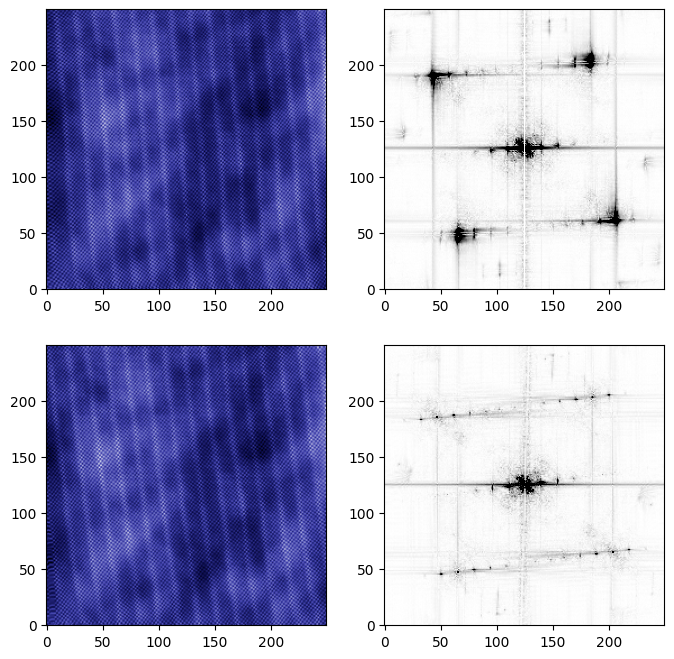

In [18]:
# take a look at the map
liy_topo = copy(d1.z)
bp1 = dfc.findBraggs(liy_topo, min_dist=10, r=0.2, w=0.01, show=True)
bp_c = dfc.generate_bp(liy_topo, bp=bp1, orient=arctan2(-64, 83), even_out=True)
z_c1, param1 = dfc.find_drift_parameter(liy_topo, r=0.2, w=0.1, min_dist=10, bp_c=bp_c, #cut2=5, 
                                      sigma=20, method='lockin')
#DO WE WANT TO DRIFT CORRECT TWICE?
bp2 = dfc.findBraggs(z_c1, rspace=True, r=0.2, w=0.1, min_dist=20, show=True)
bp_c2 = dfc.generate_bp(z_c1, bp=bp2, orient=arctan2(-59, 79), even_out=True)
z_c2, param2 = dfc.find_drift_parameter(z_c1, r=0.2, w=0.1, min_dist=10, bp_c=bp_c, 
                                      sigma=20, method='lockin')
dfc.display(d1.z, z_c2)

In [19]:
original_mean = mean(z_c2)
print(original_mean)
test = standardize(z_c2)
print(mean(test))

2.0596741677950418e-14
0.9999999999999999


Iteration 1:
  fx = 1493002288.377739, xnorm = 250.001196, gnorm = 77278.674434, step = 0.000013, k = 1, ls = 1

Iteration 2:
  fx = 609163905.923598, xnorm = 27414.488608, gnorm = 49345.590369, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 4400486.684507, xnorm = 41020.324237, gnorm = 3982.378779, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 438958.675336, xnorm = 40826.272964, gnorm = 127.364768, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 434867.059105, xnorm = 40824.384685, gnorm = 11.717810, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 434797.372041, xnorm = 40823.669857, gnorm = 11.732508, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 434624.046572, xnorm = 40691.342576, gnorm = 239.178149, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 425328.855440, xnorm = 40710.967286, gnorm = 164.072598, step = 0.500000, k = 8, ls = 2

Iteration 9:
  fx = 424211.198199, xnorm = 40638.143279, gnorm = 169.681125, step = 0.250000, k = 9, ls = 3

Iteration 

Iteration 76:
  fx = 392303.838136, xnorm = 40573.439616, gnorm = 46.256318, step = 0.500000, k = 76, ls = 2

Iteration 77:
  fx = 391658.434674, xnorm = 40559.770108, gnorm = 24.647041, step = 0.500000, k = 77, ls = 2

Iteration 78:
  fx = 391552.761755, xnorm = 40573.116450, gnorm = 46.304713, step = 0.500000, k = 78, ls = 2

Iteration 79:
  fx = 390905.714188, xnorm = 40559.344132, gnorm = 24.383987, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 390801.996233, xnorm = 40572.651735, gnorm = 46.187063, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 390158.673141, xnorm = 40559.018647, gnorm = 24.188979, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 390051.894431, xnorm = 40572.279765, gnorm = 46.005380, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 389418.845044, xnorm = 40558.634163, gnorm = 24.713642, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 389304.004828, xnorm = 40572.322841, gnorm = 46.006323, step = 0.500000, k = 84, ls = 2

Iteration 

Iteration 156:
  fx = 363652.162112, xnorm = 40644.165544, gnorm = 44.143128, step = 0.500000, k = 156, ls = 2

Iteration 157:
  fx = 363070.212339, xnorm = 40630.374213, gnorm = 23.067629, step = 0.500000, k = 157, ls = 2

Iteration 158:
  fx = 362979.050264, xnorm = 40648.059257, gnorm = 44.150491, step = 0.500000, k = 158, ls = 2

Iteration 159:
  fx = 362396.416244, xnorm = 40634.357256, gnorm = 22.845798, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 362302.793018, xnorm = 40651.874920, gnorm = 43.869258, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 361729.751957, xnorm = 40638.313700, gnorm = 23.030625, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 361627.833886, xnorm = 40655.822599, gnorm = 43.535503, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 361067.284834, xnorm = 40642.187025, gnorm = 23.557288, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 360962.789973, xnorm = 40660.130585, gnorm = 43.607084, step = 0.500000, k = 164, 

Iteration 235:
  fx = 338296.300118, xnorm = 40845.218218, gnorm = 21.471630, step = 0.500000, k = 235, ls = 2

Iteration 236:
  fx = 338209.437575, xnorm = 40864.447212, gnorm = 41.326340, step = 0.500000, k = 236, ls = 2

Iteration 237:
  fx = 337702.869510, xnorm = 40852.029010, gnorm = 22.009086, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 337610.190070, xnorm = 40871.645242, gnorm = 41.239499, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 337105.875882, xnorm = 40859.056053, gnorm = 22.257057, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 337018.948199, xnorm = 40878.991463, gnorm = 41.549568, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 336502.114988, xnorm = 40866.419807, gnorm = 21.691419, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 336425.038236, xnorm = 40886.242947, gnorm = 41.621277, step = 0.500000, k = 242, ls = 2

Iteration 243:
  fx = 335902.927636, xnorm = 40873.874033, gnorm = 21.045535, step = 0.500000, k = 243, 

Iteration 315:
  fx = 315584.850793, xnorm = 41176.176381, gnorm = 20.948662, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 315505.509220, xnorm = 41197.126252, gnorm = 39.185009, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 315045.076178, xnorm = 41185.748221, gnorm = 20.635387, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 314971.756040, xnorm = 41206.696183, gnorm = 39.258612, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 314507.835821, xnorm = 41195.364234, gnorm = 20.313348, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 314435.413339, xnorm = 41216.163843, gnorm = 39.072108, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 313976.661266, xnorm = 41204.893132, gnorm = 20.375409, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 313899.888317, xnorm = 41225.716883, gnorm = 38.848841, step = 0.500000, k = 322, ls = 2

Iteration 323:
  fx = 313449.269732, xnorm = 41214.391733, gnorm = 20.712843, step = 0.500000, k = 323, 

Iteration 393:
  fx = 295841.164941, xnorm = 41581.100317, gnorm = 19.758262, step = 0.500000, k = 393, ls = 2

Iteration 394:
  fx = 295771.465607, xnorm = 41602.756492, gnorm = 37.026681, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 295358.087868, xnorm = 41592.480930, gnorm = 19.403491, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 295290.850789, xnorm = 41613.975211, gnorm = 36.923665, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 294880.138409, xnorm = 41603.765633, gnorm = 19.384736, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 294811.632190, xnorm = 41625.246879, gnorm = 36.779221, step = 0.500000, k = 398, ls = 2

Iteration 399:
  fx = 294404.718389, xnorm = 41615.087049, gnorm = 19.403309, step = 0.500000, k = 399, ls = 2

Iteration 400:
  fx = 294334.047365, xnorm = 41636.551879, gnorm = 36.644402, step = 0.500000, k = 400, ls = 2

Iteration 401:
  fx = 293931.261175, xnorm = 41626.412045, gnorm = 19.535725, step = 0.500000, k = 401, 

Iteration 471:
  fx = 277998.354066, xnorm = 42049.840470, gnorm = 18.810123, step = 0.500000, k = 471, ls = 2

Iteration 472:
  fx = 277934.428343, xnorm = 42071.953972, gnorm = 35.087064, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 277561.672434, xnorm = 42062.643436, gnorm = 18.594247, step = 0.500000, k = 473, ls = 2

Iteration 474:
  fx = 277497.598849, xnorm = 42084.629130, gnorm = 34.943418, step = 0.500000, k = 474, ls = 2

Iteration 475:
  fx = 277128.693986, xnorm = 42075.392711, gnorm = 18.583179, step = 0.500000, k = 475, ls = 2

Iteration 476:
  fx = 277063.880979, xnorm = 42097.337193, gnorm = 34.785591, step = 0.500000, k = 476, ls = 2

Iteration 477:
  fx = 276698.417320, xnorm = 42088.098653, gnorm = 18.701848, step = 0.500000, k = 477, ls = 2

Iteration 478:
  fx = 276634.073630, xnorm = 42110.142787, gnorm = 34.773094, step = 0.500000, k = 478, ls = 2

Iteration 479:
  fx = 276268.317381, xnorm = 42100.929504, gnorm = 18.596543, step = 0.500000, k = 479, 

Iteration 549:
  fx = 261841.647633, xnorm = 42567.998184, gnorm = 17.662805, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 261781.858615, xnorm = 42590.092310, gnorm = 33.294816, step = 0.500000, k = 550, ls = 2

Iteration 551:
  fx = 261447.930095, xnorm = 42581.783089, gnorm = 17.904992, step = 0.500000, k = 551, ls = 2

Iteration 552:
  fx = 261387.555938, xnorm = 42604.061906, gnorm = 33.371856, step = 0.500000, k = 552, ls = 2

Iteration 553:
  fx = 261051.436650, xnorm = 42595.722096, gnorm = 17.880809, step = 0.500000, k = 553, ls = 2

Iteration 554:
  fx = 260992.290978, xnorm = 42618.090316, gnorm = 33.411833, step = 0.500000, k = 554, ls = 2

Iteration 555:
  fx = 260654.715295, xnorm = 42609.789467, gnorm = 17.712817, step = 0.500000, k = 555, ls = 2

Iteration 556:
  fx = 260597.122720, xnorm = 42632.021537, gnorm = 33.337456, step = 0.500000, k = 556, ls = 2

Iteration 557:
  fx = 260260.459118, xnorm = 42623.810733, gnorm = 17.536209, step = 0.500000, k = 557, 

Iteration 626:
  fx = 247408.712555, xnorm = 43132.005484, gnorm = 31.842698, step = 0.500000, k = 626, ls = 2

Iteration 627:
  fx = 247101.050973, xnorm = 43124.586750, gnorm = 16.882281, step = 0.500000, k = 627, ls = 2

Iteration 628:
  fx = 247048.009019, xnorm = 43146.603131, gnorm = 31.782863, step = 0.500000, k = 628, ls = 2

Iteration 629:
  fx = 246742.358710, xnorm = 43139.206699, gnorm = 16.947418, step = 0.500000, k = 629, ls = 2

Iteration 630:
  fx = 246689.059415, xnorm = 43161.286104, gnorm = 31.783413, step = 0.500000, k = 630, ls = 2

Iteration 631:
  fx = 246383.098758, xnorm = 43153.894310, gnorm = 16.934643, step = 0.500000, k = 631, ls = 2

Iteration 632:
  fx = 246327.477673, xnorm = 43175.910380, gnorm = 31.610221, step = 0.500000, k = 632, ls = 2

Iteration 633:
  fx = 246025.330572, xnorm = 43168.541290, gnorm = 17.050112, step = 0.500000, k = 633, ls = 2

Iteration 634:
  fx = 245969.267191, xnorm = 43190.610182, gnorm = 31.580342, step = 0.500000, k = 634, 

Iteration 703:
  fx = 234008.313864, xnorm = 43693.550598, gnorm = 15.940998, step = 0.500000, k = 703, ls = 2

Iteration 704:
  fx = 233961.855059, xnorm = 43715.369570, gnorm = 30.407528, step = 0.500000, k = 704, ls = 2

Iteration 705:
  fx = 233681.073486, xnorm = 43708.753223, gnorm = 16.163566, step = 0.500000, k = 705, ls = 2

Iteration 706:
  fx = 233631.326372, xnorm = 43730.597590, gnorm = 30.300736, step = 0.500000, k = 706, ls = 2

Iteration 707:
  fx = 233353.143782, xnorm = 43724.009088, gnorm = 16.323158, step = 0.500000, k = 707, ls = 2

Iteration 708:
  fx = 233303.642475, xnorm = 43746.014072, gnorm = 30.355976, step = 0.500000, k = 708, ls = 2

Iteration 709:
  fx = 233023.529122, xnorm = 43739.435256, gnorm = 16.095456, step = 0.500000, k = 709, ls = 2

Iteration 710:
  fx = 232976.526700, xnorm = 43761.330946, gnorm = 30.341667, step = 0.500000, k = 710, ls = 2

Iteration 711:
  fx = 232695.778927, xnorm = 43754.796233, gnorm = 15.964582, step = 0.500000, k = 711, 

Iteration 779:
  fx = 222075.590522, xnorm = 44280.704863, gnorm = 15.443093, step = 0.500000, k = 779, ls = 2

Iteration 780:
  fx = 222029.902575, xnorm = 44302.222275, gnorm = 28.871789, step = 0.500000, k = 780, ls = 2

Iteration 781:
  fx = 221776.012675, xnorm = 44296.322485, gnorm = 15.553169, step = 0.500000, k = 781, ls = 2

Iteration 782:
  fx = 221730.076494, xnorm = 44317.827952, gnorm = 28.841739, step = 0.500000, k = 782, ls = 2

Iteration 783:
  fx = 221476.502078, xnorm = 44311.965793, gnorm = 15.542515, step = 0.500000, k = 783, ls = 2

Iteration 784:
  fx = 221431.342818, xnorm = 44333.411858, gnorm = 28.818193, step = 0.500000, k = 784, ls = 2

Iteration 785:
  fx = 221177.524236, xnorm = 44327.611063, gnorm = 15.409356, step = 0.500000, k = 785, ls = 2

Iteration 786:
  fx = 221133.424251, xnorm = 44348.977262, gnorm = 28.773693, step = 0.500000, k = 786, ls = 2

Iteration 787:
  fx = 220880.149583, xnorm = 44343.238765, gnorm = 15.330700, step = 0.500000, k = 787, 

Iteration 856:
  fx = 211158.960912, xnorm = 44898.513980, gnorm = 27.638832, step = 0.500000, k = 856, ls = 2

Iteration 857:
  fx = 210924.862751, xnorm = 44893.429757, gnorm = 14.602032, step = 0.500000, k = 857, ls = 2

Iteration 858:
  fx = 210884.729684, xnorm = 44914.335713, gnorm = 27.568286, step = 0.500000, k = 858, ls = 2

Iteration 859:
  fx = 210652.781850, xnorm = 44909.253023, gnorm = 14.726369, step = 0.500000, k = 859, ls = 2

Iteration 860:
  fx = 210612.232661, xnorm = 44930.224304, gnorm = 27.579125, step = 0.500000, k = 860, ls = 2

Iteration 861:
  fx = 210379.694753, xnorm = 44925.154093, gnorm = 14.627896, step = 0.500000, k = 861, ls = 2

Iteration 862:
  fx = 210340.429333, xnorm = 44946.130597, gnorm = 27.585645, step = 0.500000, k = 862, ls = 2

Iteration 863:
  fx = 210107.580225, xnorm = 44941.073921, gnorm = 14.571321, step = 0.500000, k = 863, ls = 2

Iteration 864:
  fx = 210067.379339, xnorm = 44961.956955, gnorm = 27.486508, step = 0.500000, k = 864, 

Iteration 933:
  fx = 200953.850703, xnorm = 45499.979567, gnorm = 13.925119, step = 0.500000, k = 933, ls = 2

Iteration 934:
  fx = 200917.449142, xnorm = 45520.345679, gnorm = 26.434658, step = 0.500000, k = 934, ls = 2

Iteration 935:
  fx = 200704.082154, xnorm = 45515.916943, gnorm = 14.141085, step = 0.500000, k = 935, ls = 2

Iteration 936:
  fx = 200665.339254, xnorm = 45536.414581, gnorm = 26.384718, step = 0.500000, k = 936, ls = 2

Iteration 937:
  fx = 200453.269322, xnorm = 45531.967714, gnorm = 14.283032, step = 0.500000, k = 937, ls = 2

Iteration 938:
  fx = 200416.466598, xnorm = 45552.570319, gnorm = 26.539124, step = 0.500000, k = 938, ls = 2

Iteration 939:
  fx = 200200.445275, xnorm = 45548.132405, gnorm = 14.064569, step = 0.500000, k = 939, ls = 2

Iteration 940:
  fx = 200165.728226, xnorm = 45568.622021, gnorm = 26.531095, step = 0.500000, k = 940, ls = 2

Iteration 941:
  fx = 199949.116138, xnorm = 45564.255324, gnorm = 13.795735, step = 0.500000, k = 941, 

Iteration 1008:
  fx = 191983.907498, xnorm = 46114.891827, gnorm = 25.253219, step = 0.500000, k = 1008, ls = 2

Iteration 1009:
  fx = 191787.947259, xnorm = 46111.088634, gnorm = 13.302331, step = 0.500000, k = 1009, ls = 2

Iteration 1010:
  fx = 191753.634877, xnorm = 46130.825633, gnorm = 25.134477, step = 0.500000, k = 1010, ls = 2

Iteration 1011:
  fx = 191560.375600, xnorm = 46127.032083, gnorm = 13.489349, step = 0.500000, k = 1011, ls = 2

Iteration 1012:
  fx = 191524.344062, xnorm = 46146.826452, gnorm = 25.102824, step = 0.500000, k = 1012, ls = 2

Iteration 1013:
  fx = 191332.402471, xnorm = 46143.008530, gnorm = 13.654721, step = 0.500000, k = 1013, ls = 2

Iteration 1014:
  fx = 191296.622414, xnorm = 46162.922783, gnorm = 25.187174, step = 0.500000, k = 1014, ls = 2

Iteration 1015:
  fx = 191102.582728, xnorm = 46159.110147, gnorm = 13.483545, step = 0.500000, k = 1015, ls = 2

Iteration 1016:
  fx = 191069.381049, xnorm = 46179.014808, gnorm = 25.260376, step = 0.

Iteration 1083:
  fx = 183652.857263, xnorm = 46701.806515, gnorm = 12.685520, step = 0.500000, k = 1083, ls = 2

Iteration 1084:
  fx = 183624.401849, xnorm = 46720.931992, gnorm = 24.161215, step = 0.500000, k = 1084, ls = 2

Iteration 1085:
  fx = 183444.549337, xnorm = 46717.613481, gnorm = 12.714807, step = 0.500000, k = 1085, ls = 2

Iteration 1086:
  fx = 183413.463590, xnorm = 46736.680320, gnorm = 23.970668, step = 0.500000, k = 1086, ls = 2

Iteration 1087:
  fx = 183237.311883, xnorm = 46733.381778, gnorm = 12.852289, step = 0.500000, k = 1087, ls = 2

Iteration 1088:
  fx = 183204.475930, xnorm = 46752.493754, gnorm = 23.899991, step = 0.500000, k = 1088, ls = 2

Iteration 1089:
  fx = 183030.016548, xnorm = 46749.188153, gnorm = 12.981647, step = 0.500000, k = 1089, ls = 2

Iteration 1090:
  fx = 182997.223516, xnorm = 46768.396544, gnorm = 23.913293, step = 0.500000, k = 1090, ls = 2

Iteration 1091:
  fx = 182821.770611, xnorm = 46765.076812, gnorm = 12.902346, step = 0.

Iteration 1159:
  fx = 176119.400626, xnorm = 47297.188076, gnorm = 12.072350, step = 0.500000, k = 1159, ls = 2

Iteration 1160:
  fx = 176091.681682, xnorm = 47315.327612, gnorm = 22.733588, step = 0.500000, k = 1160, ls = 2

Iteration 1161:
  fx = 175933.065759, xnorm = 47312.538258, gnorm = 12.248800, step = 0.500000, k = 1161, ls = 2

Iteration 1162:
  fx = 175903.738333, xnorm = 47330.765364, gnorm = 22.681356, step = 0.500000, k = 1162, ls = 2

Iteration 1163:
  fx = 175746.016094, xnorm = 47327.968119, gnorm = 12.286756, step = 0.500000, k = 1163, ls = 2

Iteration 1164:
  fx = 175716.023862, xnorm = 47346.199492, gnorm = 22.643084, step = 0.500000, k = 1164, ls = 2

Iteration 1165:
  fx = 175558.600316, xnorm = 47343.431224, gnorm = 12.213514, step = 0.500000, k = 1165, ls = 2

Iteration 1166:
  fx = 175529.677240, xnorm = 47361.589149, gnorm = 22.647530, step = 0.500000, k = 1166, ls = 2

Iteration 1167:
  fx = 175372.125269, xnorm = 47358.855646, gnorm = 12.136723, step = 0.

Iteration 1235:
  fx = 169357.702949, xnorm = 47874.249599, gnorm = 11.748314, step = 0.500000, k = 1235, ls = 2

Iteration 1236:
  fx = 169330.307850, xnorm = 47891.632682, gnorm = 21.523736, step = 0.500000, k = 1236, ls = 2

Iteration 1237:
  fx = 169187.859770, xnorm = 47889.292846, gnorm = 11.626442, step = 0.500000, k = 1237, ls = 2

Iteration 1238:
  fx = 169162.067320, xnorm = 47906.636117, gnorm = 21.558174, step = 0.500000, k = 1238, ls = 2

Iteration 1239:
  fx = 169018.702153, xnorm = 47904.306667, gnorm = 11.513544, step = 0.500000, k = 1239, ls = 2

Iteration 1240:
  fx = 168993.119506, xnorm = 47921.569591, gnorm = 21.477024, step = 0.500000, k = 1240, ls = 2

Iteration 1241:
  fx = 168850.738251, xnorm = 47919.256136, gnorm = 11.470940, step = 0.500000, k = 1241, ls = 2

Iteration 1242:
  fx = 168825.579207, xnorm = 47936.484963, gnorm = 21.462304, step = 0.500000, k = 1242, ls = 2

Iteration 1243:
  fx = 168683.713425, xnorm = 47934.160105, gnorm = 11.563545, step = 0.

Iteration 1311:
  fx = 163291.659273, xnorm = 48432.739785, gnorm = 11.102478, step = 0.500000, k = 1311, ls = 2

Iteration 1312:
  fx = 163266.630326, xnorm = 48448.983152, gnorm = 20.043642, step = 0.500000, k = 1312, ls = 2

Iteration 1313:
  fx = 163142.912159, xnorm = 48447.008619, gnorm = 11.054274, step = 0.500000, k = 1313, ls = 2

Iteration 1314:
  fx = 163118.996082, xnorm = 48463.236287, gnorm = 20.070852, step = 0.500000, k = 1314, ls = 2

Iteration 1315:
  fx = 162994.155368, xnorm = 48461.262919, gnorm = 10.843599, step = 0.500000, k = 1315, ls = 2

Iteration 1316:
  fx = 162972.195543, xnorm = 48477.379402, gnorm = 20.079804, step = 0.500000, k = 1316, ls = 2

Iteration 1317:
  fx = 162846.846131, xnorm = 48475.419366, gnorm = 10.729411, step = 0.500000, k = 1317, ls = 2

Iteration 1318:
  fx = 162824.834758, xnorm = 48491.422603, gnorm = 19.979761, step = 0.500000, k = 1318, ls = 2

Iteration 1319:
  fx = 162700.897484, xnorm = 48489.475624, gnorm = 10.777428, step = 0.

Iteration 1387:
  fx = 157975.181034, xnorm = 48960.346069, gnorm = 10.345474, step = 0.500000, k = 1387, ls = 2

Iteration 1388:
  fx = 157954.123284, xnorm = 48975.576662, gnorm = 18.957441, step = 0.500000, k = 1388, ls = 2

Iteration 1389:
  fx = 157842.931269, xnorm = 48973.961533, gnorm = 10.315785, step = 0.500000, k = 1389, ls = 2

Iteration 1390:
  fx = 157822.039630, xnorm = 48989.147320, gnorm = 18.935128, step = 0.500000, k = 1390, ls = 2

Iteration 1391:
  fx = 157710.739566, xnorm = 48987.552624, gnorm = 10.205373, step = 0.500000, k = 1391, ls = 2

Iteration 1392:
  fx = 157691.037494, xnorm = 49002.694574, gnorm = 18.959838, step = 0.500000, k = 1392, ls = 2

Iteration 1393:
  fx = 157579.155804, xnorm = 49001.106678, gnorm = 10.138459, step = 0.500000, k = 1393, ls = 2

Iteration 1394:
  fx = 157558.834648, xnorm = 49016.193279, gnorm = 18.837534, step = 0.500000, k = 1394, ls = 2

Iteration 1395:
  fx = 157449.027721, xnorm = 49014.605385, gnorm = 10.279848, step = 0.

Iteration 1463:
  fx = 153270.857644, xnorm = 49462.191287, gnorm = 9.766820, step = 0.500000, k = 1463, ls = 2

Iteration 1464:
  fx = 153251.681287, xnorm = 49476.304953, gnorm = 17.614647, step = 0.500000, k = 1464, ls = 2

Iteration 1465:
  fx = 153155.175452, xnorm = 49474.996471, gnorm = 9.660821, step = 0.500000, k = 1465, ls = 2

Iteration 1466:
  fx = 153137.095439, xnorm = 49489.059032, gnorm = 17.629160, step = 0.500000, k = 1466, ls = 2

Iteration 1467:
  fx = 153039.952588, xnorm = 49487.764895, gnorm = 9.462990, step = 0.500000, k = 1467, ls = 2

Iteration 1468:
  fx = 153022.158825, xnorm = 49501.708904, gnorm = 17.527796, step = 0.500000, k = 1468, ls = 2

Iteration 1469:
  fx = 152926.417382, xnorm = 49500.422840, gnorm = 9.501682, step = 0.500000, k = 1469, ls = 2

Iteration 1470:
  fx = 152906.940110, xnorm = 49514.333417, gnorm = 17.364631, step = 0.500000, k = 1470, ls = 2

Iteration 1471:
  fx = 152813.788736, xnorm = 49513.053006, gnorm = 9.752891, step = 0.50000

Iteration 1539:
  fx = 149188.910261, xnorm = 49930.545301, gnorm = 9.072010, step = 0.500000, k = 1539, ls = 2

Iteration 1540:
  fx = 149171.056819, xnorm = 49943.475963, gnorm = 16.206113, step = 0.500000, k = 1540, ls = 2

Iteration 1541:
  fx = 149089.602882, xnorm = 49942.417938, gnorm = 9.100931, step = 0.500000, k = 1541, ls = 2

Iteration 1542:
  fx = 149072.690830, xnorm = 49955.378900, gnorm = 16.282339, step = 0.500000, k = 1542, ls = 2

Iteration 1543:
  fx = 148989.932499, xnorm = 49954.325286, gnorm = 8.982941, step = 0.500000, k = 1543, ls = 2

Iteration 1544:
  fx = 148973.966024, xnorm = 49967.204914, gnorm = 16.283078, step = 0.500000, k = 1544, ls = 2

Iteration 1545:
  fx = 148890.920404, xnorm = 49966.181348, gnorm = 8.807767, step = 0.500000, k = 1545, ls = 2

Iteration 1546:
  fx = 148874.672286, xnorm = 49978.943029, gnorm = 16.147113, step = 0.500000, k = 1546, ls = 2

Iteration 1547:
  fx = 148793.404609, xnorm = 49977.929692, gnorm = 8.881579, step = 0.50000

Iteration 1615:
  fx = 145706.158591, xnorm = 50362.841582, gnorm = 8.533488, step = 0.500000, k = 1615, ls = 2

Iteration 1616:
  fx = 145689.373375, xnorm = 50374.522303, gnorm = 14.681926, step = 0.500000, k = 1616, ls = 2

Iteration 1617:
  fx = 145622.385524, xnorm = 50373.670323, gnorm = 8.566088, step = 0.500000, k = 1617, ls = 2

Iteration 1618:
  fx = 145606.285237, xnorm = 50385.388343, gnorm = 14.738636, step = 0.500000, k = 1618, ls = 2

Iteration 1619:
  fx = 145538.317277, xnorm = 50384.533145, gnorm = 8.412186, step = 0.500000, k = 1619, ls = 2

Iteration 1620:
  fx = 145523.416596, xnorm = 50396.173700, gnorm = 14.774963, step = 0.500000, k = 1620, ls = 2

Iteration 1621:
  fx = 145454.633418, xnorm = 50395.337205, gnorm = 8.206275, step = 0.500000, k = 1621, ls = 2

Iteration 1622:
  fx = 145440.549182, xnorm = 50406.869051, gnorm = 14.705169, step = 0.500000, k = 1622, ls = 2

Iteration 1623:
  fx = 145372.313018, xnorm = 50406.039029, gnorm = 8.182550, step = 0.50000

Iteration 1690:
  fx = 142826.050855, xnorm = 50756.627416, gnorm = 13.521066, step = 0.500000, k = 1690, ls = 2

Iteration 1691:
  fx = 142768.253066, xnorm = 50755.989706, gnorm = 7.750967, step = 0.500000, k = 1691, ls = 2

Iteration 1692:
  fx = 142755.267219, xnorm = 50766.417581, gnorm = 13.486127, step = 0.500000, k = 1692, ls = 2

Iteration 1693:
  fx = 142697.827018, xnorm = 50765.779415, gnorm = 7.738375, step = 0.500000, k = 1693, ls = 2

Iteration 1694:
  fx = 142684.899638, xnorm = 50776.156293, gnorm = 13.432726, step = 0.500000, k = 1694, ls = 2

Iteration 1695:
  fx = 142627.762261, xnorm = 50775.531871, gnorm = 7.673263, step = 0.500000, k = 1695, ls = 2

Iteration 1696:
  fx = 142614.724957, xnorm = 50785.842658, gnorm = 13.362561, step = 0.500000, k = 1696, ls = 2

Iteration 1697:
  fx = 142558.385073, xnorm = 50785.229120, gnorm = 7.712100, step = 0.500000, k = 1697, ls = 2

Iteration 1698:
  fx = 142545.165806, xnorm = 50795.504387, gnorm = 13.285950, step = 0.5000

Iteration 1766:
  fx = 140365.582668, xnorm = 51109.667183, gnorm = 12.173114, step = 0.500000, k = 1766, ls = 2

Iteration 1767:
  fx = 140319.188021, xnorm = 51109.183649, gnorm = 7.278467, step = 0.500000, k = 1767, ls = 2

Iteration 1768:
  fx = 140307.157282, xnorm = 51118.523584, gnorm = 12.232329, step = 0.500000, k = 1768, ls = 2

Iteration 1769:
  fx = 140259.959104, xnorm = 51118.039310, gnorm = 7.147244, step = 0.500000, k = 1769, ls = 2

Iteration 1770:
  fx = 140248.481119, xnorm = 51127.322813, gnorm = 12.195745, step = 0.500000, k = 1770, ls = 2

Iteration 1771:
  fx = 140201.276243, xnorm = 51126.846399, gnorm = 7.029578, step = 0.500000, k = 1771, ls = 2

Iteration 1772:
  fx = 140190.256812, xnorm = 51136.030538, gnorm = 12.144363, step = 0.500000, k = 1772, ls = 2

Iteration 1773:
  fx = 140143.504359, xnorm = 51135.559871, gnorm = 7.001160, step = 0.500000, k = 1773, ls = 2

Iteration 1774:
  fx = 140132.235055, xnorm = 51144.672921, gnorm = 12.032458, step = 0.5000

Iteration 1841:
  fx = 138338.740988, xnorm = 51417.126217, gnorm = 6.534922, step = 0.500000, k = 1841, ls = 2

Iteration 1842:
  fx = 138329.044179, xnorm = 51425.294760, gnorm = 11.029667, step = 0.500000, k = 1842, ls = 2

Iteration 1843:
  fx = 138290.207139, xnorm = 51424.935026, gnorm = 6.475394, step = 0.500000, k = 1843, ls = 2

Iteration 1844:
  fx = 138280.469490, xnorm = 51433.063685, gnorm = 10.977676, step = 0.500000, k = 1844, ls = 2

Iteration 1845:
  fx = 138242.176588, xnorm = 51432.719655, gnorm = 6.532628, step = 0.500000, k = 1845, ls = 2

Iteration 1846:
  fx = 138231.927333, xnorm = 51440.807656, gnorm = 10.914058, step = 0.500000, k = 1846, ls = 2

Iteration 1847:
  fx = 138194.249959, xnorm = 51440.470325, gnorm = 6.558586, step = 0.500000, k = 1847, ls = 2

Iteration 1848:
  fx = 138183.939669, xnorm = 51448.577995, gnorm = 10.915810, step = 0.500000, k = 1848, ls = 2

Iteration 1849:
  fx = 138146.215610, xnorm = 51448.261830, gnorm = 6.558960, step = 0.50000

Iteration 1916:
  fx = 136678.208054, xnorm = 51699.479671, gnorm = 9.934463, step = 0.500000, k = 1916, ls = 2

Iteration 1917:
  fx = 136646.828522, xnorm = 51699.208084, gnorm = 6.048528, step = 0.500000, k = 1917, ls = 2

Iteration 1918:
  fx = 136637.709770, xnorm = 51706.429074, gnorm = 9.876510, step = 0.500000, k = 1918, ls = 2

Iteration 1919:
  fx = 136606.903232, xnorm = 51706.149239, gnorm = 6.151700, step = 0.500000, k = 1919, ls = 2

Iteration 1920:
  fx = 136597.535392, xnorm = 51713.398184, gnorm = 9.865725, step = 0.500000, k = 1920, ls = 2

Iteration 1921:
  fx = 136566.676772, xnorm = 51713.111392, gnorm = 6.110474, step = 0.500000, k = 1921, ls = 2

Iteration 1922:
  fx = 136557.622649, xnorm = 51720.357626, gnorm = 9.888914, step = 0.500000, k = 1922, ls = 2

Iteration 1923:
  fx = 136526.424946, xnorm = 51720.071252, gnorm = 6.002880, step = 0.500000, k = 1923, ls = 2

Iteration 1924:
  fx = 136517.954079, xnorm = 51727.268121, gnorm = 9.900204, step = 0.500000, k

Iteration 1990:
  fx = 135305.979355, xnorm = 51944.812731, gnorm = 9.034036, step = 0.500000, k = 1990, ls = 2

Iteration 1991:
  fx = 135280.021271, xnorm = 51944.663991, gnorm = 5.575221, step = 0.500000, k = 1991, ls = 2

Iteration 1992:
  fx = 135272.405383, xnorm = 51951.055652, gnorm = 9.025308, step = 0.500000, k = 1992, ls = 2

Iteration 1993:
  fx = 135246.430671, xnorm = 51950.909162, gnorm = 5.529865, step = 0.500000, k = 1993, ls = 2

Iteration 1994:
  fx = 135239.045205, xnorm = 51957.274537, gnorm = 8.991553, step = 0.500000, k = 1994, ls = 2

Iteration 1995:
  fx = 135213.166354, xnorm = 51957.115236, gnorm = 5.475175, step = 0.500000, k = 1995, ls = 2

Iteration 1996:
  fx = 135205.735593, xnorm = 51963.427480, gnorm = 8.906520, step = 0.500000, k = 1996, ls = 2

Iteration 1997:
  fx = 135180.341788, xnorm = 51963.270746, gnorm = 5.486595, step = 0.500000, k = 1997, ls = 2

Iteration 1998:
  fx = 135172.612408, xnorm = 51969.558269, gnorm = 8.837819, step = 0.500000, k

Iteration 2064:
  fx = 134184.753748, xnorm = 52160.617143, gnorm = 8.043971, step = 0.500000, k = 2064, ls = 2

Iteration 2065:
  fx = 134164.058058, xnorm = 52160.514376, gnorm = 5.046286, step = 0.500000, k = 2065, ls = 2

Iteration 2066:
  fx = 134157.539204, xnorm = 52166.050955, gnorm = 8.010737, step = 0.500000, k = 2066, ls = 2

Iteration 2067:
  fx = 134137.033663, xnorm = 52165.953476, gnorm = 5.074069, step = 0.500000, k = 2067, ls = 2

Iteration 2068:
  fx = 134130.473786, xnorm = 52171.474717, gnorm = 7.987704, step = 0.500000, k = 2068, ls = 2

Iteration 2069:
  fx = 134110.045284, xnorm = 52171.383050, gnorm = 5.072652, step = 0.500000, k = 2069, ls = 2

Iteration 2070:
  fx = 134103.547223, xnorm = 52176.889058, gnorm = 7.982608, step = 0.500000, k = 2070, ls = 2

Iteration 2071:
  fx = 134083.076496, xnorm = 52176.804612, gnorm = 5.031814, step = 0.500000, k = 2071, ls = 2

Iteration 2072:
  fx = 134076.710798, xnorm = 52182.287027, gnorm = 7.970926, step = 0.500000, k

Iteration 2138:
  fx = 133269.601299, xnorm = 52349.534408, gnorm = 7.211135, step = 0.500000, k = 2138, ls = 2

Iteration 2139:
  fx = 133252.816901, xnorm = 52349.477765, gnorm = 4.622109, step = 0.500000, k = 2139, ls = 2

Iteration 2140:
  fx = 133247.387693, xnorm = 52354.291720, gnorm = 7.203141, step = 0.500000, k = 2140, ls = 2

Iteration 2141:
  fx = 133230.605075, xnorm = 52354.225968, gnorm = 4.584852, step = 0.500000, k = 2141, ls = 2

Iteration 2142:
  fx = 133225.265498, xnorm = 52359.021155, gnorm = 7.178167, step = 0.500000, k = 2142, ls = 2

Iteration 2143:
  fx = 133208.594038, xnorm = 52358.954618, gnorm = 4.562632, step = 0.500000, k = 2143, ls = 2

Iteration 2144:
  fx = 133203.142459, xnorm = 52363.722141, gnorm = 7.115375, step = 0.500000, k = 2144, ls = 2

Iteration 2145:
  fx = 133186.842979, xnorm = 52363.659480, gnorm = 4.610761, step = 0.500000, k = 2145, ls = 2

Iteration 2146:
  fx = 133181.118009, xnorm = 52368.422551, gnorm = 7.058744, step = 0.500000, k

Iteration 2212:
  fx = 132513.122682, xnorm = 52517.402771, gnorm = 6.585564, step = 0.500000, k = 2212, ls = 2

Iteration 2213:
  fx = 132499.052714, xnorm = 52517.364544, gnorm = 4.241414, step = 0.500000, k = 2213, ls = 2

Iteration 2214:
  fx = 132494.458860, xnorm = 52521.718102, gnorm = 6.581569, step = 0.500000, k = 2214, ls = 2

Iteration 2215:
  fx = 132480.380872, xnorm = 52521.680261, gnorm = 4.222749, step = 0.500000, k = 2215, ls = 2

Iteration 2216:
  fx = 132475.871239, xnorm = 52526.016824, gnorm = 6.568943, step = 0.500000, k = 2216, ls = 2

Iteration 2217:
  fx = 132461.805263, xnorm = 52525.986209, gnorm = 4.192260, step = 0.500000, k = 2217, ls = 2

Iteration 2218:
  fx = 132457.291797, xnorm = 52530.301554, gnorm = 6.548774, step = 0.500000, k = 2218, ls = 2

Iteration 2219:
  fx = 132443.331593, xnorm = 52530.270517, gnorm = 4.185535, step = 0.500000, k = 2219, ls = 2

Iteration 2220:
  fx = 132438.884299, xnorm = 52534.577225, gnorm = 6.534299, step = 0.500000, k

Iteration 2286:
  fx = 131879.568918, xnorm = 52668.420030, gnorm = 5.961494, step = 0.500000, k = 2286, ls = 2

Iteration 2287:
  fx = 131868.029753, xnorm = 52668.417769, gnorm = 3.856478, step = 0.500000, k = 2287, ls = 2

Iteration 2288:
  fx = 131864.146401, xnorm = 52672.250865, gnorm = 5.946606, step = 0.500000, k = 2288, ls = 2

Iteration 2289:
  fx = 131852.641618, xnorm = 52672.246594, gnorm = 3.844727, step = 0.500000, k = 2289, ls = 2

Iteration 2290:
  fx = 131848.682730, xnorm = 52676.063190, gnorm = 5.902315, step = 0.500000, k = 2290, ls = 2

Iteration 2291:
  fx = 131837.409469, xnorm = 52676.062793, gnorm = 3.879250, step = 0.500000, k = 2291, ls = 2

Iteration 2292:
  fx = 131833.361190, xnorm = 52679.888037, gnorm = 5.884109, step = 0.500000, k = 2292, ls = 2

Iteration 2293:
  fx = 131822.187814, xnorm = 52679.879633, gnorm = 3.882654, step = 0.500000, k = 2293, ls = 2

Iteration 2294:
  fx = 131818.162628, xnorm = 52683.689692, gnorm = 5.872072, step = 0.500000, k

Iteration 2360:
  fx = 131357.818340, xnorm = 52802.010265, gnorm = 5.364497, step = 0.500000, k = 2360, ls = 2

Iteration 2361:
  fx = 131348.419987, xnorm = 52802.018486, gnorm = 3.547987, step = 0.500000, k = 2361, ls = 2

Iteration 2362:
  fx = 131345.007258, xnorm = 52805.371265, gnorm = 5.318505, step = 0.500000, k = 2362, ls = 2

Iteration 2363:
  fx = 131335.801688, xnorm = 52805.377101, gnorm = 3.537909, step = 0.500000, k = 2363, ls = 2

Iteration 2364:
  fx = 131332.404319, xnorm = 52808.706485, gnorm = 5.296061, step = 0.500000, k = 2364, ls = 2

Iteration 2365:
  fx = 131323.262168, xnorm = 52808.715449, gnorm = 3.514816, step = 0.500000, k = 2365, ls = 2

Iteration 2366:
  fx = 131319.924434, xnorm = 52812.049695, gnorm = 5.301368, step = 0.500000, k = 2366, ls = 2

Iteration 2367:
  fx = 131310.763826, xnorm = 52812.058623, gnorm = 3.529127, step = 0.500000, k = 2367, ls = 2

Iteration 2368:
  fx = 131307.413295, xnorm = 52815.392209, gnorm = 5.320752, step = 0.500000, k

Iteration 2434:
  fx = 130921.758453, xnorm = 52920.834955, gnorm = 4.848655, step = 0.500000, k = 2434, ls = 2

Iteration 2435:
  fx = 130914.084565, xnorm = 52920.880721, gnorm = 3.286887, step = 0.500000, k = 2435, ls = 2

Iteration 2436:
  fx = 130911.143909, xnorm = 52923.827469, gnorm = 4.822438, step = 0.500000, k = 2436, ls = 2

Iteration 2437:
  fx = 130903.536183, xnorm = 52923.872252, gnorm = 3.275443, step = 0.500000, k = 2437, ls = 2

Iteration 2438:
  fx = 130900.583661, xnorm = 52926.805177, gnorm = 4.798885, step = 0.500000, k = 2438, ls = 2

Iteration 2439:
  fx = 130893.051165, xnorm = 52926.851401, gnorm = 3.258167, step = 0.500000, k = 2439, ls = 2

Iteration 2440:
  fx = 130890.125019, xnorm = 52929.779055, gnorm = 4.792896, step = 0.500000, k = 2440, ls = 2

Iteration 2441:
  fx = 130882.632308, xnorm = 52929.825463, gnorm = 3.246798, step = 0.500000, k = 2441, ls = 2

Iteration 2442:
  fx = 130879.695619, xnorm = 52932.737497, gnorm = 4.769378, step = 0.500000, k

Iteration 2508:
  fx = 130564.593368, xnorm = 53025.396684, gnorm = 4.404774, step = 0.500000, k = 2508, ls = 2

Iteration 2509:
  fx = 130558.267684, xnorm = 53025.433456, gnorm = 3.017121, step = 0.500000, k = 2509, ls = 2

Iteration 2510:
  fx = 130555.727673, xnorm = 53028.064361, gnorm = 4.398593, step = 0.500000, k = 2510, ls = 2

Iteration 2511:
  fx = 130549.433271, xnorm = 53028.107459, gnorm = 3.026677, step = 0.500000, k = 2511, ls = 2

Iteration 2512:
  fx = 130546.938042, xnorm = 53030.730542, gnorm = 4.405633, step = 0.500000, k = 2512, ls = 2

Iteration 2513:
  fx = 130540.565702, xnorm = 53030.775453, gnorm = 2.995736, step = 0.500000, k = 2513, ls = 2

Iteration 2514:
  fx = 130538.132003, xnorm = 53033.397199, gnorm = 4.416386, step = 0.500000, k = 2514, ls = 2

Iteration 2515:
  fx = 130531.731888, xnorm = 53033.440046, gnorm = 2.967925, step = 0.500000, k = 2515, ls = 2

Iteration 2516:
  fx = 130529.346537, xnorm = 53036.050668, gnorm = 4.406676, step = 0.500000, k

Iteration 2582:
  fx = 130265.079247, xnorm = 53118.680361, gnorm = 4.028668, step = 0.500000, k = 2582, ls = 2

Iteration 2583:
  fx = 130259.747162, xnorm = 53118.731040, gnorm = 2.709501, step = 0.500000, k = 2583, ls = 2

Iteration 2584:
  fx = 130257.757169, xnorm = 53121.052046, gnorm = 4.037195, step = 0.500000, k = 2584, ls = 2

Iteration 2585:
  fx = 130252.409445, xnorm = 53121.103387, gnorm = 2.700012, step = 0.500000, k = 2585, ls = 2

Iteration 2586:
  fx = 130250.432346, xnorm = 53123.420572, gnorm = 4.039836, step = 0.500000, k = 2586, ls = 2

Iteration 2587:
  fx = 130245.096813, xnorm = 53123.470612, gnorm = 2.710256, step = 0.500000, k = 2587, ls = 2

Iteration 2588:
  fx = 130243.114917, xnorm = 53125.794691, gnorm = 4.031590, step = 0.500000, k = 2588, ls = 2

Iteration 2589:
  fx = 130237.770561, xnorm = 53125.844124, gnorm = 2.685966, step = 0.500000, k = 2589, ls = 2

Iteration 2590:
  fx = 130235.823606, xnorm = 53128.151246, gnorm = 4.024427, step = 0.500000, k

Iteration 2656:
  fx = 130013.777818, xnorm = 53202.125582, gnorm = 3.640624, step = 0.500000, k = 2656, ls = 2

Iteration 2657:
  fx = 130009.449385, xnorm = 53202.183352, gnorm = 2.549985, step = 0.500000, k = 2657, ls = 2

Iteration 2658:
  fx = 130007.605856, xnorm = 53204.257666, gnorm = 3.639466, step = 0.500000, k = 2658, ls = 2

Iteration 2659:
  fx = 130003.259915, xnorm = 53204.312080, gnorm = 2.533742, step = 0.500000, k = 2659, ls = 2

Iteration 2660:
  fx = 130001.445745, xnorm = 53206.380652, gnorm = 3.633590, step = 0.500000, k = 2660, ls = 2

Iteration 2661:
  fx = 129997.111805, xnorm = 53206.436908, gnorm = 2.537989, step = 0.500000, k = 2661, ls = 2

Iteration 2662:
  fx = 129995.310188, xnorm = 53208.504252, gnorm = 3.630938, step = 0.500000, k = 2662, ls = 2

Iteration 2663:
  fx = 129990.967330, xnorm = 53208.556590, gnorm = 2.512866, step = 0.500000, k = 2663, ls = 2

Iteration 2664:
  fx = 129989.216556, xnorm = 53210.621087, gnorm = 3.632183, step = 0.500000, k

Iteration 2730:
  fx = 129803.964422, xnorm = 53276.384252, gnorm = 3.419556, step = 0.500000, k = 2730, ls = 2

Iteration 2731:
  fx = 129800.102437, xnorm = 53276.430552, gnorm = 2.276439, step = 0.500000, k = 2731, ls = 2

Iteration 2732:
  fx = 129798.740068, xnorm = 53278.304994, gnorm = 3.428361, step = 0.500000, k = 2732, ls = 2

Iteration 2733:
  fx = 129794.851540, xnorm = 53278.353854, gnorm = 2.255968, step = 0.500000, k = 2733, ls = 2

Iteration 2734:
  fx = 129793.486552, xnorm = 53280.212166, gnorm = 3.407143, step = 0.500000, k = 2734, ls = 2

Iteration 2735:
  fx = 129789.644814, xnorm = 53280.267435, gnorm = 2.237704, step = 0.500000, k = 2735, ls = 2

Iteration 2736:
  fx = 129788.292731, xnorm = 53282.110669, gnorm = 3.394954, step = 0.500000, k = 2736, ls = 2

Iteration 2737:
  fx = 129784.493009, xnorm = 53282.168185, gnorm = 2.246499, step = 0.500000, k = 2737, ls = 2

Iteration 2738:
  fx = 129783.138418, xnorm = 53284.014260, gnorm = 3.392056, step = 0.500000, k

Iteration 2804:
  fx = 129628.239174, xnorm = 53342.479371, gnorm = 3.028726, step = 0.500000, k = 2804, ls = 2

Iteration 2805:
  fx = 129625.198287, xnorm = 53342.535647, gnorm = 2.110806, step = 0.500000, k = 2805, ls = 2

Iteration 2806:
  fx = 129623.943374, xnorm = 53344.137762, gnorm = 3.024422, step = 0.500000, k = 2806, ls = 2

Iteration 2807:
  fx = 129620.908348, xnorm = 53344.195168, gnorm = 2.109723, step = 0.500000, k = 2807, ls = 2

Iteration 2808:
  fx = 129619.675713, xnorm = 53345.802622, gnorm = 3.030277, step = 0.500000, k = 2808, ls = 2

Iteration 2809:
  fx = 129616.628516, xnorm = 53345.855579, gnorm = 2.090479, step = 0.500000, k = 2809, ls = 2

Iteration 2810:
  fx = 129615.413888, xnorm = 53347.453680, gnorm = 3.017654, step = 0.500000, k = 2810, ls = 2

Iteration 2811:
  fx = 129612.380295, xnorm = 53347.505461, gnorm = 2.072506, step = 0.500000, k = 2811, ls = 2

Iteration 2812:
  fx = 129611.189674, xnorm = 53349.098420, gnorm = 3.007491, step = 0.500000, k

Iteration 2878:
  fx = 129482.122535, xnorm = 53400.977376, gnorm = 2.840735, step = 0.500000, k = 2878, ls = 2

Iteration 2879:
  fx = 129479.437670, xnorm = 53401.015987, gnorm = 1.889370, step = 0.500000, k = 2879, ls = 2

Iteration 2880:
  fx = 129478.495374, xnorm = 53402.489403, gnorm = 2.839132, step = 0.500000, k = 2880, ls = 2

Iteration 2881:
  fx = 129475.808354, xnorm = 53402.526925, gnorm = 1.870085, step = 0.500000, k = 2881, ls = 2

Iteration 2882:
  fx = 129474.870905, xnorm = 53403.989164, gnorm = 2.816382, step = 0.500000, k = 2882, ls = 2

Iteration 2883:
  fx = 129472.227474, xnorm = 53404.029076, gnorm = 1.865244, step = 0.500000, k = 2883, ls = 2

Iteration 2884:
  fx = 129471.271571, xnorm = 53405.485168, gnorm = 2.800155, step = 0.500000, k = 2884, ls = 2

Iteration 2885:
  fx = 129468.672706, xnorm = 53405.530041, gnorm = 1.873031, step = 0.500000, k = 2885, ls = 2

Iteration 2886:
  fx = 129467.708269, xnorm = 53406.978537, gnorm = 2.793383, step = 0.500000, k

Iteration 2952:
  fx = 129357.238780, xnorm = 53454.328287, gnorm = 2.574962, step = 0.500000, k = 2952, ls = 2

Iteration 2953:
  fx = 129355.050279, xnorm = 53454.378204, gnorm = 1.773350, step = 0.500000, k = 2953, ls = 2

Iteration 2954:
  fx = 129354.160800, xnorm = 53455.682287, gnorm = 2.559370, step = 0.500000, k = 2954, ls = 2

Iteration 2955:
  fx = 129351.998806, xnorm = 53455.732078, gnorm = 1.782901, step = 0.500000, k = 2955, ls = 2

Iteration 2956:
  fx = 129351.094215, xnorm = 53457.038132, gnorm = 2.554870, step = 0.500000, k = 2956, ls = 2

Iteration 2957:
  fx = 129348.953365, xnorm = 53457.084682, gnorm = 1.798239, step = 0.500000, k = 2957, ls = 2

Iteration 2958:
  fx = 129348.036063, xnorm = 53458.392291, gnorm = 2.548563, step = 0.500000, k = 2958, ls = 2

Iteration 2959:
  fx = 129345.901960, xnorm = 53458.440501, gnorm = 1.789678, step = 0.500000, k = 2959, ls = 2

Iteration 2960:
  fx = 129344.990119, xnorm = 53459.739793, gnorm = 2.535877, step = 0.500000, k

Iteration 3025:
  fx = 129252.919174, xnorm = 53500.350182, gnorm = 1.662466, step = 0.500000, k = 3025, ls = 2

Iteration 3026:
  fx = 129252.154643, xnorm = 53501.514565, gnorm = 2.382159, step = 0.500000, k = 3026, ls = 2

Iteration 3027:
  fx = 129250.267178, xnorm = 53501.564159, gnorm = 1.645523, step = 0.500000, k = 3027, ls = 2

Iteration 3028:
  fx = 129249.518400, xnorm = 53502.720266, gnorm = 2.378367, step = 0.500000, k = 3028, ls = 2

Iteration 3029:
  fx = 129247.637237, xnorm = 53502.770037, gnorm = 1.640958, step = 0.500000, k = 3029, ls = 2

Iteration 3030:
  fx = 129246.891418, xnorm = 53503.928673, gnorm = 2.372309, step = 0.500000, k = 3030, ls = 2

Iteration 3031:
  fx = 129245.019256, xnorm = 53503.974834, gnorm = 1.630032, step = 0.500000, k = 3031, ls = 2

Iteration 3032:
  fx = 129244.279545, xnorm = 53505.131940, gnorm = 2.368624, step = 0.500000, k = 3032, ls = 2

Iteration 3033:
  fx = 129242.414229, xnorm = 53505.176508, gnorm = 1.622265, step = 0.500000, k

Iteration 3099:
  fx = 129162.381989, xnorm = 53543.290703, gnorm = 1.484048, step = 0.500000, k = 3099, ls = 2

Iteration 3100:
  fx = 129161.810620, xnorm = 53544.360801, gnorm = 2.269276, step = 0.500000, k = 3100, ls = 2

Iteration 3101:
  fx = 129160.088530, xnorm = 53544.409151, gnorm = 1.477707, step = 0.500000, k = 3101, ls = 2

Iteration 3102:
  fx = 129159.523665, xnorm = 53545.475294, gnorm = 2.266102, step = 0.500000, k = 3102, ls = 2

Iteration 3103:
  fx = 129157.805820, xnorm = 53545.522270, gnorm = 1.475306, step = 0.500000, k = 3103, ls = 2

Iteration 3104:
  fx = 129157.242692, xnorm = 53546.589087, gnorm = 2.259155, step = 0.500000, k = 3104, ls = 2

Iteration 3105:
  fx = 129155.539368, xnorm = 53546.633630, gnorm = 1.479719, step = 0.500000, k = 3105, ls = 2

Iteration 3106:
  fx = 129154.967900, xnorm = 53547.698374, gnorm = 2.249133, step = 0.500000, k = 3106, ls = 2

Iteration 3107:
  fx = 129153.277075, xnorm = 53547.744647, gnorm = 1.475629, step = 0.500000, k

Iteration 3173:
  fx = 129083.669226, xnorm = 53582.484509, gnorm = 1.398698, step = 0.500000, k = 3173, ls = 2

Iteration 3174:
  fx = 129083.143619, xnorm = 53583.441541, gnorm = 2.073639, step = 0.500000, k = 3174, ls = 2

Iteration 3175:
  fx = 129081.703667, xnorm = 53583.483503, gnorm = 1.382020, step = 0.500000, k = 3175, ls = 2

Iteration 3176:
  fx = 129081.186927, xnorm = 53584.432569, gnorm = 2.064722, step = 0.500000, k = 3176, ls = 2

Iteration 3177:
  fx = 129079.763255, xnorm = 53584.474756, gnorm = 1.384195, step = 0.500000, k = 3177, ls = 2

Iteration 3178:
  fx = 129079.234524, xnorm = 53585.425889, gnorm = 2.055285, step = 0.500000, k = 3178, ls = 2

Iteration 3179:
  fx = 129077.830522, xnorm = 53585.466599, gnorm = 1.391206, step = 0.500000, k = 3179, ls = 2

Iteration 3180:
  fx = 129077.294746, xnorm = 53586.418160, gnorm = 2.049831, step = 0.500000, k = 3180, ls = 2

Iteration 3181:
  fx = 129075.902236, xnorm = 53586.461012, gnorm = 1.391426, step = 0.500000, k

Iteration 3247:
  fx = 129016.707940, xnorm = 53617.730242, gnorm = 1.291168, step = 0.500000, k = 3247, ls = 2

Iteration 3248:
  fx = 129016.243607, xnorm = 53618.581173, gnorm = 1.886006, step = 0.500000, k = 3248, ls = 2

Iteration 3249:
  fx = 129015.059117, xnorm = 53618.630253, gnorm = 1.300674, step = 0.500000, k = 3249, ls = 2

Iteration 3250:
  fx = 129014.588060, xnorm = 53619.480371, gnorm = 1.883368, step = 0.500000, k = 3250, ls = 2

Iteration 3251:
  fx = 129013.409434, xnorm = 53619.530449, gnorm = 1.306627, step = 0.500000, k = 3251, ls = 2

Iteration 3252:
  fx = 129012.936330, xnorm = 53620.376988, gnorm = 1.878116, step = 0.500000, k = 3252, ls = 2

Iteration 3253:
  fx = 129011.762831, xnorm = 53620.426158, gnorm = 1.300832, step = 0.500000, k = 3253, ls = 2

Iteration 3254:
  fx = 129011.293496, xnorm = 53621.268997, gnorm = 1.872648, step = 0.500000, k = 3254, ls = 2

Iteration 3255:
  fx = 129010.122266, xnorm = 53621.317014, gnorm = 1.291014, step = 0.500000, k

Iteration 3321:
  fx = 128959.790175, xnorm = 53649.251706, gnorm = 1.218302, step = 0.500000, k = 3321, ls = 2

Iteration 3322:
  fx = 128959.369606, xnorm = 53650.004421, gnorm = 1.730087, step = 0.500000, k = 3322, ls = 2

Iteration 3323:
  fx = 128958.375061, xnorm = 53650.058638, gnorm = 1.215288, step = 0.500000, k = 3323, ls = 2

Iteration 3324:
  fx = 128957.962069, xnorm = 53650.809601, gnorm = 1.729453, step = 0.500000, k = 3324, ls = 2

Iteration 3325:
  fx = 128956.964560, xnorm = 53650.861026, gnorm = 1.208135, step = 0.500000, k = 3325, ls = 2

Iteration 3326:
  fx = 128956.560248, xnorm = 53651.610000, gnorm = 1.732134, step = 0.500000, k = 3326, ls = 2

Iteration 3327:
  fx = 128955.558129, xnorm = 53651.660120, gnorm = 1.199808, step = 0.500000, k = 3327, ls = 2

Iteration 3328:
  fx = 128955.166185, xnorm = 53652.408817, gnorm = 1.738154, step = 0.500000, k = 3328, ls = 2

Iteration 3329:
  fx = 128954.153985, xnorm = 53652.457769, gnorm = 1.190500, step = 0.500000, k

Iteration 3395:
  fx = 128911.105643, xnorm = 53677.534618, gnorm = 1.113704, step = 0.500000, k = 3395, ls = 2

Iteration 3396:
  fx = 128910.765069, xnorm = 53678.202710, gnorm = 1.596750, step = 0.500000, k = 3396, ls = 2

Iteration 3397:
  fx = 128909.905692, xnorm = 53678.247302, gnorm = 1.105920, step = 0.500000, k = 3397, ls = 2

Iteration 3398:
  fx = 128909.575315, xnorm = 53678.912242, gnorm = 1.597679, step = 0.500000, k = 3398, ls = 2

Iteration 3399:
  fx = 128908.710779, xnorm = 53678.955574, gnorm = 1.092292, step = 0.500000, k = 3399, ls = 2

Iteration 3400:
  fx = 128908.386620, xnorm = 53679.616437, gnorm = 1.593170, step = 0.500000, k = 3400, ls = 2

Iteration 3401:
  fx = 128907.528903, xnorm = 53679.660672, gnorm = 1.090685, step = 0.500000, k = 3401, ls = 2

Iteration 3402:
  fx = 128907.196909, xnorm = 53680.318915, gnorm = 1.586700, step = 0.500000, k = 3402, ls = 2

Iteration 3403:
  fx = 128906.352307, xnorm = 53680.363301, gnorm = 1.101533, step = 0.500000, k

Iteration 3469:
  fx = 128869.623127, xnorm = 53702.816596, gnorm = 1.008184, step = 0.500000, k = 3469, ls = 2

Iteration 3470:
  fx = 128869.362383, xnorm = 53703.430729, gnorm = 1.525030, step = 0.500000, k = 3470, ls = 2

Iteration 3471:
  fx = 128868.576024, xnorm = 53703.468717, gnorm = 1.002905, step = 0.500000, k = 3471, ls = 2

Iteration 3472:
  fx = 128868.317224, xnorm = 53704.084009, gnorm = 1.526851, step = 0.500000, k = 3472, ls = 2

Iteration 3473:
  fx = 128867.529927, xnorm = 53704.121312, gnorm = 1.001114, step = 0.500000, k = 3473, ls = 2

Iteration 3474:
  fx = 128867.270451, xnorm = 53704.736765, gnorm = 1.526620, step = 0.500000, k = 3474, ls = 2

Iteration 3475:
  fx = 128866.483694, xnorm = 53704.772675, gnorm = 1.003791, step = 0.500000, k = 3475, ls = 2

Iteration 3476:
  fx = 128866.224479, xnorm = 53705.389451, gnorm = 1.528613, step = 0.500000, k = 3476, ls = 2

Iteration 3477:
  fx = 128865.436512, xnorm = 53705.424289, gnorm = 1.004889, step = 0.500000, k

Iteration 3575:
  fx = 128817.945394, xnorm = 53735.930645, gnorm = 0.914020, step = 0.500000, k = 3575, ls = 2

Iteration 3576:
  fx = 128817.731660, xnorm = 53736.489068, gnorm = 1.429862, step = 0.500000, k = 3576, ls = 2

Iteration 3577:
  fx = 128817.046464, xnorm = 53736.524372, gnorm = 0.916255, step = 0.500000, k = 3577, ls = 2

Iteration 3578:
  fx = 128816.831580, xnorm = 53737.083752, gnorm = 1.430483, step = 0.500000, k = 3578, ls = 2

Iteration 3579:
  fx = 128816.146632, xnorm = 53737.119227, gnorm = 0.916433, step = 0.500000, k = 3579, ls = 2

Iteration 3580:
  fx = 128815.937117, xnorm = 53737.677431, gnorm = 1.435835, step = 0.500000, k = 3580, ls = 2

Iteration 3581:
  fx = 128815.244647, xnorm = 53737.713620, gnorm = 0.906418, step = 0.500000, k = 3581, ls = 2

Iteration 3582:
  fx = 128815.043894, xnorm = 53738.270332, gnorm = 1.436504, step = 0.500000, k = 3582, ls = 2

Iteration 3583:
  fx = 128814.347296, xnorm = 53738.306777, gnorm = 0.892069, step = 0.500000, k

Iteration 3684:
  fx = 128773.581223, xnorm = 53766.470679, gnorm = 1.287211, step = 0.500000, k = 3684, ls = 2

Iteration 3685:
  fx = 128773.023043, xnorm = 53766.503189, gnorm = 0.827380, step = 0.500000, k = 3685, ls = 2

Iteration 3686:
  fx = 128772.851757, xnorm = 53766.982932, gnorm = 1.288314, step = 0.500000, k = 3686, ls = 2

Iteration 3687:
  fx = 128772.292043, xnorm = 53767.015831, gnorm = 0.824851, step = 0.500000, k = 3687, ls = 2

Iteration 3688:
  fx = 128772.119462, xnorm = 53767.494000, gnorm = 1.286262, step = 0.500000, k = 3688, ls = 2

Iteration 3689:
  fx = 128771.563188, xnorm = 53767.528038, gnorm = 0.824921, step = 0.500000, k = 3689, ls = 2

Iteration 3690:
  fx = 128771.392559, xnorm = 53768.005557, gnorm = 1.286467, step = 0.500000, k = 3690, ls = 2

Iteration 3691:
  fx = 128770.835740, xnorm = 53768.038233, gnorm = 0.819868, step = 0.500000, k = 3691, ls = 2

Iteration 3692:
  fx = 128770.666266, xnorm = 53768.516705, gnorm = 1.284070, step = 0.500000, k

Iteration 3757:
  fx = 128748.367689, xnorm = 53784.156478, gnorm = 0.793834, step = 0.500000, k = 3757, ls = 2

Iteration 3758:
  fx = 128748.193291, xnorm = 53784.587198, gnorm = 1.167922, step = 0.500000, k = 3758, ls = 2

Iteration 3759:
  fx = 128747.739900, xnorm = 53784.618084, gnorm = 0.799468, step = 0.500000, k = 3759, ls = 2

Iteration 3760:
  fx = 128747.565521, xnorm = 53785.046425, gnorm = 1.167030, step = 0.500000, k = 3760, ls = 2

Iteration 3761:
  fx = 128747.111660, xnorm = 53785.079140, gnorm = 0.796342, step = 0.500000, k = 3761, ls = 2

Iteration 3762:
  fx = 128746.936503, xnorm = 53785.506888, gnorm = 1.162516, step = 0.500000, k = 3762, ls = 2

Iteration 3763:
  fx = 128746.487771, xnorm = 53785.537787, gnorm = 0.799375, step = 0.500000, k = 3763, ls = 2

Iteration 3764:
  fx = 128746.311050, xnorm = 53785.962650, gnorm = 1.157466, step = 0.500000, k = 3764, ls = 2

Iteration 3765:
  fx = 128745.865553, xnorm = 53785.993186, gnorm = 0.793089, step = 0.500000, k

Iteration 3830:
  fx = 128726.937957, xnorm = 53800.434116, gnorm = 1.116782, step = 0.500000, k = 3830, ls = 2

Iteration 3831:
  fx = 128726.519812, xnorm = 53800.463060, gnorm = 0.727209, step = 0.500000, k = 3831, ls = 2

Iteration 3832:
  fx = 128726.381975, xnorm = 53800.858914, gnorm = 1.116319, step = 0.500000, k = 3832, ls = 2

Iteration 3833:
  fx = 128725.963891, xnorm = 53800.886906, gnorm = 0.723679, step = 0.500000, k = 3833, ls = 2

Iteration 3834:
  fx = 128725.828671, xnorm = 53801.283985, gnorm = 1.116318, step = 0.500000, k = 3834, ls = 2

Iteration 3835:
  fx = 128725.411183, xnorm = 53801.310197, gnorm = 0.724888, step = 0.500000, k = 3835, ls = 2

Iteration 3836:
  fx = 128725.275318, xnorm = 53801.705259, gnorm = 1.115091, step = 0.500000, k = 3836, ls = 2

Iteration 3837:
  fx = 128724.858383, xnorm = 53801.732388, gnorm = 0.721843, step = 0.500000, k = 3837, ls = 2

Iteration 3838:
  fx = 128724.725257, xnorm = 53802.127360, gnorm = 1.116941, step = 0.500000, k

Iteration 3903:
  fx = 128707.488152, xnorm = 53815.277851, gnorm = 0.686124, step = 0.500000, k = 3903, ls = 2

Iteration 3904:
  fx = 128707.362839, xnorm = 53815.641552, gnorm = 1.047741, step = 0.500000, k = 3904, ls = 2

Iteration 3905:
  fx = 128706.996165, xnorm = 53815.670290, gnorm = 0.685252, step = 0.500000, k = 3905, ls = 2

Iteration 3906:
  fx = 128706.871712, xnorm = 53816.031082, gnorm = 1.046020, step = 0.500000, k = 3906, ls = 2

Iteration 3907:
  fx = 128706.506969, xnorm = 53816.059618, gnorm = 0.688688, step = 0.500000, k = 3907, ls = 2

Iteration 3908:
  fx = 128706.380398, xnorm = 53816.421707, gnorm = 1.042319, step = 0.500000, k = 3908, ls = 2

Iteration 3909:
  fx = 128706.018620, xnorm = 53816.449114, gnorm = 0.692915, step = 0.500000, k = 3909, ls = 2

Iteration 3910:
  fx = 128705.891130, xnorm = 53816.810052, gnorm = 1.038496, step = 0.500000, k = 3910, ls = 2

Iteration 3911:
  fx = 128705.531116, xnorm = 53816.837556, gnorm = 0.687356, step = 0.500000, k

Iteration 3976:
  fx = 128690.832439, xnorm = 53828.891470, gnorm = 1.002222, step = 0.500000, k = 3976, ls = 2

Iteration 3977:
  fx = 128690.495860, xnorm = 53828.920496, gnorm = 0.633132, step = 0.500000, k = 3977, ls = 2

Iteration 3978:
  fx = 128690.395714, xnorm = 53829.246698, gnorm = 1.003505, step = 0.500000, k = 3978, ls = 2

Iteration 3979:
  fx = 128690.058179, xnorm = 53829.275917, gnorm = 0.632231, step = 0.500000, k = 3979, ls = 2

Iteration 3980:
  fx = 128689.958653, xnorm = 53829.602491, gnorm = 1.002278, step = 0.500000, k = 3980, ls = 2

Iteration 3981:
  fx = 128689.621558, xnorm = 53829.631755, gnorm = 0.629838, step = 0.500000, k = 3981, ls = 2

Iteration 3982:
  fx = 128689.523882, xnorm = 53829.958366, gnorm = 1.003751, step = 0.500000, k = 3982, ls = 2

Iteration 3983:
  fx = 128689.185523, xnorm = 53829.986855, gnorm = 0.625962, step = 0.500000, k = 3983, ls = 2

Iteration 3984:
  fx = 128689.090364, xnorm = 53830.312894, gnorm = 1.005131, step = 0.500000, k

Iteration 4050:
  fx = 128675.232390, xnorm = 53841.685294, gnorm = 0.964619, step = 0.500000, k = 4050, ls = 2

Iteration 4051:
  fx = 128674.919106, xnorm = 53841.709212, gnorm = 0.596315, step = 0.500000, k = 4051, ls = 2

Iteration 4052:
  fx = 128674.833901, xnorm = 53842.015028, gnorm = 0.966095, step = 0.500000, k = 4052, ls = 2

Iteration 4053:
  fx = 128674.519353, xnorm = 53842.040130, gnorm = 0.591936, step = 0.500000, k = 4053, ls = 2

Iteration 4054:
  fx = 128674.437639, xnorm = 53842.345779, gnorm = 0.968886, step = 0.500000, k = 4054, ls = 2

Iteration 4055:
  fx = 128674.119990, xnorm = 53842.369824, gnorm = 0.584905, step = 0.500000, k = 4055, ls = 2

Iteration 4056:
  fx = 128674.040355, xnorm = 53842.676145, gnorm = 0.968389, step = 0.500000, k = 4056, ls = 2

Iteration 4057:
  fx = 128673.724590, xnorm = 53842.699245, gnorm = 0.586901, step = 0.500000, k = 4057, ls = 2

Iteration 4058:
  fx = 128673.643136, xnorm = 53843.004048, gnorm = 0.968253, step = 0.500000, k

Iteration 4123:
  fx = 128661.223724, xnorm = 53853.316431, gnorm = 0.577118, step = 0.500000, k = 4123, ls = 2

Iteration 4124:
  fx = 128661.137496, xnorm = 53853.601533, gnorm = 0.900276, step = 0.500000, k = 4124, ls = 2

Iteration 4125:
  fx = 128660.866832, xnorm = 53853.623423, gnorm = 0.576759, step = 0.500000, k = 4125, ls = 2

Iteration 4126:
  fx = 128660.783205, xnorm = 53853.907819, gnorm = 0.902597, step = 0.500000, k = 4126, ls = 2

Iteration 4127:
  fx = 128660.510160, xnorm = 53853.930676, gnorm = 0.569368, step = 0.500000, k = 4127, ls = 2

Iteration 4128:
  fx = 128660.427350, xnorm = 53854.213268, gnorm = 0.898889, step = 0.500000, k = 4128, ls = 2

Iteration 4129:
  fx = 128660.156732, xnorm = 53854.236317, gnorm = 0.572226, step = 0.500000, k = 4129, ls = 2

Iteration 4130:
  fx = 128660.072391, xnorm = 53854.516969, gnorm = 0.897004, step = 0.500000, k = 4130, ls = 2

Iteration 4131:
  fx = 128659.803870, xnorm = 53854.541197, gnorm = 0.575185, step = 0.500000, k

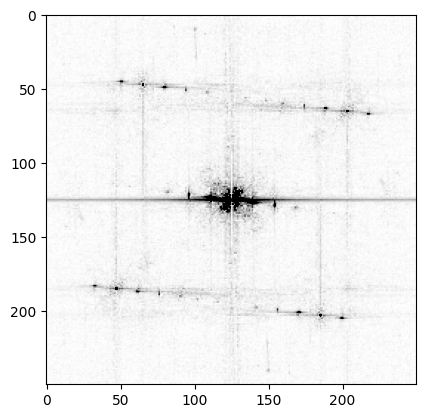

In [20]:
#c2 = mean(t.z_c)
#s2 = std(t.z_c)
#imshow(t.z_c,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])
nx, ny = shape(z_c2)

# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

testsparse = zeros_like(z_c2)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])

## Part 2: reconstruction then drift correction

In [21]:
original_mean = mean(d1.z)
print(original_mean)
test = standardize(d1.z)
print(mean(test))
nx, ny = shape(d1.z)

1.4164720218696852e-23
0.999999890625


Iteration 1:
  fx = 3586996441041617637108350976.000000, xnorm = 250.000706, gnorm = 119783077954135.171875, step = 0.000000, k = 1, ls = 1

Iteration 2:
  fx = 1607560705816201546304585728.000000, xnorm = 41043700680940.359375, gnorm = 80188794873486.906250, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 9906072457362008738627584.000000, xnorm = 63324714613364.500000, gnorm = 6294782746575.294922, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 9525969443829588164608.000000, xnorm = 63030875856599.648438, gnorm = 195202138602.116028, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 378012738500774528.000000, xnorm = 63028377026644.703125, gnorm = 1228491145.548741, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 717098364071606.750000, xnorm = 63028353419319.250000, gnorm = 2816795.152743, step = 1.000000, k = 6, ls = 1



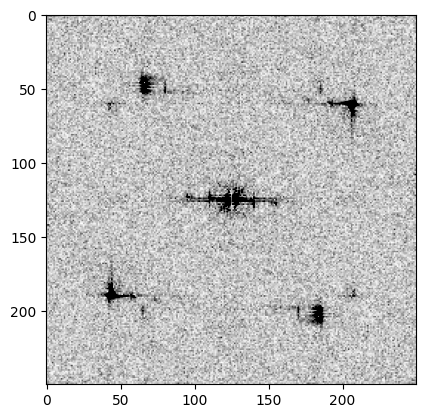

In [23]:
# k = round(nx * ny * 0.50) # 50% sample
#ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri] # same choice of indices

testsparse = zeros_like(d1.z)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])